Here we'll first be loading the FC matrices and explore their structure

In [1]:
#using read_dataset from Datasets/FC/create_dataset.py to read the dataset
from Datasets.FC.create_dataset import read_dataset

In [2]:
dataset = read_dataset()

In [3]:
#ok, let's explore the data a bit more
#dataset is a list object of torch_geometric.data objects

#let's see the first element
print(dataset[0])

#it's a dictionary object, let's see the keys
print(dataset[0].keys())

#ok, let's see the values
print(dataset[0].values())

#it has 4 keys, 'x', 'edge_index', 'edge_attr' and 'y' where y=0 menas the patient is healthy and y=1 means the patient has Autism Spectrum Disorder (ASD)
"""graph = Data(x=ROI.reshape(-1,116).float(),
                     edge_index=G.indices().reshape(2,-1).long(),
                     edge_attr=G.values().reshape(-1,1).float(),
                     y=y.long())"""

#how much data do we have?
len(dataset)


Data(x=[116, 116], edge_index=[2, 1016], edge_attr=[1016, 1], y=[1])
['x', 'edge_index', 'y', 'edge_attr']
ValuesView({'x': tensor([[ 0.0000,  0.4543,  0.2477,  ...,  0.1753,  0.2247, -0.1751],
        [ 0.4543,  0.0000, -0.2204,  ..., -0.1947, -0.2258, -0.1434],
        [ 0.2477, -0.2204,  0.0000,  ..., -0.0521, -0.0804, -0.2025],
        ...,
        [ 0.1753, -0.1947, -0.0521,  ...,  0.0000,  0.6875, -0.1364],
        [ 0.2247, -0.2258, -0.0804,  ...,  0.6875,  0.0000,  0.0929],
        [-0.1751, -0.1434, -0.2025,  ..., -0.1364,  0.0929,  0.0000]]), 'edge_index': tensor([[  0,   0,   0,  ..., 114, 115, 115],
        [  1,  10,  12,  ..., 113,  94, 109]]), 'edge_attr': tensor([[0.4543],
        [0.5913],
        [0.4224],
        ...,
        [0.6875],
        [0.4846],
        [0.5437]]), 'y': tensor([0])})


1099

In [4]:
#set the seed
import torch
torch.manual_seed(0)

MODEL = "GCN"
DATASET = "FC"

from models.models_FC import GCN_framework as framework # import the model

gnn = framework(dataset,device="cpu")

print(gnn.model)
print(gnn.train_idx)

Net(
  (conv_layers): ModuleList(
    (0): GCNConv(116, 128)
    (1-4): 4 x GCNConv(128, 128)
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm(128)
  )
  (lin1): Linear(128, 128, bias=True)
  (lin2): Linear(128, 2, bias=True)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(2)
)
tensor([217, 137, 426,  ..., 643, 205, 434])


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
#gnn.iterate()

In [6]:
#gnn.train()

In [7]:
#save the model 
#gnn.save_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [8]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+"server.pt")

In [9]:
gnn.evaluate()

Test Loss: 0.724, Train Acc: 1.000 Test Acc: 0.673


In [10]:
train_features, test_features = gnn.evaluate_with_features2()

In [11]:
print(len(train_features[0]))
len(train_features), len(test_features)

8


(1044, 55)

In [11]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties = compute_graph_properties(selected_dataset)

In [ ]:
print(len(train_properties))
train_properties[0:5]



In [12]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [13]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x5, x_global, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x_global = np.array([feat[5] for feat in train_features])
test_x_global = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x5, test_x5), (train_x_global, test_x_global), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']

In [13]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 500000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/500000], Property: num_nodes, Loss: 11254.4902
Epoch [2000/500000], Property: num_nodes, Loss: 9736.1846
Epoch [3000/500000], Property: num_nodes, Loss: 8486.0703
Epoch [4000/500000], Property: num_nodes, Loss: 7430.9277
Epoch [5000/500000], Property: num_nodes, Loss: 6530.4951
Epoch [6000/500000], Property: num_nodes, Loss: 5757.3501
Epoch [7000/500000], Property: num_nodes, Loss: 5095.4639
Epoch [8000/500000], Property: num_nodes, Loss: 4533.2495
Epoch [9000/500000], Property: num_nodes, Loss: 4056.4666
Epoch [10000/500000], Property: num_nodes, Loss: 3648.5596
Epoch [11000/500000], Property: num_nodes, Loss: 3294.9548
Epoch [12000/500000], Property: num_nodes, Loss: 2986.7925
Epoch [13000/500000], Property: num_nodes, Loss: 2718.5740
Epoch [14000/500000], Property: num_nodes, Loss: 2486.8418
Epoch [15000/500000], Property: num_nodes, Loss: 2288.6736
Epoch [16000/500000], Property: num_nodes, Loss: 2120.0205
Epoch [17000/500000], Property: num_nodes, Loss: 1976.0278
Epoch

Epoch [143000/500000], Property: num_nodes, Loss: 1.6973
Epoch [144000/500000], Property: num_nodes, Loss: 1.6973
Epoch [145000/500000], Property: num_nodes, Loss: 1.6973
Epoch [146000/500000], Property: num_nodes, Loss: 1.6973
Epoch [147000/500000], Property: num_nodes, Loss: 1.6973
Epoch [148000/500000], Property: num_nodes, Loss: 1.6973
Epoch [149000/500000], Property: num_nodes, Loss: 1.6973
Epoch [150000/500000], Property: num_nodes, Loss: 1.6973
Epoch [151000/500000], Property: num_nodes, Loss: 1.6973
Epoch [152000/500000], Property: num_nodes, Loss: 1.6973
Epoch [153000/500000], Property: num_nodes, Loss: 1.6973
Epoch [154000/500000], Property: num_nodes, Loss: 1.6973
Epoch [155000/500000], Property: num_nodes, Loss: 1.6973
Epoch [156000/500000], Property: num_nodes, Loss: 1.6973
Epoch [157000/500000], Property: num_nodes, Loss: 1.6973
Epoch [158000/500000], Property: num_nodes, Loss: 1.6973
Epoch [159000/500000], Property: num_nodes, Loss: 1.6973
Epoch [160000/500000], Property

Epoch [287000/500000], Property: num_nodes, Loss: 1.6973
Epoch [288000/500000], Property: num_nodes, Loss: 1.6973
Epoch [289000/500000], Property: num_nodes, Loss: 1.6973
Epoch [290000/500000], Property: num_nodes, Loss: 1.6973
Epoch [291000/500000], Property: num_nodes, Loss: 1.6973
Epoch [292000/500000], Property: num_nodes, Loss: 1.6973
Epoch [293000/500000], Property: num_nodes, Loss: 1.6973
Epoch [294000/500000], Property: num_nodes, Loss: 1.6973
Epoch [295000/500000], Property: num_nodes, Loss: 1.6973
Epoch [296000/500000], Property: num_nodes, Loss: 1.6973
Epoch [297000/500000], Property: num_nodes, Loss: 1.6973
Epoch [298000/500000], Property: num_nodes, Loss: 1.6973
Epoch [299000/500000], Property: num_nodes, Loss: 1.6973
Epoch [300000/500000], Property: num_nodes, Loss: 1.6973
Epoch [301000/500000], Property: num_nodes, Loss: 1.6973
Epoch [302000/500000], Property: num_nodes, Loss: 1.6973
Epoch [303000/500000], Property: num_nodes, Loss: 1.6973
Epoch [304000/500000], Property

Epoch [431000/500000], Property: num_nodes, Loss: 1.6973
Epoch [432000/500000], Property: num_nodes, Loss: 1.6973
Epoch [433000/500000], Property: num_nodes, Loss: 1.6973
Epoch [434000/500000], Property: num_nodes, Loss: 1.6973
Epoch [435000/500000], Property: num_nodes, Loss: 1.6973
Epoch [436000/500000], Property: num_nodes, Loss: 1.6973
Epoch [437000/500000], Property: num_nodes, Loss: 1.6973
Epoch [438000/500000], Property: num_nodes, Loss: 1.6973
Epoch [439000/500000], Property: num_nodes, Loss: 1.6973
Epoch [440000/500000], Property: num_nodes, Loss: 1.6973
Epoch [441000/500000], Property: num_nodes, Loss: 1.6973
Epoch [442000/500000], Property: num_nodes, Loss: 1.6973
Epoch [443000/500000], Property: num_nodes, Loss: 1.6973
Epoch [444000/500000], Property: num_nodes, Loss: 1.6973
Epoch [445000/500000], Property: num_nodes, Loss: 1.6973
Epoch [446000/500000], Property: num_nodes, Loss: 1.6973
Epoch [447000/500000], Property: num_nodes, Loss: 1.6973
Epoch [448000/500000], Property

Epoch [69000/500000], Property: num_edges, Loss: 62155.3828
Epoch [70000/500000], Property: num_edges, Loss: 61447.6719
Epoch [71000/500000], Property: num_edges, Loss: 60764.7461
Epoch [72000/500000], Property: num_edges, Loss: 60106.4844
Epoch [73000/500000], Property: num_edges, Loss: 59472.0547
Epoch [74000/500000], Property: num_edges, Loss: 58860.7891
Epoch [75000/500000], Property: num_edges, Loss: 58272.0742
Epoch [76000/500000], Property: num_edges, Loss: 57704.9727
Epoch [77000/500000], Property: num_edges, Loss: 57158.2109
Epoch [78000/500000], Property: num_edges, Loss: 56631.0312
Epoch [79000/500000], Property: num_edges, Loss: 56122.3125
Epoch [80000/500000], Property: num_edges, Loss: 55631.3008
Epoch [81000/500000], Property: num_edges, Loss: 55156.8008
Epoch [82000/500000], Property: num_edges, Loss: 54698.0000
Epoch [83000/500000], Property: num_edges, Loss: 54254.5078
Epoch [84000/500000], Property: num_edges, Loss: 53826.1016
Epoch [85000/500000], Property: num_edge

Epoch [204000/500000], Property: num_edges, Loss: 34120.8750
Epoch [205000/500000], Property: num_edges, Loss: 34027.5781
Epoch [206000/500000], Property: num_edges, Loss: 33934.5664
Epoch [207000/500000], Property: num_edges, Loss: 33841.8359
Epoch [208000/500000], Property: num_edges, Loss: 33749.3945
Epoch [209000/500000], Property: num_edges, Loss: 33657.2383
Epoch [210000/500000], Property: num_edges, Loss: 33565.3633
Epoch [211000/500000], Property: num_edges, Loss: 33473.7695
Epoch [212000/500000], Property: num_edges, Loss: 33382.4688
Epoch [213000/500000], Property: num_edges, Loss: 33291.4492
Epoch [214000/500000], Property: num_edges, Loss: 33200.7070
Epoch [215000/500000], Property: num_edges, Loss: 33110.2617
Epoch [216000/500000], Property: num_edges, Loss: 33020.0938
Epoch [217000/500000], Property: num_edges, Loss: 32930.2070
Epoch [218000/500000], Property: num_edges, Loss: 32840.6094
Epoch [219000/500000], Property: num_edges, Loss: 32751.2988
Epoch [220000/500000], P

Epoch [339000/500000], Property: num_edges, Loss: 24031.6973
Epoch [340000/500000], Property: num_edges, Loss: 23976.3203
Epoch [341000/500000], Property: num_edges, Loss: 23921.2402
Epoch [342000/500000], Property: num_edges, Loss: 23866.4512
Epoch [343000/500000], Property: num_edges, Loss: 23811.9551
Epoch [344000/500000], Property: num_edges, Loss: 23757.7520
Epoch [345000/500000], Property: num_edges, Loss: 23703.8457
Epoch [346000/500000], Property: num_edges, Loss: 23650.2324
Epoch [347000/500000], Property: num_edges, Loss: 23596.9102
Epoch [348000/500000], Property: num_edges, Loss: 23543.8809
Epoch [349000/500000], Property: num_edges, Loss: 23491.1465
Epoch [350000/500000], Property: num_edges, Loss: 23438.7051
Epoch [351000/500000], Property: num_edges, Loss: 23386.5527
Epoch [352000/500000], Property: num_edges, Loss: 23334.7012
Epoch [353000/500000], Property: num_edges, Loss: 23283.1387
Epoch [354000/500000], Property: num_edges, Loss: 23231.8672
Epoch [355000/500000], P

Epoch [474000/500000], Property: num_edges, Loss: 19241.3223
Epoch [475000/500000], Property: num_edges, Loss: 19225.4551
Epoch [476000/500000], Property: num_edges, Loss: 19209.8672
Epoch [477000/500000], Property: num_edges, Loss: 19194.5508
Epoch [478000/500000], Property: num_edges, Loss: 19179.5137
Epoch [479000/500000], Property: num_edges, Loss: 19164.7500
Epoch [480000/500000], Property: num_edges, Loss: 19150.2637
Epoch [481000/500000], Property: num_edges, Loss: 19136.0527
Epoch [482000/500000], Property: num_edges, Loss: 19122.1211
Epoch [483000/500000], Property: num_edges, Loss: 19108.4629
Epoch [484000/500000], Property: num_edges, Loss: 19095.0762
Epoch [485000/500000], Property: num_edges, Loss: 19081.9707
Epoch [486000/500000], Property: num_edges, Loss: 19069.1387
Epoch [487000/500000], Property: num_edges, Loss: 19056.5840
Epoch [488000/500000], Property: num_edges, Loss: 19044.3027
Epoch [489000/500000], Property: num_edges, Loss: 19032.3008
Epoch [490000/500000], P

Epoch [120000/500000], Property: density, Loss: 0.0004
Epoch [121000/500000], Property: density, Loss: 0.0004
Epoch [122000/500000], Property: density, Loss: 0.0004
Epoch [123000/500000], Property: density, Loss: 0.0005
Epoch [124000/500000], Property: density, Loss: 0.0004
Epoch [125000/500000], Property: density, Loss: 0.0004
Epoch [126000/500000], Property: density, Loss: 0.0004
Epoch [127000/500000], Property: density, Loss: 0.0004
Epoch [128000/500000], Property: density, Loss: 0.0004
Epoch [129000/500000], Property: density, Loss: 0.0004
Epoch [130000/500000], Property: density, Loss: 0.0004
Epoch [131000/500000], Property: density, Loss: 0.0004
Epoch [132000/500000], Property: density, Loss: 0.0004
Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0005
Epoch [135000/500000], Property: density, Loss: 0.0004
Epoch [136000/500000], Property: density, Loss: 0.0004
Epoch [137000/500000], Property: density, Loss: 0.0004
Epoch [138

Epoch [269000/500000], Property: density, Loss: 0.0004
Epoch [270000/500000], Property: density, Loss: 0.0004
Epoch [271000/500000], Property: density, Loss: 0.0004
Epoch [272000/500000], Property: density, Loss: 0.0004
Epoch [273000/500000], Property: density, Loss: 0.0004
Epoch [274000/500000], Property: density, Loss: 0.0004
Epoch [275000/500000], Property: density, Loss: 0.0004
Epoch [276000/500000], Property: density, Loss: 0.0004
Epoch [277000/500000], Property: density, Loss: 0.0004
Epoch [278000/500000], Property: density, Loss: 0.0004
Epoch [279000/500000], Property: density, Loss: 0.0004
Epoch [280000/500000], Property: density, Loss: 0.0004
Epoch [281000/500000], Property: density, Loss: 0.0004
Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284000/500000], Property: density, Loss: 0.0004
Epoch [285000/500000], Property: density, Loss: 0.0004
Epoch [286000/500000], Property: density, Loss: 0.0004
Epoch [287

Epoch [418000/500000], Property: density, Loss: 0.0004
Epoch [419000/500000], Property: density, Loss: 0.0004
Epoch [420000/500000], Property: density, Loss: 0.0004
Epoch [421000/500000], Property: density, Loss: 0.0004
Epoch [422000/500000], Property: density, Loss: 0.0004
Epoch [423000/500000], Property: density, Loss: 0.0004
Epoch [424000/500000], Property: density, Loss: 0.0004
Epoch [425000/500000], Property: density, Loss: 0.0004
Epoch [426000/500000], Property: density, Loss: 0.0004
Epoch [427000/500000], Property: density, Loss: 0.0004
Epoch [428000/500000], Property: density, Loss: 0.0004
Epoch [429000/500000], Property: density, Loss: 0.0004
Epoch [430000/500000], Property: density, Loss: 0.0004
Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433000/500000], Property: density, Loss: 0.0004
Epoch [434000/500000], Property: density, Loss: 0.0004
Epoch [435000/500000], Property: density, Loss: 0.0004
Epoch [436

Epoch [61000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [62000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [63000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [64000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [65000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [66000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [67000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [68000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [69000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [70000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [71000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [77000/500000], Property: avg_path_len, Loss: 0.23

Epoch [199000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [200000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [201000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [202000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [203000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [204000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [205000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [206000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [207000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [208000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [209000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [215000/500000], Property: avg_pat

Epoch [336000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [337000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [338000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [339000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [340000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [341000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [342000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [343000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [344000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [345000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [346000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [352000/500000], Property: avg_pat

Epoch [473000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [474000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [475000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [476000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [477000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [478000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [479000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [480000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [481000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [482000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [483000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2379
Epoch [489000/500000], Property: avg_pat

Epoch [106000/500000], Property: num_cliques, Loss: 1365.8715
Epoch [107000/500000], Property: num_cliques, Loss: 1350.4650
Epoch [108000/500000], Property: num_cliques, Loss: 1335.3386
Epoch [109000/500000], Property: num_cliques, Loss: 1320.4924
Epoch [110000/500000], Property: num_cliques, Loss: 1305.9265
Epoch [111000/500000], Property: num_cliques, Loss: 1291.6406
Epoch [112000/500000], Property: num_cliques, Loss: 1277.6865
Epoch [113000/500000], Property: num_cliques, Loss: 1264.0653
Epoch [114000/500000], Property: num_cliques, Loss: 1250.7197
Epoch [115000/500000], Property: num_cliques, Loss: 1237.6501
Epoch [116000/500000], Property: num_cliques, Loss: 1224.8564
Epoch [117000/500000], Property: num_cliques, Loss: 1212.3383
Epoch [118000/500000], Property: num_cliques, Loss: 1200.0961
Epoch [119000/500000], Property: num_cliques, Loss: 1188.1299
Epoch [120000/500000], Property: num_cliques, Loss: 1176.4392
Epoch [121000/500000], Property: num_cliques, Loss: 1165.0245
Epoch [1

Epoch [240000/500000], Property: num_cliques, Loss: 934.5007
Epoch [241000/500000], Property: num_cliques, Loss: 934.5007
Epoch [242000/500000], Property: num_cliques, Loss: 934.5007
Epoch [243000/500000], Property: num_cliques, Loss: 934.5006
Epoch [244000/500000], Property: num_cliques, Loss: 934.5007
Epoch [245000/500000], Property: num_cliques, Loss: 934.5007
Epoch [246000/500000], Property: num_cliques, Loss: 934.5007
Epoch [247000/500000], Property: num_cliques, Loss: 934.5007
Epoch [248000/500000], Property: num_cliques, Loss: 934.5007
Epoch [249000/500000], Property: num_cliques, Loss: 934.5007
Epoch [250000/500000], Property: num_cliques, Loss: 934.5007
Epoch [251000/500000], Property: num_cliques, Loss: 934.5007
Epoch [252000/500000], Property: num_cliques, Loss: 934.5007
Epoch [253000/500000], Property: num_cliques, Loss: 934.5007
Epoch [254000/500000], Property: num_cliques, Loss: 934.5007
Epoch [255000/500000], Property: num_cliques, Loss: 934.5008
Epoch [256000/500000], P

Epoch [375000/500000], Property: num_cliques, Loss: 934.5007
Epoch [376000/500000], Property: num_cliques, Loss: 934.5007
Epoch [377000/500000], Property: num_cliques, Loss: 934.5007
Epoch [378000/500000], Property: num_cliques, Loss: 934.5007
Epoch [379000/500000], Property: num_cliques, Loss: 934.5007
Epoch [380000/500000], Property: num_cliques, Loss: 934.5007
Epoch [381000/500000], Property: num_cliques, Loss: 934.5007
Epoch [382000/500000], Property: num_cliques, Loss: 934.5006
Epoch [383000/500000], Property: num_cliques, Loss: 934.5006
Epoch [384000/500000], Property: num_cliques, Loss: 934.5007
Epoch [385000/500000], Property: num_cliques, Loss: 934.5007
Epoch [386000/500000], Property: num_cliques, Loss: 934.5007
Epoch [387000/500000], Property: num_cliques, Loss: 934.5007
Epoch [388000/500000], Property: num_cliques, Loss: 934.5007
Epoch [389000/500000], Property: num_cliques, Loss: 934.5007
Epoch [390000/500000], Property: num_cliques, Loss: 934.5007
Epoch [391000/500000], P

Epoch [7000/500000], Property: num_triangles, Loss: 1559873.3750
Epoch [8000/500000], Property: num_triangles, Loss: 1542967.5000
Epoch [9000/500000], Property: num_triangles, Loss: 1526428.7500
Epoch [10000/500000], Property: num_triangles, Loss: 1510239.7500
Epoch [11000/500000], Property: num_triangles, Loss: 1494381.6250
Epoch [12000/500000], Property: num_triangles, Loss: 1478833.7500
Epoch [13000/500000], Property: num_triangles, Loss: 1463572.1250
Epoch [14000/500000], Property: num_triangles, Loss: 1448590.3750
Epoch [15000/500000], Property: num_triangles, Loss: 1433890.6250
Epoch [16000/500000], Property: num_triangles, Loss: 1419469.3750
Epoch [17000/500000], Property: num_triangles, Loss: 1405316.7500
Epoch [18000/500000], Property: num_triangles, Loss: 1391422.5000
Epoch [19000/500000], Property: num_triangles, Loss: 1377781.5000
Epoch [20000/500000], Property: num_triangles, Loss: 1364389.2500
Epoch [21000/500000], Property: num_triangles, Loss: 1351242.8750
Epoch [22000/

Epoch [132000/500000], Property: num_triangles, Loss: 735115.0625
Epoch [133000/500000], Property: num_triangles, Loss: 733251.3125
Epoch [134000/500000], Property: num_triangles, Loss: 731418.2500
Epoch [135000/500000], Property: num_triangles, Loss: 729615.5625
Epoch [136000/500000], Property: num_triangles, Loss: 727842.6250
Epoch [137000/500000], Property: num_triangles, Loss: 726099.1250
Epoch [138000/500000], Property: num_triangles, Loss: 724383.2500
Epoch [139000/500000], Property: num_triangles, Loss: 722694.4375
Epoch [140000/500000], Property: num_triangles, Loss: 721031.7500
Epoch [141000/500000], Property: num_triangles, Loss: 719394.5625
Epoch [142000/500000], Property: num_triangles, Loss: 717783.0625
Epoch [143000/500000], Property: num_triangles, Loss: 716196.8125
Epoch [144000/500000], Property: num_triangles, Loss: 714635.6250
Epoch [145000/500000], Property: num_triangles, Loss: 713099.3750
Epoch [146000/500000], Property: num_triangles, Loss: 711587.8125
Epoch [147

Epoch [257000/500000], Property: num_triangles, Loss: 620550.1875
Epoch [258000/500000], Property: num_triangles, Loss: 620099.5625
Epoch [259000/500000], Property: num_triangles, Loss: 619650.5625
Epoch [260000/500000], Property: num_triangles, Loss: 619204.6250
Epoch [261000/500000], Property: num_triangles, Loss: 618762.6875
Epoch [262000/500000], Property: num_triangles, Loss: 618324.6875
Epoch [263000/500000], Property: num_triangles, Loss: 617890.4375
Epoch [264000/500000], Property: num_triangles, Loss: 617460.1250
Epoch [265000/500000], Property: num_triangles, Loss: 617033.7500
Epoch [266000/500000], Property: num_triangles, Loss: 616611.1875
Epoch [267000/500000], Property: num_triangles, Loss: 616192.5625
Epoch [268000/500000], Property: num_triangles, Loss: 615777.9375
Epoch [269000/500000], Property: num_triangles, Loss: 615367.2500
Epoch [270000/500000], Property: num_triangles, Loss: 614960.4375
Epoch [271000/500000], Property: num_triangles, Loss: 614557.3750
Epoch [272

Epoch [382000/500000], Property: num_triangles, Loss: 583109.3750
Epoch [383000/500000], Property: num_triangles, Loss: 582890.8125
Epoch [384000/500000], Property: num_triangles, Loss: 582672.5625
Epoch [385000/500000], Property: num_triangles, Loss: 582454.8750
Epoch [386000/500000], Property: num_triangles, Loss: 582237.6875
Epoch [387000/500000], Property: num_triangles, Loss: 582020.8750
Epoch [388000/500000], Property: num_triangles, Loss: 581804.5625
Epoch [389000/500000], Property: num_triangles, Loss: 581588.8125
Epoch [390000/500000], Property: num_triangles, Loss: 581373.5000
Epoch [391000/500000], Property: num_triangles, Loss: 581158.5625
Epoch [392000/500000], Property: num_triangles, Loss: 580944.1250
Epoch [393000/500000], Property: num_triangles, Loss: 580730.1875
Epoch [394000/500000], Property: num_triangles, Loss: 580516.7500
Epoch [395000/500000], Property: num_triangles, Loss: 580303.6875
Epoch [396000/500000], Property: num_triangles, Loss: 580091.1875
Epoch [397

Epoch [5000/500000], Property: num_squares, Loss: 3.4810
Epoch [6000/500000], Property: num_squares, Loss: 2.8158
Epoch [7000/500000], Property: num_squares, Loss: 2.2738
Epoch [8000/500000], Property: num_squares, Loss: 1.8846
Epoch [9000/500000], Property: num_squares, Loss: 1.6496
Epoch [10000/500000], Property: num_squares, Loss: 1.5394
Epoch [11000/500000], Property: num_squares, Loss: 1.5060
Epoch [12000/500000], Property: num_squares, Loss: 1.5013
Epoch [13000/500000], Property: num_squares, Loss: 1.5011
Epoch [14000/500000], Property: num_squares, Loss: 1.5011
Epoch [15000/500000], Property: num_squares, Loss: 1.5011
Epoch [16000/500000], Property: num_squares, Loss: 1.5011
Epoch [17000/500000], Property: num_squares, Loss: 1.5011
Epoch [18000/500000], Property: num_squares, Loss: 1.5011
Epoch [19000/500000], Property: num_squares, Loss: 1.5011
Epoch [20000/500000], Property: num_squares, Loss: 1.5011
Epoch [21000/500000], Property: num_squares, Loss: 1.5011
Epoch [22000/500000

Epoch [146000/500000], Property: num_squares, Loss: 1.5011
Epoch [147000/500000], Property: num_squares, Loss: 1.5011
Epoch [148000/500000], Property: num_squares, Loss: 1.5011
Epoch [149000/500000], Property: num_squares, Loss: 1.5011
Epoch [150000/500000], Property: num_squares, Loss: 1.5011
Epoch [151000/500000], Property: num_squares, Loss: 1.5011
Epoch [152000/500000], Property: num_squares, Loss: 1.5011
Epoch [153000/500000], Property: num_squares, Loss: 1.5011
Epoch [154000/500000], Property: num_squares, Loss: 1.5011
Epoch [155000/500000], Property: num_squares, Loss: 1.5011
Epoch [156000/500000], Property: num_squares, Loss: 1.5011
Epoch [157000/500000], Property: num_squares, Loss: 1.5011
Epoch [158000/500000], Property: num_squares, Loss: 1.5011
Epoch [159000/500000], Property: num_squares, Loss: 1.5011
Epoch [160000/500000], Property: num_squares, Loss: 1.5011
Epoch [161000/500000], Property: num_squares, Loss: 1.5011
Epoch [162000/500000], Property: num_squares, Loss: 1.50

Epoch [285000/500000], Property: num_squares, Loss: 1.5011
Epoch [286000/500000], Property: num_squares, Loss: 1.5011
Epoch [287000/500000], Property: num_squares, Loss: 1.5011
Epoch [288000/500000], Property: num_squares, Loss: 1.5011
Epoch [289000/500000], Property: num_squares, Loss: 1.5011
Epoch [290000/500000], Property: num_squares, Loss: 1.5011
Epoch [291000/500000], Property: num_squares, Loss: 1.5011
Epoch [292000/500000], Property: num_squares, Loss: 1.5011
Epoch [293000/500000], Property: num_squares, Loss: 1.5011
Epoch [294000/500000], Property: num_squares, Loss: 1.5011
Epoch [295000/500000], Property: num_squares, Loss: 1.5011
Epoch [296000/500000], Property: num_squares, Loss: 1.5011
Epoch [297000/500000], Property: num_squares, Loss: 1.5011
Epoch [298000/500000], Property: num_squares, Loss: 1.5011
Epoch [299000/500000], Property: num_squares, Loss: 1.5011
Epoch [300000/500000], Property: num_squares, Loss: 1.5011
Epoch [301000/500000], Property: num_squares, Loss: 1.50

Epoch [424000/500000], Property: num_squares, Loss: 1.5011
Epoch [425000/500000], Property: num_squares, Loss: 1.5011
Epoch [426000/500000], Property: num_squares, Loss: 1.5011
Epoch [427000/500000], Property: num_squares, Loss: 1.5011
Epoch [428000/500000], Property: num_squares, Loss: 1.5011
Epoch [429000/500000], Property: num_squares, Loss: 1.5011
Epoch [430000/500000], Property: num_squares, Loss: 1.5011
Epoch [431000/500000], Property: num_squares, Loss: 1.5011
Epoch [432000/500000], Property: num_squares, Loss: 1.5011
Epoch [433000/500000], Property: num_squares, Loss: 1.5011
Epoch [434000/500000], Property: num_squares, Loss: 1.5011
Epoch [435000/500000], Property: num_squares, Loss: 1.5011
Epoch [436000/500000], Property: num_squares, Loss: 1.5011
Epoch [437000/500000], Property: num_squares, Loss: 1.5011
Epoch [438000/500000], Property: num_squares, Loss: 1.5011
Epoch [439000/500000], Property: num_squares, Loss: 1.5011
Epoch [440000/500000], Property: num_squares, Loss: 1.50

Epoch [35000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 978.4077
Epoch [36000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 952.5732
Epoch [37000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 927.6210
Epoch [38000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 903.5159
Epoch [39000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 880.1920
Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 857.5474
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 835.4573
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 813.7987
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 792.5764
Epoch [44000/500000], Property: number_of_nodes_in_the_

Epoch [114000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10.2236
Epoch [115000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 9.0362
Epoch [116000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.0794
Epoch [117000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 7.3424
Epoch [118000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.8102
Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.4619
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2674
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1848
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1634
Epoch [123000/500000], Property: number_of_nodes_in_the_largest

Epoch [193000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [194000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [195000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [196000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [197000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1611
Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_

Epoch [272000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [273000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [274000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [275000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [276000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_

Epoch [351000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [352000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [353000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [354000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [355000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_

Epoch [430000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [431000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [432000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [433000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [434000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1611
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1610
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_

Epoch [12000/500000], Property: num_nodes, Loss: 2396.2119
Epoch [13000/500000], Property: num_nodes, Loss: 2192.4880
Epoch [14000/500000], Property: num_nodes, Loss: 2025.4653
Epoch [15000/500000], Property: num_nodes, Loss: 1887.0343
Epoch [16000/500000], Property: num_nodes, Loss: 1770.8956
Epoch [17000/500000], Property: num_nodes, Loss: 1672.0454
Epoch [18000/500000], Property: num_nodes, Loss: 1586.6240
Epoch [19000/500000], Property: num_nodes, Loss: 1512.0308
Epoch [20000/500000], Property: num_nodes, Loss: 1446.6615
Epoch [21000/500000], Property: num_nodes, Loss: 1389.1080
Epoch [22000/500000], Property: num_nodes, Loss: 1337.9705
Epoch [23000/500000], Property: num_nodes, Loss: 1292.0553
Epoch [24000/500000], Property: num_nodes, Loss: 1250.5580
Epoch [25000/500000], Property: num_nodes, Loss: 1212.9390
Epoch [26000/500000], Property: num_nodes, Loss: 1178.5970
Epoch [27000/500000], Property: num_nodes, Loss: 1146.9031
Epoch [28000/500000], Property: num_nodes, Loss: 1117.40

Epoch [154000/500000], Property: num_nodes, Loss: 1.7381
Epoch [155000/500000], Property: num_nodes, Loss: 1.7381
Epoch [156000/500000], Property: num_nodes, Loss: 1.7381
Epoch [157000/500000], Property: num_nodes, Loss: 1.7381
Epoch [158000/500000], Property: num_nodes, Loss: 1.7381
Epoch [159000/500000], Property: num_nodes, Loss: 1.7381
Epoch [160000/500000], Property: num_nodes, Loss: 1.7381
Epoch [161000/500000], Property: num_nodes, Loss: 1.7381
Epoch [162000/500000], Property: num_nodes, Loss: 1.7381
Epoch [163000/500000], Property: num_nodes, Loss: 1.7381
Epoch [164000/500000], Property: num_nodes, Loss: 1.7381
Epoch [165000/500000], Property: num_nodes, Loss: 1.7381
Epoch [166000/500000], Property: num_nodes, Loss: 1.7381
Epoch [167000/500000], Property: num_nodes, Loss: 1.7381
Epoch [168000/500000], Property: num_nodes, Loss: 1.7381
Epoch [169000/500000], Property: num_nodes, Loss: 1.7381
Epoch [170000/500000], Property: num_nodes, Loss: 1.7381
Epoch [171000/500000], Property

Epoch [298000/500000], Property: num_nodes, Loss: 1.7381
Epoch [299000/500000], Property: num_nodes, Loss: 1.7381
Epoch [300000/500000], Property: num_nodes, Loss: 1.7381
Epoch [301000/500000], Property: num_nodes, Loss: 1.7381
Epoch [302000/500000], Property: num_nodes, Loss: 1.7381
Epoch [303000/500000], Property: num_nodes, Loss: 1.7381
Epoch [304000/500000], Property: num_nodes, Loss: 1.7381
Epoch [305000/500000], Property: num_nodes, Loss: 1.7381
Epoch [306000/500000], Property: num_nodes, Loss: 1.7381
Epoch [307000/500000], Property: num_nodes, Loss: 1.7381
Epoch [308000/500000], Property: num_nodes, Loss: 1.7381
Epoch [309000/500000], Property: num_nodes, Loss: 1.7381
Epoch [310000/500000], Property: num_nodes, Loss: 1.7381
Epoch [311000/500000], Property: num_nodes, Loss: 1.7381
Epoch [312000/500000], Property: num_nodes, Loss: 1.7381
Epoch [313000/500000], Property: num_nodes, Loss: 1.7381
Epoch [314000/500000], Property: num_nodes, Loss: 1.7381
Epoch [315000/500000], Property

Epoch [442000/500000], Property: num_nodes, Loss: 1.7381
Epoch [443000/500000], Property: num_nodes, Loss: 1.7381
Epoch [444000/500000], Property: num_nodes, Loss: 1.7381
Epoch [445000/500000], Property: num_nodes, Loss: 1.7381
Epoch [446000/500000], Property: num_nodes, Loss: 1.7381
Epoch [447000/500000], Property: num_nodes, Loss: 1.7381
Epoch [448000/500000], Property: num_nodes, Loss: 1.7381
Epoch [449000/500000], Property: num_nodes, Loss: 1.7381
Epoch [450000/500000], Property: num_nodes, Loss: 1.7381
Epoch [451000/500000], Property: num_nodes, Loss: 1.7381
Epoch [452000/500000], Property: num_nodes, Loss: 1.7381
Epoch [453000/500000], Property: num_nodes, Loss: 1.7381
Epoch [454000/500000], Property: num_nodes, Loss: 1.7381
Epoch [455000/500000], Property: num_nodes, Loss: 1.7381
Epoch [456000/500000], Property: num_nodes, Loss: 1.7381
Epoch [457000/500000], Property: num_nodes, Loss: 1.7381
Epoch [458000/500000], Property: num_nodes, Loss: 1.7381
Epoch [459000/500000], Property

Epoch [79000/500000], Property: num_edges, Loss: 51055.5625
Epoch [80000/500000], Property: num_edges, Loss: 50700.0859
Epoch [81000/500000], Property: num_edges, Loss: 50354.6562
Epoch [82000/500000], Property: num_edges, Loss: 50019.0234
Epoch [83000/500000], Property: num_edges, Loss: 49692.9727
Epoch [84000/500000], Property: num_edges, Loss: 49376.2500
Epoch [85000/500000], Property: num_edges, Loss: 49068.7305
Epoch [86000/500000], Property: num_edges, Loss: 48769.8867
Epoch [87000/500000], Property: num_edges, Loss: 48479.2930
Epoch [88000/500000], Property: num_edges, Loss: 48196.5547
Epoch [89000/500000], Property: num_edges, Loss: 47921.4219
Epoch [90000/500000], Property: num_edges, Loss: 47653.7656
Epoch [91000/500000], Property: num_edges, Loss: 47393.4688
Epoch [92000/500000], Property: num_edges, Loss: 47140.3242
Epoch [93000/500000], Property: num_edges, Loss: 46894.2656
Epoch [94000/500000], Property: num_edges, Loss: 46654.9883
Epoch [95000/500000], Property: num_edge

Epoch [214000/500000], Property: num_edges, Loss: 32525.2715
Epoch [215000/500000], Property: num_edges, Loss: 32438.1191
Epoch [216000/500000], Property: num_edges, Loss: 32351.2422
Epoch [217000/500000], Property: num_edges, Loss: 32264.6328
Epoch [218000/500000], Property: num_edges, Loss: 32178.3027
Epoch [219000/500000], Property: num_edges, Loss: 32092.2363
Epoch [220000/500000], Property: num_edges, Loss: 32006.4531
Epoch [221000/500000], Property: num_edges, Loss: 31920.9336
Epoch [222000/500000], Property: num_edges, Loss: 31835.6875
Epoch [223000/500000], Property: num_edges, Loss: 31750.7188
Epoch [224000/500000], Property: num_edges, Loss: 31666.0195
Epoch [225000/500000], Property: num_edges, Loss: 31581.5938
Epoch [226000/500000], Property: num_edges, Loss: 31497.4414
Epoch [227000/500000], Property: num_edges, Loss: 31413.5586
Epoch [228000/500000], Property: num_edges, Loss: 31329.9512
Epoch [229000/500000], Property: num_edges, Loss: 31246.6172
Epoch [230000/500000], P

Epoch [349000/500000], Property: num_edges, Loss: 23156.0293
Epoch [350000/500000], Property: num_edges, Loss: 23105.2891
Epoch [351000/500000], Property: num_edges, Loss: 23054.8281
Epoch [352000/500000], Property: num_edges, Loss: 23004.6484
Epoch [353000/500000], Property: num_edges, Loss: 22954.7480
Epoch [354000/500000], Property: num_edges, Loss: 22905.1309
Epoch [355000/500000], Property: num_edges, Loss: 22855.7930
Epoch [356000/500000], Property: num_edges, Loss: 22806.7383
Epoch [357000/500000], Property: num_edges, Loss: 22757.9629
Epoch [358000/500000], Property: num_edges, Loss: 22709.4688
Epoch [359000/500000], Property: num_edges, Loss: 22661.2539
Epoch [360000/500000], Property: num_edges, Loss: 22613.3223
Epoch [361000/500000], Property: num_edges, Loss: 22565.6738
Epoch [362000/500000], Property: num_edges, Loss: 22518.3027
Epoch [363000/500000], Property: num_edges, Loss: 22471.2168
Epoch [364000/500000], Property: num_edges, Loss: 22424.4082
Epoch [365000/500000], P

Epoch [484000/500000], Property: num_edges, Loss: 18877.4746
Epoch [485000/500000], Property: num_edges, Loss: 18864.4492
Epoch [486000/500000], Property: num_edges, Loss: 18851.6875
Epoch [487000/500000], Property: num_edges, Loss: 18839.1914
Epoch [488000/500000], Property: num_edges, Loss: 18826.9609
Epoch [489000/500000], Property: num_edges, Loss: 18814.9922
Epoch [490000/500000], Property: num_edges, Loss: 18803.2871
Epoch [491000/500000], Property: num_edges, Loss: 18791.8496
Epoch [492000/500000], Property: num_edges, Loss: 18780.6738
Epoch [493000/500000], Property: num_edges, Loss: 18769.7617
Epoch [494000/500000], Property: num_edges, Loss: 18759.1172
Epoch [495000/500000], Property: num_edges, Loss: 18748.7344
Epoch [496000/500000], Property: num_edges, Loss: 18738.6172
Epoch [497000/500000], Property: num_edges, Loss: 18728.7637
Epoch [498000/500000], Property: num_edges, Loss: 18719.1738
Epoch [499000/500000], Property: num_edges, Loss: 18709.8496
Epoch [500000/500000], P

Epoch [131000/500000], Property: density, Loss: 0.0004
Epoch [132000/500000], Property: density, Loss: 0.0004
Epoch [133000/500000], Property: density, Loss: 0.0004
Epoch [134000/500000], Property: density, Loss: 0.0004
Epoch [135000/500000], Property: density, Loss: 0.0004
Epoch [136000/500000], Property: density, Loss: 0.0004
Epoch [137000/500000], Property: density, Loss: 0.0004
Epoch [138000/500000], Property: density, Loss: 0.0004
Epoch [139000/500000], Property: density, Loss: 0.0004
Epoch [140000/500000], Property: density, Loss: 0.0004
Epoch [141000/500000], Property: density, Loss: 0.0004
Epoch [142000/500000], Property: density, Loss: 0.0004
Epoch [143000/500000], Property: density, Loss: 0.0004
Epoch [144000/500000], Property: density, Loss: 0.0004
Epoch [145000/500000], Property: density, Loss: 0.0004
Epoch [146000/500000], Property: density, Loss: 0.0004
Epoch [147000/500000], Property: density, Loss: 0.0004
Epoch [148000/500000], Property: density, Loss: 0.0004
Epoch [149

Epoch [280000/500000], Property: density, Loss: 0.0004
Epoch [281000/500000], Property: density, Loss: 0.0004
Epoch [282000/500000], Property: density, Loss: 0.0004
Epoch [283000/500000], Property: density, Loss: 0.0004
Epoch [284000/500000], Property: density, Loss: 0.0004
Epoch [285000/500000], Property: density, Loss: 0.0004
Epoch [286000/500000], Property: density, Loss: 0.0004
Epoch [287000/500000], Property: density, Loss: 0.0004
Epoch [288000/500000], Property: density, Loss: 0.0004
Epoch [289000/500000], Property: density, Loss: 0.0004
Epoch [290000/500000], Property: density, Loss: 0.0004
Epoch [291000/500000], Property: density, Loss: 0.0004
Epoch [292000/500000], Property: density, Loss: 0.0004
Epoch [293000/500000], Property: density, Loss: 0.0004
Epoch [294000/500000], Property: density, Loss: 0.0004
Epoch [295000/500000], Property: density, Loss: 0.0004
Epoch [296000/500000], Property: density, Loss: 0.0004
Epoch [297000/500000], Property: density, Loss: 0.0004
Epoch [298

Epoch [429000/500000], Property: density, Loss: 0.0004
Epoch [430000/500000], Property: density, Loss: 0.0004
Epoch [431000/500000], Property: density, Loss: 0.0004
Epoch [432000/500000], Property: density, Loss: 0.0004
Epoch [433000/500000], Property: density, Loss: 0.0004
Epoch [434000/500000], Property: density, Loss: 0.0004
Epoch [435000/500000], Property: density, Loss: 0.0004
Epoch [436000/500000], Property: density, Loss: 0.0004
Epoch [437000/500000], Property: density, Loss: 0.0004
Epoch [438000/500000], Property: density, Loss: 0.0004
Epoch [439000/500000], Property: density, Loss: 0.0004
Epoch [440000/500000], Property: density, Loss: 0.0004
Epoch [441000/500000], Property: density, Loss: 0.0004
Epoch [442000/500000], Property: density, Loss: 0.0004
Epoch [443000/500000], Property: density, Loss: 0.0004
Epoch [444000/500000], Property: density, Loss: 0.0004
Epoch [445000/500000], Property: density, Loss: 0.0004
Epoch [446000/500000], Property: density, Loss: 0.0004
Epoch [447

Epoch [71000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [72000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [73000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [74000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [75000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [76000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [77000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [78000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [79000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [80000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [81000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [82000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [83000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [84000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [85000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [86000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [87000/500000], Property: avg_path_len, Loss: 0.23

Epoch [209000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [210000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [211000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [212000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [213000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [214000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [215000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [216000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [217000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [218000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [219000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [220000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [221000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [222000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [223000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [224000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [225000/500000], Property: avg_pat

Epoch [346000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [347000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [348000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [349000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [350000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [351000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [352000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [353000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [354000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [355000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [356000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [357000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [358000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [359000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [360000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [361000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [362000/500000], Property: avg_pat

Epoch [483000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [484000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [485000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [486000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [487000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [488000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [489000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [490000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [491000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [492000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [493000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [494000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [495000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [496000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [497000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [498000/500000], Property: avg_path_len, Loss: 0.2361
Epoch [499000/500000], Property: avg_pat

Epoch [116000/500000], Property: num_cliques, Loss: 1194.6567
Epoch [117000/500000], Property: num_cliques, Loss: 1182.7174
Epoch [118000/500000], Property: num_cliques, Loss: 1171.0424
Epoch [119000/500000], Property: num_cliques, Loss: 1159.6315
Epoch [120000/500000], Property: num_cliques, Loss: 1148.4849
Epoch [121000/500000], Property: num_cliques, Loss: 1137.6028
Epoch [122000/500000], Property: num_cliques, Loss: 1126.9846
Epoch [123000/500000], Property: num_cliques, Loss: 1116.6310
Epoch [124000/500000], Property: num_cliques, Loss: 1106.5416
Epoch [125000/500000], Property: num_cliques, Loss: 1096.7164
Epoch [126000/500000], Property: num_cliques, Loss: 1087.1663
Epoch [127000/500000], Property: num_cliques, Loss: 1077.9409
Epoch [128000/500000], Property: num_cliques, Loss: 1068.9757
Epoch [129000/500000], Property: num_cliques, Loss: 1060.2709
Epoch [130000/500000], Property: num_cliques, Loss: 1051.8259
Epoch [131000/500000], Property: num_cliques, Loss: 1043.6411
Epoch [1

Epoch [250000/500000], Property: num_cliques, Loss: 918.9550
Epoch [251000/500000], Property: num_cliques, Loss: 918.9550
Epoch [252000/500000], Property: num_cliques, Loss: 918.9550
Epoch [253000/500000], Property: num_cliques, Loss: 918.9550
Epoch [254000/500000], Property: num_cliques, Loss: 918.9550
Epoch [255000/500000], Property: num_cliques, Loss: 918.9550
Epoch [256000/500000], Property: num_cliques, Loss: 918.9551
Epoch [257000/500000], Property: num_cliques, Loss: 918.9551
Epoch [258000/500000], Property: num_cliques, Loss: 918.9550
Epoch [259000/500000], Property: num_cliques, Loss: 918.9550
Epoch [260000/500000], Property: num_cliques, Loss: 918.9551
Epoch [261000/500000], Property: num_cliques, Loss: 918.9550
Epoch [262000/500000], Property: num_cliques, Loss: 918.9550
Epoch [263000/500000], Property: num_cliques, Loss: 918.9551
Epoch [264000/500000], Property: num_cliques, Loss: 918.9550
Epoch [265000/500000], Property: num_cliques, Loss: 918.9550
Epoch [266000/500000], P

Epoch [385000/500000], Property: num_cliques, Loss: 918.9550
Epoch [386000/500000], Property: num_cliques, Loss: 918.9550
Epoch [387000/500000], Property: num_cliques, Loss: 918.9551
Epoch [388000/500000], Property: num_cliques, Loss: 918.9550
Epoch [389000/500000], Property: num_cliques, Loss: 918.9550
Epoch [390000/500000], Property: num_cliques, Loss: 918.9550
Epoch [391000/500000], Property: num_cliques, Loss: 918.9550
Epoch [392000/500000], Property: num_cliques, Loss: 918.9550
Epoch [393000/500000], Property: num_cliques, Loss: 918.9550
Epoch [394000/500000], Property: num_cliques, Loss: 918.9550
Epoch [395000/500000], Property: num_cliques, Loss: 918.9550
Epoch [396000/500000], Property: num_cliques, Loss: 918.9551
Epoch [397000/500000], Property: num_cliques, Loss: 918.9550
Epoch [398000/500000], Property: num_cliques, Loss: 918.9550
Epoch [399000/500000], Property: num_cliques, Loss: 918.9550
Epoch [400000/500000], Property: num_cliques, Loss: 918.9550
Epoch [401000/500000], P

Epoch [16000/500000], Property: num_triangles, Loss: 1375515.2500
Epoch [17000/500000], Property: num_triangles, Loss: 1359753.0000
Epoch [18000/500000], Property: num_triangles, Loss: 1344321.6250
Epoch [19000/500000], Property: num_triangles, Loss: 1329212.5000
Epoch [20000/500000], Property: num_triangles, Loss: 1314418.3750
Epoch [21000/500000], Property: num_triangles, Loss: 1299934.1250
Epoch [22000/500000], Property: num_triangles, Loss: 1285753.8750
Epoch [23000/500000], Property: num_triangles, Loss: 1271877.6250
Epoch [24000/500000], Property: num_triangles, Loss: 1258303.8750
Epoch [25000/500000], Property: num_triangles, Loss: 1245029.6250
Epoch [26000/500000], Property: num_triangles, Loss: 1232046.0000
Epoch [27000/500000], Property: num_triangles, Loss: 1219346.7500
Epoch [28000/500000], Property: num_triangles, Loss: 1206925.3750
Epoch [29000/500000], Property: num_triangles, Loss: 1194768.0000
Epoch [30000/500000], Property: num_triangles, Loss: 1182863.8750
Epoch [310

Epoch [141000/500000], Property: num_triangles, Loss: 690217.4375
Epoch [142000/500000], Property: num_triangles, Loss: 689010.2500
Epoch [143000/500000], Property: num_triangles, Loss: 687822.6250
Epoch [144000/500000], Property: num_triangles, Loss: 686654.3750
Epoch [145000/500000], Property: num_triangles, Loss: 685504.5625
Epoch [146000/500000], Property: num_triangles, Loss: 684372.8750
Epoch [147000/500000], Property: num_triangles, Loss: 683259.1250
Epoch [148000/500000], Property: num_triangles, Loss: 682162.7500
Epoch [149000/500000], Property: num_triangles, Loss: 681083.1875
Epoch [150000/500000], Property: num_triangles, Loss: 680019.8750
Epoch [151000/500000], Property: num_triangles, Loss: 678971.8125
Epoch [152000/500000], Property: num_triangles, Loss: 677938.1250
Epoch [153000/500000], Property: num_triangles, Loss: 676918.1875
Epoch [154000/500000], Property: num_triangles, Loss: 675912.0000
Epoch [155000/500000], Property: num_triangles, Loss: 674919.3750
Epoch [156

Epoch [266000/500000], Property: num_triangles, Loss: 613190.8750
Epoch [267000/500000], Property: num_triangles, Loss: 612873.5000
Epoch [268000/500000], Property: num_triangles, Loss: 612558.0000
Epoch [269000/500000], Property: num_triangles, Loss: 612244.3125
Epoch [270000/500000], Property: num_triangles, Loss: 611932.3125
Epoch [271000/500000], Property: num_triangles, Loss: 611622.0000
Epoch [272000/500000], Property: num_triangles, Loss: 611313.6250
Epoch [273000/500000], Property: num_triangles, Loss: 611006.8125
Epoch [274000/500000], Property: num_triangles, Loss: 610701.8750
Epoch [275000/500000], Property: num_triangles, Loss: 610398.4375
Epoch [276000/500000], Property: num_triangles, Loss: 610096.8125
Epoch [277000/500000], Property: num_triangles, Loss: 609796.8125
Epoch [278000/500000], Property: num_triangles, Loss: 609498.5000
Epoch [279000/500000], Property: num_triangles, Loss: 609201.8125
Epoch [280000/500000], Property: num_triangles, Loss: 608906.7500
Epoch [281

Epoch [391000/500000], Property: num_triangles, Loss: 582587.1875
Epoch [392000/500000], Property: num_triangles, Loss: 582382.0625
Epoch [393000/500000], Property: num_triangles, Loss: 582177.1875
Epoch [394000/500000], Property: num_triangles, Loss: 581972.5625
Epoch [395000/500000], Property: num_triangles, Loss: 581768.1875
Epoch [396000/500000], Property: num_triangles, Loss: 581564.1250
Epoch [397000/500000], Property: num_triangles, Loss: 581360.4375
Epoch [398000/500000], Property: num_triangles, Loss: 581156.8750
Epoch [399000/500000], Property: num_triangles, Loss: 580953.6875
Epoch [400000/500000], Property: num_triangles, Loss: 580750.7500
Epoch [401000/500000], Property: num_triangles, Loss: 580548.1250
Epoch [402000/500000], Property: num_triangles, Loss: 580345.6875
Epoch [403000/500000], Property: num_triangles, Loss: 580143.6250
Epoch [404000/500000], Property: num_triangles, Loss: 579941.8125
Epoch [405000/500000], Property: num_triangles, Loss: 579740.3125
Epoch [406

Epoch [15000/500000], Property: num_squares, Loss: 1.5117
Epoch [16000/500000], Property: num_squares, Loss: 1.5117
Epoch [17000/500000], Property: num_squares, Loss: 1.5117
Epoch [18000/500000], Property: num_squares, Loss: 1.5117
Epoch [19000/500000], Property: num_squares, Loss: 1.5117
Epoch [20000/500000], Property: num_squares, Loss: 1.5117
Epoch [21000/500000], Property: num_squares, Loss: 1.5117
Epoch [22000/500000], Property: num_squares, Loss: 1.5117
Epoch [23000/500000], Property: num_squares, Loss: 1.5117
Epoch [24000/500000], Property: num_squares, Loss: 1.5117
Epoch [25000/500000], Property: num_squares, Loss: 1.5117
Epoch [26000/500000], Property: num_squares, Loss: 1.5117
Epoch [27000/500000], Property: num_squares, Loss: 1.5117
Epoch [28000/500000], Property: num_squares, Loss: 1.5117
Epoch [29000/500000], Property: num_squares, Loss: 1.5117
Epoch [30000/500000], Property: num_squares, Loss: 1.5117
Epoch [31000/500000], Property: num_squares, Loss: 1.5117
Epoch [32000/5

Epoch [156000/500000], Property: num_squares, Loss: 1.5117
Epoch [157000/500000], Property: num_squares, Loss: 1.5117
Epoch [158000/500000], Property: num_squares, Loss: 1.5117
Epoch [159000/500000], Property: num_squares, Loss: 1.5117
Epoch [160000/500000], Property: num_squares, Loss: 1.5117
Epoch [161000/500000], Property: num_squares, Loss: 1.5117
Epoch [162000/500000], Property: num_squares, Loss: 1.5117
Epoch [163000/500000], Property: num_squares, Loss: 1.5117
Epoch [164000/500000], Property: num_squares, Loss: 1.5117
Epoch [165000/500000], Property: num_squares, Loss: 1.5117
Epoch [166000/500000], Property: num_squares, Loss: 1.5117
Epoch [167000/500000], Property: num_squares, Loss: 1.5117
Epoch [168000/500000], Property: num_squares, Loss: 1.5117
Epoch [169000/500000], Property: num_squares, Loss: 1.5117
Epoch [170000/500000], Property: num_squares, Loss: 1.5117
Epoch [171000/500000], Property: num_squares, Loss: 1.5117
Epoch [172000/500000], Property: num_squares, Loss: 1.51

Epoch [295000/500000], Property: num_squares, Loss: 1.5117
Epoch [296000/500000], Property: num_squares, Loss: 1.5117
Epoch [297000/500000], Property: num_squares, Loss: 1.5117
Epoch [298000/500000], Property: num_squares, Loss: 1.5117
Epoch [299000/500000], Property: num_squares, Loss: 1.5117
Epoch [300000/500000], Property: num_squares, Loss: 1.5117
Epoch [301000/500000], Property: num_squares, Loss: 1.5117
Epoch [302000/500000], Property: num_squares, Loss: 1.5117
Epoch [303000/500000], Property: num_squares, Loss: 1.5117
Epoch [304000/500000], Property: num_squares, Loss: 1.5117
Epoch [305000/500000], Property: num_squares, Loss: 1.5117
Epoch [306000/500000], Property: num_squares, Loss: 1.5117
Epoch [307000/500000], Property: num_squares, Loss: 1.5117
Epoch [308000/500000], Property: num_squares, Loss: 1.5117
Epoch [309000/500000], Property: num_squares, Loss: 1.5117
Epoch [310000/500000], Property: num_squares, Loss: 1.5117
Epoch [311000/500000], Property: num_squares, Loss: 1.51

Epoch [434000/500000], Property: num_squares, Loss: 1.5117
Epoch [435000/500000], Property: num_squares, Loss: 1.5117
Epoch [436000/500000], Property: num_squares, Loss: 1.5117
Epoch [437000/500000], Property: num_squares, Loss: 1.5117
Epoch [438000/500000], Property: num_squares, Loss: 1.5117
Epoch [439000/500000], Property: num_squares, Loss: 1.5117
Epoch [440000/500000], Property: num_squares, Loss: 1.5117
Epoch [441000/500000], Property: num_squares, Loss: 1.5117
Epoch [442000/500000], Property: num_squares, Loss: 1.5117
Epoch [443000/500000], Property: num_squares, Loss: 1.5117
Epoch [444000/500000], Property: num_squares, Loss: 1.5117
Epoch [445000/500000], Property: num_squares, Loss: 1.5117
Epoch [446000/500000], Property: num_squares, Loss: 1.5117
Epoch [447000/500000], Property: num_squares, Loss: 1.5117
Epoch [448000/500000], Property: num_squares, Loss: 1.5117
Epoch [449000/500000], Property: num_squares, Loss: 1.5117
Epoch [450000/500000], Property: num_squares, Loss: 1.51

Epoch [40000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 821.6100
Epoch [41000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 800.7432
Epoch [42000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 780.1468
Epoch [43000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 759.8209
Epoch [44000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 739.7656
Epoch [45000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 719.9807
Epoch [46000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 700.4664
Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 681.2296
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 662.3290
Epoch [49000/500000], Property: number_of_nodes_in_the_

Epoch [119000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.5842
Epoch [120000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.3986
Epoch [121000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.3199
Epoch [122000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2996
Epoch [123000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2975
Epoch [124000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [125000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_

Epoch [198000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [199000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [200000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [201000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [202000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [203000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [204000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_

Epoch [277000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2975
Epoch [278000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [279000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [280000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [281000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [282000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [283000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_

Epoch [356000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [357000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [358000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [359000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [360000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [361000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [362000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_

Epoch [435000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [436000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [437000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [438000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [439000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2975
Epoch [440000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [441000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2975
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2974
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_

Epoch [21000/500000], Property: num_nodes, Loss: 961.5319
Epoch [22000/500000], Property: num_nodes, Loss: 918.2764
Epoch [23000/500000], Property: num_nodes, Loss: 880.8528
Epoch [24000/500000], Property: num_nodes, Loss: 847.9164
Epoch [25000/500000], Property: num_nodes, Loss: 818.6328
Epoch [26000/500000], Property: num_nodes, Loss: 792.2984
Epoch [27000/500000], Property: num_nodes, Loss: 768.2999
Epoch [28000/500000], Property: num_nodes, Loss: 746.2553
Epoch [29000/500000], Property: num_nodes, Loss: 725.8172
Epoch [30000/500000], Property: num_nodes, Loss: 706.6509
Epoch [31000/500000], Property: num_nodes, Loss: 688.5000
Epoch [32000/500000], Property: num_nodes, Loss: 671.1826
Epoch [33000/500000], Property: num_nodes, Loss: 654.5630
Epoch [34000/500000], Property: num_nodes, Loss: 638.5118
Epoch [35000/500000], Property: num_nodes, Loss: 622.8994
Epoch [36000/500000], Property: num_nodes, Loss: 607.6591
Epoch [37000/500000], Property: num_nodes, Loss: 592.7740
Epoch [38000/5

Epoch [164000/500000], Property: num_nodes, Loss: 1.6760
Epoch [165000/500000], Property: num_nodes, Loss: 1.6760
Epoch [166000/500000], Property: num_nodes, Loss: 1.6760
Epoch [167000/500000], Property: num_nodes, Loss: 1.6760
Epoch [168000/500000], Property: num_nodes, Loss: 1.6760
Epoch [169000/500000], Property: num_nodes, Loss: 1.6760
Epoch [170000/500000], Property: num_nodes, Loss: 1.6760
Epoch [171000/500000], Property: num_nodes, Loss: 1.6760
Epoch [172000/500000], Property: num_nodes, Loss: 1.6760
Epoch [173000/500000], Property: num_nodes, Loss: 1.6760
Epoch [174000/500000], Property: num_nodes, Loss: 1.6760
Epoch [175000/500000], Property: num_nodes, Loss: 1.6760
Epoch [176000/500000], Property: num_nodes, Loss: 1.6760
Epoch [177000/500000], Property: num_nodes, Loss: 1.6760
Epoch [178000/500000], Property: num_nodes, Loss: 1.6760
Epoch [179000/500000], Property: num_nodes, Loss: 1.6760
Epoch [180000/500000], Property: num_nodes, Loss: 1.6760
Epoch [181000/500000], Property

Epoch [308000/500000], Property: num_nodes, Loss: 1.6760
Epoch [309000/500000], Property: num_nodes, Loss: 1.6760
Epoch [310000/500000], Property: num_nodes, Loss: 1.6760
Epoch [311000/500000], Property: num_nodes, Loss: 1.6760
Epoch [312000/500000], Property: num_nodes, Loss: 1.6760
Epoch [313000/500000], Property: num_nodes, Loss: 1.6760
Epoch [314000/500000], Property: num_nodes, Loss: 1.6760
Epoch [315000/500000], Property: num_nodes, Loss: 1.6760
Epoch [316000/500000], Property: num_nodes, Loss: 1.6760
Epoch [317000/500000], Property: num_nodes, Loss: 1.6760
Epoch [318000/500000], Property: num_nodes, Loss: 1.6760
Epoch [319000/500000], Property: num_nodes, Loss: 1.6760
Epoch [320000/500000], Property: num_nodes, Loss: 1.6760
Epoch [321000/500000], Property: num_nodes, Loss: 1.6760
Epoch [322000/500000], Property: num_nodes, Loss: 1.6760
Epoch [323000/500000], Property: num_nodes, Loss: 1.6760
Epoch [324000/500000], Property: num_nodes, Loss: 1.6760
Epoch [325000/500000], Property

Epoch [452000/500000], Property: num_nodes, Loss: 1.6760
Epoch [453000/500000], Property: num_nodes, Loss: 1.6760
Epoch [454000/500000], Property: num_nodes, Loss: 1.6760
Epoch [455000/500000], Property: num_nodes, Loss: 1.6760
Epoch [456000/500000], Property: num_nodes, Loss: 1.6760
Epoch [457000/500000], Property: num_nodes, Loss: 1.6760
Epoch [458000/500000], Property: num_nodes, Loss: 1.6760
Epoch [459000/500000], Property: num_nodes, Loss: 1.6760
Epoch [460000/500000], Property: num_nodes, Loss: 1.6760
Epoch [461000/500000], Property: num_nodes, Loss: 1.6760
Epoch [462000/500000], Property: num_nodes, Loss: 1.6760
Epoch [463000/500000], Property: num_nodes, Loss: 1.6760
Epoch [464000/500000], Property: num_nodes, Loss: 1.6760
Epoch [465000/500000], Property: num_nodes, Loss: 1.6760
Epoch [466000/500000], Property: num_nodes, Loss: 1.6760
Epoch [467000/500000], Property: num_nodes, Loss: 1.6760
Epoch [468000/500000], Property: num_nodes, Loss: 1.6760
Epoch [469000/500000], Property

Epoch [89000/500000], Property: num_edges, Loss: 36222.8164
Epoch [90000/500000], Property: num_edges, Loss: 36019.3789
Epoch [91000/500000], Property: num_edges, Loss: 35823.5547
Epoch [92000/500000], Property: num_edges, Loss: 35634.6758
Epoch [93000/500000], Property: num_edges, Loss: 35452.0078
Epoch [94000/500000], Property: num_edges, Loss: 35275.1133
Epoch [95000/500000], Property: num_edges, Loss: 35103.5938
Epoch [96000/500000], Property: num_edges, Loss: 34937.5664
Epoch [97000/500000], Property: num_edges, Loss: 34777.1992
Epoch [98000/500000], Property: num_edges, Loss: 34622.3516
Epoch [99000/500000], Property: num_edges, Loss: 34472.8320
Epoch [100000/500000], Property: num_edges, Loss: 34328.2852
Epoch [101000/500000], Property: num_edges, Loss: 34188.3594
Epoch [102000/500000], Property: num_edges, Loss: 34052.5352
Epoch [103000/500000], Property: num_edges, Loss: 33920.3086
Epoch [104000/500000], Property: num_edges, Loss: 33791.3633
Epoch [105000/500000], Property: nu

Epoch [224000/500000], Property: num_edges, Loss: 25415.7402
Epoch [225000/500000], Property: num_edges, Loss: 25364.7500
Epoch [226000/500000], Property: num_edges, Loss: 25313.9434
Epoch [227000/500000], Property: num_edges, Loss: 25263.3125
Epoch [228000/500000], Property: num_edges, Loss: 25212.8652
Epoch [229000/500000], Property: num_edges, Loss: 25162.5938
Epoch [230000/500000], Property: num_edges, Loss: 25112.5000
Epoch [231000/500000], Property: num_edges, Loss: 25062.5859
Epoch [232000/500000], Property: num_edges, Loss: 25012.8496
Epoch [233000/500000], Property: num_edges, Loss: 24963.2988
Epoch [234000/500000], Property: num_edges, Loss: 24913.9219
Epoch [235000/500000], Property: num_edges, Loss: 24864.7246
Epoch [236000/500000], Property: num_edges, Loss: 24815.7070
Epoch [237000/500000], Property: num_edges, Loss: 24766.8652
Epoch [238000/500000], Property: num_edges, Loss: 24718.2090
Epoch [239000/500000], Property: num_edges, Loss: 24669.7285
Epoch [240000/500000], P

Epoch [359000/500000], Property: num_edges, Loss: 20111.6719
Epoch [360000/500000], Property: num_edges, Loss: 20084.7324
Epoch [361000/500000], Property: num_edges, Loss: 20057.9766
Epoch [362000/500000], Property: num_edges, Loss: 20031.4102
Epoch [363000/500000], Property: num_edges, Loss: 20005.0195
Epoch [364000/500000], Property: num_edges, Loss: 19978.8223
Epoch [365000/500000], Property: num_edges, Loss: 19952.8086
Epoch [366000/500000], Property: num_edges, Loss: 19926.9746
Epoch [367000/500000], Property: num_edges, Loss: 19901.3301
Epoch [368000/500000], Property: num_edges, Loss: 19875.8652
Epoch [369000/500000], Property: num_edges, Loss: 19850.5879
Epoch [370000/500000], Property: num_edges, Loss: 19825.4980
Epoch [371000/500000], Property: num_edges, Loss: 19800.5879
Epoch [372000/500000], Property: num_edges, Loss: 19775.8633
Epoch [373000/500000], Property: num_edges, Loss: 19751.3281
Epoch [374000/500000], Property: num_edges, Loss: 19726.9727
Epoch [375000/500000], P

Epoch [494000/500000], Property: num_edges, Loss: 18154.0039
Epoch [495000/500000], Property: num_edges, Loss: 18151.4922
Epoch [496000/500000], Property: num_edges, Loss: 18149.1445
Epoch [497000/500000], Property: num_edges, Loss: 18147.0137
Epoch [498000/500000], Property: num_edges, Loss: 18145.0488
Epoch [499000/500000], Property: num_edges, Loss: 18143.2344
Epoch [500000/500000], Property: num_edges, Loss: 18141.5742
Embedding: torch.Size([1044, 128])
Property: num_edges
  Train MSE: 18141.5723, Test MSE: 40446.4766
  Train R²: 0.1455, Test R²: -1.2566
Epoch [1000/500000], Property: density, Loss: 0.0006
Epoch [2000/500000], Property: density, Loss: 0.0004
Epoch [3000/500000], Property: density, Loss: 0.0004
Epoch [4000/500000], Property: density, Loss: 0.0004
Epoch [5000/500000], Property: density, Loss: 0.0004
Epoch [6000/500000], Property: density, Loss: 0.0004
Epoch [7000/500000], Property: density, Loss: 0.0004
Epoch [8000/500000], Property: density, Loss: 0.0004
Epoch [9000

Epoch [142000/500000], Property: density, Loss: 0.0004
Epoch [143000/500000], Property: density, Loss: 0.0004
Epoch [144000/500000], Property: density, Loss: 0.0004
Epoch [145000/500000], Property: density, Loss: 0.0004
Epoch [146000/500000], Property: density, Loss: 0.0004
Epoch [147000/500000], Property: density, Loss: 0.0004
Epoch [148000/500000], Property: density, Loss: 0.0004
Epoch [149000/500000], Property: density, Loss: 0.0004
Epoch [150000/500000], Property: density, Loss: 0.0004
Epoch [151000/500000], Property: density, Loss: 0.0004
Epoch [152000/500000], Property: density, Loss: 0.0004
Epoch [153000/500000], Property: density, Loss: 0.0004
Epoch [154000/500000], Property: density, Loss: 0.0004
Epoch [155000/500000], Property: density, Loss: 0.0004
Epoch [156000/500000], Property: density, Loss: 0.0004
Epoch [157000/500000], Property: density, Loss: 0.0004
Epoch [158000/500000], Property: density, Loss: 0.0004
Epoch [159000/500000], Property: density, Loss: 0.0004
Epoch [160

Epoch [291000/500000], Property: density, Loss: 0.0004
Epoch [292000/500000], Property: density, Loss: 0.0004
Epoch [293000/500000], Property: density, Loss: 0.0004
Epoch [294000/500000], Property: density, Loss: 0.0004
Epoch [295000/500000], Property: density, Loss: 0.0004
Epoch [296000/500000], Property: density, Loss: 0.0004
Epoch [297000/500000], Property: density, Loss: 0.0004
Epoch [298000/500000], Property: density, Loss: 0.0004
Epoch [299000/500000], Property: density, Loss: 0.0004
Epoch [300000/500000], Property: density, Loss: 0.0004
Epoch [301000/500000], Property: density, Loss: 0.0004
Epoch [302000/500000], Property: density, Loss: 0.0004
Epoch [303000/500000], Property: density, Loss: 0.0004
Epoch [304000/500000], Property: density, Loss: 0.0004
Epoch [305000/500000], Property: density, Loss: 0.0004
Epoch [306000/500000], Property: density, Loss: 0.0004
Epoch [307000/500000], Property: density, Loss: 0.0004
Epoch [308000/500000], Property: density, Loss: 0.0004
Epoch [309

Epoch [440000/500000], Property: density, Loss: 0.0004
Epoch [441000/500000], Property: density, Loss: 0.0004
Epoch [442000/500000], Property: density, Loss: 0.0004
Epoch [443000/500000], Property: density, Loss: 0.0004
Epoch [444000/500000], Property: density, Loss: 0.0004
Epoch [445000/500000], Property: density, Loss: 0.0004
Epoch [446000/500000], Property: density, Loss: 0.0004
Epoch [447000/500000], Property: density, Loss: 0.0004
Epoch [448000/500000], Property: density, Loss: 0.0004
Epoch [449000/500000], Property: density, Loss: 0.0004
Epoch [450000/500000], Property: density, Loss: 0.0004
Epoch [451000/500000], Property: density, Loss: 0.0004
Epoch [452000/500000], Property: density, Loss: 0.0004
Epoch [453000/500000], Property: density, Loss: 0.0004
Epoch [454000/500000], Property: density, Loss: 0.0004
Epoch [455000/500000], Property: density, Loss: 0.0004
Epoch [456000/500000], Property: density, Loss: 0.0004
Epoch [457000/500000], Property: density, Loss: 0.0004
Epoch [458

Epoch [81000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [82000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [83000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [84000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [85000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [86000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [87000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [88000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [89000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [90000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [91000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [92000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [93000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [94000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [95000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [96000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [97000/500000], Property: avg_path_len, Loss: 0.23

Epoch [218000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [219000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [220000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [221000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [222000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [223000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [224000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [225000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [226000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [227000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [228000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [229000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [230000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [231000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [232000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [233000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [234000/500000], Property: avg_pat

Epoch [355000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [356000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [357000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [358000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [359000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [360000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [361000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [362000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [363000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [364000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [365000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [366000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [367000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [368000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [369000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [370000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [371000/500000], Property: avg_pat

Epoch [492000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [493000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [494000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [495000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [496000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [497000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [498000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [499000/500000], Property: avg_path_len, Loss: 0.2334
Epoch [500000/500000], Property: avg_path_len, Loss: 0.2334
Embedding: torch.Size([1044, 128])
Property: avg_path_len
  Train MSE: 0.2334, Test MSE: 0.4122
  Train R²: 0.1338, Test R²: -0.3923
Epoch [1000/500000], Property: num_cliques, Loss: 21542.5195
Epoch [2000/500000], Property: num_cliques, Loss: 18765.4258
Epoch [3000/500000], Property: num_cliques, Loss: 16439.6855
Epoch [4000/500000], Property: num_cliques, Loss: 14436.7061
Epoch [5000/500000], Property: num_cliques, Loss: 12699.7324
Epoch [6000/500000], P

Epoch [124000/500000], Property: num_cliques, Loss: 983.1358
Epoch [125000/500000], Property: num_cliques, Loss: 977.5860
Epoch [126000/500000], Property: num_cliques, Loss: 972.2073
Epoch [127000/500000], Property: num_cliques, Loss: 966.9995
Epoch [128000/500000], Property: num_cliques, Loss: 961.9627
Epoch [129000/500000], Property: num_cliques, Loss: 957.0967
Epoch [130000/500000], Property: num_cliques, Loss: 952.4348
Epoch [131000/500000], Property: num_cliques, Loss: 947.9445
Epoch [132000/500000], Property: num_cliques, Loss: 943.6224
Epoch [133000/500000], Property: num_cliques, Loss: 939.4686
Epoch [134000/500000], Property: num_cliques, Loss: 935.4832
Epoch [135000/500000], Property: num_cliques, Loss: 931.6660
Epoch [136000/500000], Property: num_cliques, Loss: 928.0170
Epoch [137000/500000], Property: num_cliques, Loss: 924.5727
Epoch [138000/500000], Property: num_cliques, Loss: 921.3096
Epoch [139000/500000], Property: num_cliques, Loss: 918.2098
Epoch [140000/500000], P

Epoch [259000/500000], Property: num_cliques, Loss: 890.2573
Epoch [260000/500000], Property: num_cliques, Loss: 890.2573
Epoch [261000/500000], Property: num_cliques, Loss: 890.2574
Epoch [262000/500000], Property: num_cliques, Loss: 890.2574
Epoch [263000/500000], Property: num_cliques, Loss: 890.2574
Epoch [264000/500000], Property: num_cliques, Loss: 890.2574
Epoch [265000/500000], Property: num_cliques, Loss: 890.2574
Epoch [266000/500000], Property: num_cliques, Loss: 890.2574
Epoch [267000/500000], Property: num_cliques, Loss: 890.2574
Epoch [268000/500000], Property: num_cliques, Loss: 890.2574
Epoch [269000/500000], Property: num_cliques, Loss: 890.2574
Epoch [270000/500000], Property: num_cliques, Loss: 890.2574
Epoch [271000/500000], Property: num_cliques, Loss: 890.2574
Epoch [272000/500000], Property: num_cliques, Loss: 890.2574
Epoch [273000/500000], Property: num_cliques, Loss: 890.2574
Epoch [274000/500000], Property: num_cliques, Loss: 890.2573
Epoch [275000/500000], P

Epoch [394000/500000], Property: num_cliques, Loss: 890.2574
Epoch [395000/500000], Property: num_cliques, Loss: 890.2574
Epoch [396000/500000], Property: num_cliques, Loss: 890.2574
Epoch [397000/500000], Property: num_cliques, Loss: 890.2574
Epoch [398000/500000], Property: num_cliques, Loss: 890.2574
Epoch [399000/500000], Property: num_cliques, Loss: 890.2573
Epoch [400000/500000], Property: num_cliques, Loss: 890.2574
Epoch [401000/500000], Property: num_cliques, Loss: 890.2574
Epoch [402000/500000], Property: num_cliques, Loss: 890.2573
Epoch [403000/500000], Property: num_cliques, Loss: 890.2574
Epoch [404000/500000], Property: num_cliques, Loss: 890.2574
Epoch [405000/500000], Property: num_cliques, Loss: 890.2574
Epoch [406000/500000], Property: num_cliques, Loss: 890.2574
Epoch [407000/500000], Property: num_cliques, Loss: 890.2574
Epoch [408000/500000], Property: num_cliques, Loss: 890.2574
Epoch [409000/500000], Property: num_cliques, Loss: 890.2575
Epoch [410000/500000], P

Epoch [25000/500000], Property: num_triangles, Loss: 1183485.8750
Epoch [26000/500000], Property: num_triangles, Loss: 1168845.2500
Epoch [27000/500000], Property: num_triangles, Loss: 1154532.8750
Epoch [28000/500000], Property: num_triangles, Loss: 1140540.1250
Epoch [29000/500000], Property: num_triangles, Loss: 1126861.2500
Epoch [30000/500000], Property: num_triangles, Loss: 1113487.1250
Epoch [31000/500000], Property: num_triangles, Loss: 1100410.1250
Epoch [32000/500000], Property: num_triangles, Loss: 1087626.3750
Epoch [33000/500000], Property: num_triangles, Loss: 1075136.7500
Epoch [34000/500000], Property: num_triangles, Loss: 1062938.6250
Epoch [35000/500000], Property: num_triangles, Loss: 1051030.3750
Epoch [36000/500000], Property: num_triangles, Loss: 1039409.8750
Epoch [37000/500000], Property: num_triangles, Loss: 1028074.1875
Epoch [38000/500000], Property: num_triangles, Loss: 1017019.0000
Epoch [39000/500000], Property: num_triangles, Loss: 1006235.5000
Epoch [400

Epoch [151000/500000], Property: num_triangles, Loss: 600254.8125
Epoch [152000/500000], Property: num_triangles, Loss: 599319.6250
Epoch [153000/500000], Property: num_triangles, Loss: 598400.4375
Epoch [154000/500000], Property: num_triangles, Loss: 597497.2500
Epoch [155000/500000], Property: num_triangles, Loss: 596610.0625
Epoch [156000/500000], Property: num_triangles, Loss: 595738.8125
Epoch [157000/500000], Property: num_triangles, Loss: 594883.0625
Epoch [158000/500000], Property: num_triangles, Loss: 594042.7500
Epoch [159000/500000], Property: num_triangles, Loss: 593218.0000
Epoch [160000/500000], Property: num_triangles, Loss: 592408.4375
Epoch [161000/500000], Property: num_triangles, Loss: 591613.7500
Epoch [162000/500000], Property: num_triangles, Loss: 590834.0000
Epoch [163000/500000], Property: num_triangles, Loss: 590068.9375
Epoch [164000/500000], Property: num_triangles, Loss: 589318.3750
Epoch [165000/500000], Property: num_triangles, Loss: 588582.1250
Epoch [166

Epoch [276000/500000], Property: num_triangles, Loss: 546772.1250
Epoch [277000/500000], Property: num_triangles, Loss: 546571.7500
Epoch [278000/500000], Property: num_triangles, Loss: 546373.1250
Epoch [279000/500000], Property: num_triangles, Loss: 546175.9375
Epoch [280000/500000], Property: num_triangles, Loss: 545980.2500
Epoch [281000/500000], Property: num_triangles, Loss: 545786.1250
Epoch [282000/500000], Property: num_triangles, Loss: 545593.3125
Epoch [283000/500000], Property: num_triangles, Loss: 545401.8750
Epoch [284000/500000], Property: num_triangles, Loss: 545211.4375
Epoch [285000/500000], Property: num_triangles, Loss: 545022.3125
Epoch [286000/500000], Property: num_triangles, Loss: 544834.3125
Epoch [287000/500000], Property: num_triangles, Loss: 544647.5625
Epoch [288000/500000], Property: num_triangles, Loss: 544461.9375
Epoch [289000/500000], Property: num_triangles, Loss: 544277.4375
Epoch [290000/500000], Property: num_triangles, Loss: 544094.0625
Epoch [291

Epoch [401000/500000], Property: num_triangles, Loss: 528070.0000
Epoch [402000/500000], Property: num_triangles, Loss: 527951.3125
Epoch [403000/500000], Property: num_triangles, Loss: 527832.8750
Epoch [404000/500000], Property: num_triangles, Loss: 527714.8750
Epoch [405000/500000], Property: num_triangles, Loss: 527597.2500
Epoch [406000/500000], Property: num_triangles, Loss: 527480.0625
Epoch [407000/500000], Property: num_triangles, Loss: 527363.1875
Epoch [408000/500000], Property: num_triangles, Loss: 527246.6250
Epoch [409000/500000], Property: num_triangles, Loss: 527130.6875
Epoch [410000/500000], Property: num_triangles, Loss: 527015.0000
Epoch [411000/500000], Property: num_triangles, Loss: 526899.6250
Epoch [412000/500000], Property: num_triangles, Loss: 526784.7500
Epoch [413000/500000], Property: num_triangles, Loss: 526670.2500
Epoch [414000/500000], Property: num_triangles, Loss: 526556.0625
Epoch [415000/500000], Property: num_triangles, Loss: 526442.3750
Epoch [416

Epoch [27000/500000], Property: num_squares, Loss: 1.5301
Epoch [28000/500000], Property: num_squares, Loss: 1.5301
Epoch [29000/500000], Property: num_squares, Loss: 1.5301
Epoch [30000/500000], Property: num_squares, Loss: 1.5301
Epoch [31000/500000], Property: num_squares, Loss: 1.5301
Epoch [32000/500000], Property: num_squares, Loss: 1.5301
Epoch [33000/500000], Property: num_squares, Loss: 1.5301
Epoch [34000/500000], Property: num_squares, Loss: 1.5301
Epoch [35000/500000], Property: num_squares, Loss: 1.5301
Epoch [36000/500000], Property: num_squares, Loss: 1.5301
Epoch [37000/500000], Property: num_squares, Loss: 1.5301
Epoch [38000/500000], Property: num_squares, Loss: 1.5301
Epoch [39000/500000], Property: num_squares, Loss: 1.5301
Epoch [40000/500000], Property: num_squares, Loss: 1.5301
Epoch [41000/500000], Property: num_squares, Loss: 1.5301
Epoch [42000/500000], Property: num_squares, Loss: 1.5301
Epoch [43000/500000], Property: num_squares, Loss: 1.5301
Epoch [44000/5

Epoch [168000/500000], Property: num_squares, Loss: 1.5301
Epoch [169000/500000], Property: num_squares, Loss: 1.5301
Epoch [170000/500000], Property: num_squares, Loss: 1.5301
Epoch [171000/500000], Property: num_squares, Loss: 1.5301
Epoch [172000/500000], Property: num_squares, Loss: 1.5301
Epoch [173000/500000], Property: num_squares, Loss: 1.5301
Epoch [174000/500000], Property: num_squares, Loss: 1.5301
Epoch [175000/500000], Property: num_squares, Loss: 1.5301
Epoch [176000/500000], Property: num_squares, Loss: 1.5301
Epoch [177000/500000], Property: num_squares, Loss: 1.5301
Epoch [178000/500000], Property: num_squares, Loss: 1.5301
Epoch [179000/500000], Property: num_squares, Loss: 1.5301
Epoch [180000/500000], Property: num_squares, Loss: 1.5301
Epoch [181000/500000], Property: num_squares, Loss: 1.5301
Epoch [182000/500000], Property: num_squares, Loss: 1.5301
Epoch [183000/500000], Property: num_squares, Loss: 1.5301
Epoch [184000/500000], Property: num_squares, Loss: 1.53

Epoch [307000/500000], Property: num_squares, Loss: 1.5302
Epoch [308000/500000], Property: num_squares, Loss: 1.5301
Epoch [309000/500000], Property: num_squares, Loss: 1.5301
Epoch [310000/500000], Property: num_squares, Loss: 1.5301
Epoch [311000/500000], Property: num_squares, Loss: 1.5301
Epoch [312000/500000], Property: num_squares, Loss: 1.5301
Epoch [313000/500000], Property: num_squares, Loss: 1.5301
Epoch [314000/500000], Property: num_squares, Loss: 1.5301
Epoch [315000/500000], Property: num_squares, Loss: 1.5301
Epoch [316000/500000], Property: num_squares, Loss: 1.5301
Epoch [317000/500000], Property: num_squares, Loss: 1.5301
Epoch [318000/500000], Property: num_squares, Loss: 1.5301
Epoch [319000/500000], Property: num_squares, Loss: 1.5301
Epoch [320000/500000], Property: num_squares, Loss: 1.5301
Epoch [321000/500000], Property: num_squares, Loss: 1.5301
Epoch [322000/500000], Property: num_squares, Loss: 1.5301
Epoch [323000/500000], Property: num_squares, Loss: 1.53

Epoch [446000/500000], Property: num_squares, Loss: 1.5301
Epoch [447000/500000], Property: num_squares, Loss: 1.5301
Epoch [448000/500000], Property: num_squares, Loss: 1.5301
Epoch [449000/500000], Property: num_squares, Loss: 1.5301
Epoch [450000/500000], Property: num_squares, Loss: 1.5301
Epoch [451000/500000], Property: num_squares, Loss: 1.5301
Epoch [452000/500000], Property: num_squares, Loss: 1.5301
Epoch [453000/500000], Property: num_squares, Loss: 1.5301
Epoch [454000/500000], Property: num_squares, Loss: 1.5301
Epoch [455000/500000], Property: num_squares, Loss: 1.5301
Epoch [456000/500000], Property: num_squares, Loss: 1.5301
Epoch [457000/500000], Property: num_squares, Loss: 1.5302
Epoch [458000/500000], Property: num_squares, Loss: 1.5301
Epoch [459000/500000], Property: num_squares, Loss: 1.5301
Epoch [460000/500000], Property: num_squares, Loss: 1.5301
Epoch [461000/500000], Property: num_squares, Loss: 1.5302
Epoch [462000/500000], Property: num_squares, Loss: 1.53

Epoch [47000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 447.4450
Epoch [48000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 435.0557
Epoch [49000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 422.8430
Epoch [50000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 410.8066
Epoch [51000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 398.9466
Epoch [52000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 387.2630
Epoch [53000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 375.7557
Epoch [54000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 364.4249
Epoch [55000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 353.2704
Epoch [56000/500000], Property: number_of_nodes_in_the_

Epoch [126000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [127000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [128000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [129000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [130000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [131000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [132000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [133000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [134000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [135000/500000], Property: number_of_nodes_in_the_largest_

Epoch [205000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [206000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [207000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [208000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [209000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [210000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [211000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [212000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [213000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [214000/500000], Property: number_of_nodes_in_the_largest_

Epoch [284000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [285000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [286000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [287000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [288000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [289000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [290000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [291000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [292000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [293000/500000], Property: number_of_nodes_in_the_largest_

Epoch [363000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [364000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [365000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [366000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [367000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [368000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [369000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [370000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [371000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [372000/500000], Property: number_of_nodes_in_the_largest_

Epoch [442000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [443000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [444000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [445000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [446000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [447000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [448000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [449000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [450000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1138
Epoch [451000/500000], Property: number_of_nodes_in_the_largest_

Epoch [34000/500000], Property: num_nodes, Loss: 529.2692
Epoch [35000/500000], Property: num_nodes, Loss: 516.9377
Epoch [36000/500000], Property: num_nodes, Loss: 504.7844
Epoch [37000/500000], Property: num_nodes, Loss: 492.7565
Epoch [38000/500000], Property: num_nodes, Loss: 480.8718
Epoch [39000/500000], Property: num_nodes, Loss: 469.1330
Epoch [40000/500000], Property: num_nodes, Loss: 457.5403
Epoch [41000/500000], Property: num_nodes, Loss: 446.0933
Epoch [42000/500000], Property: num_nodes, Loss: 434.7919
Epoch [43000/500000], Property: num_nodes, Loss: 423.6361
Epoch [44000/500000], Property: num_nodes, Loss: 412.6259
Epoch [45000/500000], Property: num_nodes, Loss: 401.7613
Epoch [46000/500000], Property: num_nodes, Loss: 391.0421
Epoch [47000/500000], Property: num_nodes, Loss: 380.4686
Epoch [48000/500000], Property: num_nodes, Loss: 370.0406
Epoch [49000/500000], Property: num_nodes, Loss: 359.7813
Epoch [50000/500000], Property: num_nodes, Loss: 349.6829
Epoch [51000/5

Epoch [177000/500000], Property: num_nodes, Loss: 1.6795
Epoch [178000/500000], Property: num_nodes, Loss: 1.6795
Epoch [179000/500000], Property: num_nodes, Loss: 1.6795
Epoch [180000/500000], Property: num_nodes, Loss: 1.6795
Epoch [181000/500000], Property: num_nodes, Loss: 1.6795
Epoch [182000/500000], Property: num_nodes, Loss: 1.6795
Epoch [183000/500000], Property: num_nodes, Loss: 1.6795
Epoch [184000/500000], Property: num_nodes, Loss: 1.6795
Epoch [185000/500000], Property: num_nodes, Loss: 1.6795
Epoch [186000/500000], Property: num_nodes, Loss: 1.6795
Epoch [187000/500000], Property: num_nodes, Loss: 1.6795
Epoch [188000/500000], Property: num_nodes, Loss: 1.6795
Epoch [189000/500000], Property: num_nodes, Loss: 1.6795
Epoch [190000/500000], Property: num_nodes, Loss: 1.6795
Epoch [191000/500000], Property: num_nodes, Loss: 1.6795
Epoch [192000/500000], Property: num_nodes, Loss: 1.6795
Epoch [193000/500000], Property: num_nodes, Loss: 1.6795
Epoch [194000/500000], Property

Epoch [321000/500000], Property: num_nodes, Loss: 1.6795
Epoch [322000/500000], Property: num_nodes, Loss: 1.6795
Epoch [323000/500000], Property: num_nodes, Loss: 1.6795
Epoch [324000/500000], Property: num_nodes, Loss: 1.6795
Epoch [325000/500000], Property: num_nodes, Loss: 1.6795
Epoch [326000/500000], Property: num_nodes, Loss: 1.6795
Epoch [327000/500000], Property: num_nodes, Loss: 1.6795
Epoch [328000/500000], Property: num_nodes, Loss: 1.6795
Epoch [329000/500000], Property: num_nodes, Loss: 1.6795
Epoch [330000/500000], Property: num_nodes, Loss: 1.6795
Epoch [331000/500000], Property: num_nodes, Loss: 1.6795
Epoch [332000/500000], Property: num_nodes, Loss: 1.6795
Epoch [333000/500000], Property: num_nodes, Loss: 1.6795
Epoch [334000/500000], Property: num_nodes, Loss: 1.6795
Epoch [335000/500000], Property: num_nodes, Loss: 1.6795
Epoch [336000/500000], Property: num_nodes, Loss: 1.6795
Epoch [337000/500000], Property: num_nodes, Loss: 1.6795
Epoch [338000/500000], Property

Epoch [465000/500000], Property: num_nodes, Loss: 1.6795
Epoch [466000/500000], Property: num_nodes, Loss: 1.6795
Epoch [467000/500000], Property: num_nodes, Loss: 1.6795
Epoch [468000/500000], Property: num_nodes, Loss: 1.6795
Epoch [469000/500000], Property: num_nodes, Loss: 1.6795
Epoch [470000/500000], Property: num_nodes, Loss: 1.6795
Epoch [471000/500000], Property: num_nodes, Loss: 1.6795
Epoch [472000/500000], Property: num_nodes, Loss: 1.6795
Epoch [473000/500000], Property: num_nodes, Loss: 1.6795
Epoch [474000/500000], Property: num_nodes, Loss: 1.6795
Epoch [475000/500000], Property: num_nodes, Loss: 1.6795
Epoch [476000/500000], Property: num_nodes, Loss: 1.6795
Epoch [477000/500000], Property: num_nodes, Loss: 1.6795
Epoch [478000/500000], Property: num_nodes, Loss: 1.6795
Epoch [479000/500000], Property: num_nodes, Loss: 1.6795
Epoch [480000/500000], Property: num_nodes, Loss: 1.6795
Epoch [481000/500000], Property: num_nodes, Loss: 1.6795
Epoch [482000/500000], Property

Epoch [101000/500000], Property: num_edges, Loss: 31059.5117
Epoch [102000/500000], Property: num_edges, Loss: 30957.7324
Epoch [103000/500000], Property: num_edges, Loss: 30858.7402
Epoch [104000/500000], Property: num_edges, Loss: 30762.4551
Epoch [105000/500000], Property: num_edges, Loss: 30668.8477
Epoch [106000/500000], Property: num_edges, Loss: 30577.7520
Epoch [107000/500000], Property: num_edges, Loss: 30489.0039
Epoch [108000/500000], Property: num_edges, Loss: 30402.3516
Epoch [109000/500000], Property: num_edges, Loss: 30317.6074
Epoch [110000/500000], Property: num_edges, Loss: 30234.7168
Epoch [111000/500000], Property: num_edges, Loss: 30153.6523
Epoch [112000/500000], Property: num_edges, Loss: 30074.3906
Epoch [113000/500000], Property: num_edges, Loss: 29996.8750
Epoch [114000/500000], Property: num_edges, Loss: 29921.0195
Epoch [115000/500000], Property: num_edges, Loss: 29846.7480
Epoch [116000/500000], Property: num_edges, Loss: 29773.9316
Epoch [117000/500000], P

Epoch [236000/500000], Property: num_edges, Loss: 23744.1016
Epoch [237000/500000], Property: num_edges, Loss: 23704.0684
Epoch [238000/500000], Property: num_edges, Loss: 23664.1875
Epoch [239000/500000], Property: num_edges, Loss: 23624.4492
Epoch [240000/500000], Property: num_edges, Loss: 23584.8555
Epoch [241000/500000], Property: num_edges, Loss: 23545.4160
Epoch [242000/500000], Property: num_edges, Loss: 23506.1172
Epoch [243000/500000], Property: num_edges, Loss: 23466.9648
Epoch [244000/500000], Property: num_edges, Loss: 23427.9590
Epoch [245000/500000], Property: num_edges, Loss: 23389.1035
Epoch [246000/500000], Property: num_edges, Loss: 23350.3906
Epoch [247000/500000], Property: num_edges, Loss: 23311.8281
Epoch [248000/500000], Property: num_edges, Loss: 23273.4102
Epoch [249000/500000], Property: num_edges, Loss: 23235.1387
Epoch [250000/500000], Property: num_edges, Loss: 23197.0156
Epoch [251000/500000], Property: num_edges, Loss: 23159.0391
Epoch [252000/500000], P

Epoch [371000/500000], Property: num_edges, Loss: 19632.1309
Epoch [372000/500000], Property: num_edges, Loss: 19611.8457
Epoch [373000/500000], Property: num_edges, Loss: 19591.7109
Epoch [374000/500000], Property: num_edges, Loss: 19571.7305
Epoch [375000/500000], Property: num_edges, Loss: 19551.8965
Epoch [376000/500000], Property: num_edges, Loss: 19532.2168
Epoch [377000/500000], Property: num_edges, Loss: 19512.6875
Epoch [378000/500000], Property: num_edges, Loss: 19493.3105
Epoch [379000/500000], Property: num_edges, Loss: 19474.0820
Epoch [380000/500000], Property: num_edges, Loss: 19455.0059
Epoch [381000/500000], Property: num_edges, Loss: 19436.0820
Epoch [382000/500000], Property: num_edges, Loss: 19417.3105
Epoch [383000/500000], Property: num_edges, Loss: 19398.6895
Epoch [384000/500000], Property: num_edges, Loss: 19380.2188
Epoch [385000/500000], Property: num_edges, Loss: 19361.9043
Epoch [386000/500000], Property: num_edges, Loss: 19343.9590
Epoch [387000/500000], P

Epoch [4000/500000], Property: density, Loss: 0.0004
Epoch [5000/500000], Property: density, Loss: 0.0004
Epoch [6000/500000], Property: density, Loss: 0.0004
Epoch [7000/500000], Property: density, Loss: 0.0004
Epoch [8000/500000], Property: density, Loss: 0.0004
Epoch [9000/500000], Property: density, Loss: 0.0004
Epoch [10000/500000], Property: density, Loss: 0.0004
Epoch [11000/500000], Property: density, Loss: 0.0004
Epoch [12000/500000], Property: density, Loss: 0.0004
Epoch [13000/500000], Property: density, Loss: 0.0004
Epoch [14000/500000], Property: density, Loss: 0.0004
Epoch [15000/500000], Property: density, Loss: 0.0004
Epoch [16000/500000], Property: density, Loss: 0.0004
Epoch [17000/500000], Property: density, Loss: 0.0004
Epoch [18000/500000], Property: density, Loss: 0.0004
Epoch [19000/500000], Property: density, Loss: 0.0004
Epoch [20000/500000], Property: density, Loss: 0.0004
Epoch [21000/500000], Property: density, Loss: 0.0004
Epoch [22000/500000], Property: de

Epoch [155000/500000], Property: density, Loss: 0.0004
Epoch [156000/500000], Property: density, Loss: 0.0004
Epoch [157000/500000], Property: density, Loss: 0.0004
Epoch [158000/500000], Property: density, Loss: 0.0004
Epoch [159000/500000], Property: density, Loss: 0.0004
Epoch [160000/500000], Property: density, Loss: 0.0004
Epoch [161000/500000], Property: density, Loss: 0.0004
Epoch [162000/500000], Property: density, Loss: 0.0004
Epoch [163000/500000], Property: density, Loss: 0.0004
Epoch [164000/500000], Property: density, Loss: 0.0004
Epoch [165000/500000], Property: density, Loss: 0.0004
Epoch [166000/500000], Property: density, Loss: 0.0004
Epoch [167000/500000], Property: density, Loss: 0.0004
Epoch [168000/500000], Property: density, Loss: 0.0004
Epoch [169000/500000], Property: density, Loss: 0.0004
Epoch [170000/500000], Property: density, Loss: 0.0004
Epoch [171000/500000], Property: density, Loss: 0.0004
Epoch [172000/500000], Property: density, Loss: 0.0004
Epoch [173

Epoch [304000/500000], Property: density, Loss: 0.0004
Epoch [305000/500000], Property: density, Loss: 0.0004
Epoch [306000/500000], Property: density, Loss: 0.0004
Epoch [307000/500000], Property: density, Loss: 0.0004
Epoch [308000/500000], Property: density, Loss: 0.0004
Epoch [309000/500000], Property: density, Loss: 0.0004
Epoch [310000/500000], Property: density, Loss: 0.0004
Epoch [311000/500000], Property: density, Loss: 0.0004
Epoch [312000/500000], Property: density, Loss: 0.0004
Epoch [313000/500000], Property: density, Loss: 0.0004
Epoch [314000/500000], Property: density, Loss: 0.0004
Epoch [315000/500000], Property: density, Loss: 0.0004
Epoch [316000/500000], Property: density, Loss: 0.0004
Epoch [317000/500000], Property: density, Loss: 0.0004
Epoch [318000/500000], Property: density, Loss: 0.0004
Epoch [319000/500000], Property: density, Loss: 0.0004
Epoch [320000/500000], Property: density, Loss: 0.0004
Epoch [321000/500000], Property: density, Loss: 0.0004
Epoch [322

Epoch [453000/500000], Property: density, Loss: 0.0004
Epoch [454000/500000], Property: density, Loss: 0.0004
Epoch [455000/500000], Property: density, Loss: 0.0004
Epoch [456000/500000], Property: density, Loss: 0.0004
Epoch [457000/500000], Property: density, Loss: 0.0004
Epoch [458000/500000], Property: density, Loss: 0.0004
Epoch [459000/500000], Property: density, Loss: 0.0004
Epoch [460000/500000], Property: density, Loss: 0.0004
Epoch [461000/500000], Property: density, Loss: 0.0004
Epoch [462000/500000], Property: density, Loss: 0.0004
Epoch [463000/500000], Property: density, Loss: 0.0004
Epoch [464000/500000], Property: density, Loss: 0.0004
Epoch [465000/500000], Property: density, Loss: 0.0004
Epoch [466000/500000], Property: density, Loss: 0.0004
Epoch [467000/500000], Property: density, Loss: 0.0004
Epoch [468000/500000], Property: density, Loss: 0.0004
Epoch [469000/500000], Property: density, Loss: 0.0004
Epoch [470000/500000], Property: density, Loss: 0.0004
Epoch [471

Epoch [94000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [95000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [96000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [97000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [98000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [99000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [100000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [101000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [102000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [103000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [104000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [105000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [106000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [107000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [108000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [109000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [110000/500000], Property: avg_path_len,

Epoch [231000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [232000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [233000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [234000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [235000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [236000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [237000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [238000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [239000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [240000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [241000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [242000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [243000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [244000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [245000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [246000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [247000/500000], Property: avg_pat

Epoch [368000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [369000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [370000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [371000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [372000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [373000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [374000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [375000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [376000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [377000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [378000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [379000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [380000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [381000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [382000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [383000/500000], Property: avg_path_len, Loss: 0.2337
Epoch [384000/500000], Property: avg_pat

Epoch [3000/500000], Property: num_cliques, Loss: 15343.4746
Epoch [4000/500000], Property: num_cliques, Loss: 13298.6436
Epoch [5000/500000], Property: num_cliques, Loss: 11571.2471
Epoch [6000/500000], Property: num_cliques, Loss: 10106.6475
Epoch [7000/500000], Property: num_cliques, Loss: 8863.6211
Epoch [8000/500000], Property: num_cliques, Loss: 7808.1035
Epoch [9000/500000], Property: num_cliques, Loss: 6915.2441
Epoch [10000/500000], Property: num_cliques, Loss: 6163.0127
Epoch [11000/500000], Property: num_cliques, Loss: 5528.2583
Epoch [12000/500000], Property: num_cliques, Loss: 4989.8657
Epoch [13000/500000], Property: num_cliques, Loss: 4532.6489
Epoch [14000/500000], Property: num_cliques, Loss: 4145.6699
Epoch [15000/500000], Property: num_cliques, Loss: 3818.6184
Epoch [16000/500000], Property: num_cliques, Loss: 3541.6997
Epoch [17000/500000], Property: num_cliques, Loss: 3307.8123
Epoch [18000/500000], Property: num_cliques, Loss: 3111.2803
Epoch [19000/500000], Prope

Epoch [138000/500000], Property: num_cliques, Loss: 924.3542
Epoch [139000/500000], Property: num_cliques, Loss: 921.6672
Epoch [140000/500000], Property: num_cliques, Loss: 919.1138
Epoch [141000/500000], Property: num_cliques, Loss: 916.6938
Epoch [142000/500000], Property: num_cliques, Loss: 914.4072
Epoch [143000/500000], Property: num_cliques, Loss: 912.2541
Epoch [144000/500000], Property: num_cliques, Loss: 910.2633
Epoch [145000/500000], Property: num_cliques, Loss: 908.4045
Epoch [146000/500000], Property: num_cliques, Loss: 906.6749
Epoch [147000/500000], Property: num_cliques, Loss: 905.0862
Epoch [148000/500000], Property: num_cliques, Loss: 903.6370
Epoch [149000/500000], Property: num_cliques, Loss: 902.3155
Epoch [150000/500000], Property: num_cliques, Loss: 901.1351
Epoch [151000/500000], Property: num_cliques, Loss: 900.0827
Epoch [152000/500000], Property: num_cliques, Loss: 899.1600
Epoch [153000/500000], Property: num_cliques, Loss: 898.3661
Epoch [154000/500000], P

Epoch [273000/500000], Property: num_cliques, Loss: 895.9448
Epoch [274000/500000], Property: num_cliques, Loss: 895.9447
Epoch [275000/500000], Property: num_cliques, Loss: 895.9447
Epoch [276000/500000], Property: num_cliques, Loss: 895.9448
Epoch [277000/500000], Property: num_cliques, Loss: 895.9448
Epoch [278000/500000], Property: num_cliques, Loss: 895.9448
Epoch [279000/500000], Property: num_cliques, Loss: 895.9448
Epoch [280000/500000], Property: num_cliques, Loss: 895.9447
Epoch [281000/500000], Property: num_cliques, Loss: 895.9448
Epoch [282000/500000], Property: num_cliques, Loss: 895.9446
Epoch [283000/500000], Property: num_cliques, Loss: 895.9448
Epoch [284000/500000], Property: num_cliques, Loss: 895.9446
Epoch [285000/500000], Property: num_cliques, Loss: 895.9448
Epoch [286000/500000], Property: num_cliques, Loss: 895.9447
Epoch [287000/500000], Property: num_cliques, Loss: 895.9448
Epoch [288000/500000], Property: num_cliques, Loss: 895.9447
Epoch [289000/500000], P

Epoch [408000/500000], Property: num_cliques, Loss: 895.9448
Epoch [409000/500000], Property: num_cliques, Loss: 895.9447
Epoch [410000/500000], Property: num_cliques, Loss: 895.9446
Epoch [411000/500000], Property: num_cliques, Loss: 895.9447
Epoch [412000/500000], Property: num_cliques, Loss: 895.9447
Epoch [413000/500000], Property: num_cliques, Loss: 895.9448
Epoch [414000/500000], Property: num_cliques, Loss: 895.9447
Epoch [415000/500000], Property: num_cliques, Loss: 895.9447
Epoch [416000/500000], Property: num_cliques, Loss: 895.9448
Epoch [417000/500000], Property: num_cliques, Loss: 895.9447
Epoch [418000/500000], Property: num_cliques, Loss: 895.9447
Epoch [419000/500000], Property: num_cliques, Loss: 895.9446
Epoch [420000/500000], Property: num_cliques, Loss: 895.9448
Epoch [421000/500000], Property: num_cliques, Loss: 895.9447
Epoch [422000/500000], Property: num_cliques, Loss: 895.9447
Epoch [423000/500000], Property: num_cliques, Loss: 895.9447
Epoch [424000/500000], P

Epoch [38000/500000], Property: num_triangles, Loss: 973985.6250
Epoch [39000/500000], Property: num_triangles, Loss: 963337.8125
Epoch [40000/500000], Property: num_triangles, Loss: 952958.2500
Epoch [41000/500000], Property: num_triangles, Loss: 942841.4375
Epoch [42000/500000], Property: num_triangles, Loss: 932989.1250
Epoch [43000/500000], Property: num_triangles, Loss: 923400.8125
Epoch [44000/500000], Property: num_triangles, Loss: 914071.9375
Epoch [45000/500000], Property: num_triangles, Loss: 904992.1875
Epoch [46000/500000], Property: num_triangles, Loss: 896153.3750
Epoch [47000/500000], Property: num_triangles, Loss: 887546.6875
Epoch [48000/500000], Property: num_triangles, Loss: 879169.6250
Epoch [49000/500000], Property: num_triangles, Loss: 871021.4375
Epoch [50000/500000], Property: num_triangles, Loss: 863096.5000
Epoch [51000/500000], Property: num_triangles, Loss: 855388.0000
Epoch [52000/500000], Property: num_triangles, Loss: 847884.6875
Epoch [53000/500000], Pro

Epoch [164000/500000], Property: num_triangles, Loss: 572591.5000
Epoch [165000/500000], Property: num_triangles, Loss: 572006.8125
Epoch [166000/500000], Property: num_triangles, Loss: 571431.1250
Epoch [167000/500000], Property: num_triangles, Loss: 570863.8125
Epoch [168000/500000], Property: num_triangles, Loss: 570304.3750
Epoch [169000/500000], Property: num_triangles, Loss: 569752.7500
Epoch [170000/500000], Property: num_triangles, Loss: 569208.7500
Epoch [171000/500000], Property: num_triangles, Loss: 568672.3125
Epoch [172000/500000], Property: num_triangles, Loss: 568143.3750
Epoch [173000/500000], Property: num_triangles, Loss: 567621.6250
Epoch [174000/500000], Property: num_triangles, Loss: 567106.8750
Epoch [175000/500000], Property: num_triangles, Loss: 566599.1250
Epoch [176000/500000], Property: num_triangles, Loss: 566098.0625
Epoch [177000/500000], Property: num_triangles, Loss: 565603.6875
Epoch [178000/500000], Property: num_triangles, Loss: 565115.7500
Epoch [179

Epoch [289000/500000], Property: num_triangles, Loss: 536419.8125
Epoch [290000/500000], Property: num_triangles, Loss: 536274.1250
Epoch [291000/500000], Property: num_triangles, Loss: 536129.6875
Epoch [292000/500000], Property: num_triangles, Loss: 535986.3750
Epoch [293000/500000], Property: num_triangles, Loss: 535844.1875
Epoch [294000/500000], Property: num_triangles, Loss: 535703.0000
Epoch [295000/500000], Property: num_triangles, Loss: 535562.9375
Epoch [296000/500000], Property: num_triangles, Loss: 535423.8125
Epoch [297000/500000], Property: num_triangles, Loss: 535285.8125
Epoch [298000/500000], Property: num_triangles, Loss: 535148.8125
Epoch [299000/500000], Property: num_triangles, Loss: 535012.8125
Epoch [300000/500000], Property: num_triangles, Loss: 534877.9375
Epoch [301000/500000], Property: num_triangles, Loss: 534743.9375
Epoch [302000/500000], Property: num_triangles, Loss: 534610.7500
Epoch [303000/500000], Property: num_triangles, Loss: 534478.5625
Epoch [304

Epoch [414000/500000], Property: num_triangles, Loss: 522613.4062
Epoch [415000/500000], Property: num_triangles, Loss: 522521.2500
Epoch [416000/500000], Property: num_triangles, Loss: 522429.3125
Epoch [417000/500000], Property: num_triangles, Loss: 522337.5938
Epoch [418000/500000], Property: num_triangles, Loss: 522245.8750
Epoch [419000/500000], Property: num_triangles, Loss: 522154.4062
Epoch [420000/500000], Property: num_triangles, Loss: 522063.1562
Epoch [421000/500000], Property: num_triangles, Loss: 521971.9375
Epoch [422000/500000], Property: num_triangles, Loss: 521880.8750
Epoch [423000/500000], Property: num_triangles, Loss: 521790.0312
Epoch [424000/500000], Property: num_triangles, Loss: 521699.3125
Epoch [425000/500000], Property: num_triangles, Loss: 521608.7188
Epoch [426000/500000], Property: num_triangles, Loss: 521518.3438
Epoch [427000/500000], Property: num_triangles, Loss: 521428.0000
Epoch [428000/500000], Property: num_triangles, Loss: 521337.8750
Epoch [429

Epoch [41000/500000], Property: num_squares, Loss: 1.5115
Epoch [42000/500000], Property: num_squares, Loss: 1.5115
Epoch [43000/500000], Property: num_squares, Loss: 1.5115
Epoch [44000/500000], Property: num_squares, Loss: 1.5115
Epoch [45000/500000], Property: num_squares, Loss: 1.5115
Epoch [46000/500000], Property: num_squares, Loss: 1.5115
Epoch [47000/500000], Property: num_squares, Loss: 1.5115
Epoch [48000/500000], Property: num_squares, Loss: 1.5115
Epoch [49000/500000], Property: num_squares, Loss: 1.5115
Epoch [50000/500000], Property: num_squares, Loss: 1.5115
Epoch [51000/500000], Property: num_squares, Loss: 1.5115
Epoch [52000/500000], Property: num_squares, Loss: 1.5115
Epoch [53000/500000], Property: num_squares, Loss: 1.5115
Epoch [54000/500000], Property: num_squares, Loss: 1.5115
Epoch [55000/500000], Property: num_squares, Loss: 1.5115
Epoch [56000/500000], Property: num_squares, Loss: 1.5115
Epoch [57000/500000], Property: num_squares, Loss: 1.5115
Epoch [58000/5

Epoch [181000/500000], Property: num_squares, Loss: 1.5115
Epoch [182000/500000], Property: num_squares, Loss: 1.5115
Epoch [183000/500000], Property: num_squares, Loss: 1.5115
Epoch [184000/500000], Property: num_squares, Loss: 1.5115
Epoch [185000/500000], Property: num_squares, Loss: 1.5115
Epoch [186000/500000], Property: num_squares, Loss: 1.5115
Epoch [187000/500000], Property: num_squares, Loss: 1.5115
Epoch [188000/500000], Property: num_squares, Loss: 1.5115
Epoch [189000/500000], Property: num_squares, Loss: 1.5115
Epoch [190000/500000], Property: num_squares, Loss: 1.5115
Epoch [191000/500000], Property: num_squares, Loss: 1.5115
Epoch [192000/500000], Property: num_squares, Loss: 1.5115
Epoch [193000/500000], Property: num_squares, Loss: 1.5115
Epoch [194000/500000], Property: num_squares, Loss: 1.5115
Epoch [195000/500000], Property: num_squares, Loss: 1.5115
Epoch [196000/500000], Property: num_squares, Loss: 1.5115
Epoch [197000/500000], Property: num_squares, Loss: 1.51

Epoch [320000/500000], Property: num_squares, Loss: 1.5115
Epoch [321000/500000], Property: num_squares, Loss: 1.5115
Epoch [322000/500000], Property: num_squares, Loss: 1.5115
Epoch [323000/500000], Property: num_squares, Loss: 1.5115
Epoch [324000/500000], Property: num_squares, Loss: 1.5115
Epoch [325000/500000], Property: num_squares, Loss: 1.5115
Epoch [326000/500000], Property: num_squares, Loss: 1.5115
Epoch [327000/500000], Property: num_squares, Loss: 1.5115
Epoch [328000/500000], Property: num_squares, Loss: 1.5115
Epoch [329000/500000], Property: num_squares, Loss: 1.5115
Epoch [330000/500000], Property: num_squares, Loss: 1.5115
Epoch [331000/500000], Property: num_squares, Loss: 1.5115
Epoch [332000/500000], Property: num_squares, Loss: 1.5115
Epoch [333000/500000], Property: num_squares, Loss: 1.5115
Epoch [334000/500000], Property: num_squares, Loss: 1.5115
Epoch [335000/500000], Property: num_squares, Loss: 1.5115
Epoch [336000/500000], Property: num_squares, Loss: 1.51

Epoch [459000/500000], Property: num_squares, Loss: 1.5115
Epoch [460000/500000], Property: num_squares, Loss: 1.5115
Epoch [461000/500000], Property: num_squares, Loss: 1.5115
Epoch [462000/500000], Property: num_squares, Loss: 1.5115
Epoch [463000/500000], Property: num_squares, Loss: 1.5115
Epoch [464000/500000], Property: num_squares, Loss: 1.5115
Epoch [465000/500000], Property: num_squares, Loss: 1.5115
Epoch [466000/500000], Property: num_squares, Loss: 1.5115
Epoch [467000/500000], Property: num_squares, Loss: 1.5115
Epoch [468000/500000], Property: num_squares, Loss: 1.5115
Epoch [469000/500000], Property: num_squares, Loss: 1.5115
Epoch [470000/500000], Property: num_squares, Loss: 1.5115
Epoch [471000/500000], Property: num_squares, Loss: 1.5115
Epoch [472000/500000], Property: num_squares, Loss: 1.5115
Epoch [473000/500000], Property: num_squares, Loss: 1.5115
Epoch [474000/500000], Property: num_squares, Loss: 1.5115
Epoch [475000/500000], Property: num_squares, Loss: 1.51

Epoch [55000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 297.2877
Epoch [56000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 288.1908
Epoch [57000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 279.2383
Epoch [58000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 270.4303
Epoch [59000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 261.7667
Epoch [60000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 253.2475
Epoch [61000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 244.8728
Epoch [62000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 236.6424
Epoch [63000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 228.5566
Epoch [64000/500000], Property: number_of_nodes_in_the_

Epoch [134000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [135000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [136000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [137000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [138000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [139000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [140000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [141000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [142000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [143000/500000], Property: number_of_nodes_in_the_largest_

Epoch [213000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [214000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [215000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [216000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [217000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [218000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [219000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [220000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [221000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [222000/500000], Property: number_of_nodes_in_the_largest_

Epoch [292000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [293000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [294000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [295000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [296000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [297000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [298000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [299000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [300000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [301000/500000], Property: number_of_nodes_in_the_largest_

Epoch [371000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [372000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [373000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [374000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [375000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [376000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [377000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [378000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [379000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [380000/500000], Property: number_of_nodes_in_the_largest_

Epoch [450000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [451000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [452000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [453000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [454000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [455000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [456000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [457000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [458000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2375
Epoch [459000/500000], Property: number_of_nodes_in_the_largest_

Epoch [49000/500000], Property: num_nodes, Loss: 63.9478
Epoch [50000/500000], Property: num_nodes, Loss: 62.2522
Epoch [51000/500000], Property: num_nodes, Loss: 60.5807
Epoch [52000/500000], Property: num_nodes, Loss: 58.9368
Epoch [53000/500000], Property: num_nodes, Loss: 57.3164
Epoch [54000/500000], Property: num_nodes, Loss: 55.7196
Epoch [55000/500000], Property: num_nodes, Loss: 54.1460
Epoch [56000/500000], Property: num_nodes, Loss: 52.5959
Epoch [57000/500000], Property: num_nodes, Loss: 51.0690
Epoch [58000/500000], Property: num_nodes, Loss: 49.5655
Epoch [59000/500000], Property: num_nodes, Loss: 48.0853
Epoch [60000/500000], Property: num_nodes, Loss: 46.6283
Epoch [61000/500000], Property: num_nodes, Loss: 45.1947
Epoch [62000/500000], Property: num_nodes, Loss: 43.7844
Epoch [63000/500000], Property: num_nodes, Loss: 42.3974
Epoch [64000/500000], Property: num_nodes, Loss: 41.0337
Epoch [65000/500000], Property: num_nodes, Loss: 39.6934
Epoch [66000/500000], Property:

Epoch [193000/500000], Property: num_nodes, Loss: 1.7258
Epoch [194000/500000], Property: num_nodes, Loss: 1.7258
Epoch [195000/500000], Property: num_nodes, Loss: 1.7259
Epoch [196000/500000], Property: num_nodes, Loss: 1.7258
Epoch [197000/500000], Property: num_nodes, Loss: 1.7258
Epoch [198000/500000], Property: num_nodes, Loss: 1.7258
Epoch [199000/500000], Property: num_nodes, Loss: 1.7258
Epoch [200000/500000], Property: num_nodes, Loss: 1.7258
Epoch [201000/500000], Property: num_nodes, Loss: 1.7258
Epoch [202000/500000], Property: num_nodes, Loss: 1.7258
Epoch [203000/500000], Property: num_nodes, Loss: 1.7258
Epoch [204000/500000], Property: num_nodes, Loss: 1.7258
Epoch [205000/500000], Property: num_nodes, Loss: 1.7259
Epoch [206000/500000], Property: num_nodes, Loss: 1.7258
Epoch [207000/500000], Property: num_nodes, Loss: 1.7258
Epoch [208000/500000], Property: num_nodes, Loss: 1.7258
Epoch [209000/500000], Property: num_nodes, Loss: 1.7258
Epoch [210000/500000], Property

Epoch [337000/500000], Property: num_nodes, Loss: 1.7258
Epoch [338000/500000], Property: num_nodes, Loss: 1.7258
Epoch [339000/500000], Property: num_nodes, Loss: 1.7258
Epoch [340000/500000], Property: num_nodes, Loss: 1.7258
Epoch [341000/500000], Property: num_nodes, Loss: 1.7258
Epoch [342000/500000], Property: num_nodes, Loss: 1.7258
Epoch [343000/500000], Property: num_nodes, Loss: 1.7272
Epoch [344000/500000], Property: num_nodes, Loss: 1.7258
Epoch [345000/500000], Property: num_nodes, Loss: 1.7283
Epoch [346000/500000], Property: num_nodes, Loss: 1.7259
Epoch [347000/500000], Property: num_nodes, Loss: 1.7258
Epoch [348000/500000], Property: num_nodes, Loss: 1.7258
Epoch [349000/500000], Property: num_nodes, Loss: 1.7258
Epoch [350000/500000], Property: num_nodes, Loss: 1.7258
Epoch [351000/500000], Property: num_nodes, Loss: 1.7258
Epoch [352000/500000], Property: num_nodes, Loss: 1.7258
Epoch [353000/500000], Property: num_nodes, Loss: 1.7258
Epoch [354000/500000], Property

Epoch [481000/500000], Property: num_nodes, Loss: 1.7258
Epoch [482000/500000], Property: num_nodes, Loss: 1.7284
Epoch [483000/500000], Property: num_nodes, Loss: 1.7258
Epoch [484000/500000], Property: num_nodes, Loss: 1.7258
Epoch [485000/500000], Property: num_nodes, Loss: 1.7258
Epoch [486000/500000], Property: num_nodes, Loss: 1.7258
Epoch [487000/500000], Property: num_nodes, Loss: 1.7258
Epoch [488000/500000], Property: num_nodes, Loss: 1.7258
Epoch [489000/500000], Property: num_nodes, Loss: 1.7258
Epoch [490000/500000], Property: num_nodes, Loss: 1.7258
Epoch [491000/500000], Property: num_nodes, Loss: 1.7258
Epoch [492000/500000], Property: num_nodes, Loss: 1.7258
Epoch [493000/500000], Property: num_nodes, Loss: 1.7258
Epoch [494000/500000], Property: num_nodes, Loss: 1.7258
Epoch [495000/500000], Property: num_nodes, Loss: 1.7258
Epoch [496000/500000], Property: num_nodes, Loss: 1.7258
Epoch [497000/500000], Property: num_nodes, Loss: 1.7258
Epoch [498000/500000], Property

Epoch [117000/500000], Property: num_edges, Loss: 20498.0605
Epoch [118000/500000], Property: num_edges, Loss: 20488.3770
Epoch [119000/500000], Property: num_edges, Loss: 20478.7168
Epoch [120000/500000], Property: num_edges, Loss: 20469.0820
Epoch [121000/500000], Property: num_edges, Loss: 20459.4707
Epoch [122000/500000], Property: num_edges, Loss: 20449.8789
Epoch [123000/500000], Property: num_edges, Loss: 20440.3184
Epoch [124000/500000], Property: num_edges, Loss: 20430.7793
Epoch [125000/500000], Property: num_edges, Loss: 20421.2617
Epoch [126000/500000], Property: num_edges, Loss: 20411.7676
Epoch [127000/500000], Property: num_edges, Loss: 20402.3008
Epoch [128000/500000], Property: num_edges, Loss: 20392.8555
Epoch [129000/500000], Property: num_edges, Loss: 20383.4355
Epoch [130000/500000], Property: num_edges, Loss: 20374.0410
Epoch [131000/500000], Property: num_edges, Loss: 20364.6660
Epoch [132000/500000], Property: num_edges, Loss: 20355.3203
Epoch [133000/500000], P

Epoch [252000/500000], Property: num_edges, Loss: 19413.5137
Epoch [253000/500000], Property: num_edges, Loss: 19407.0977
Epoch [254000/500000], Property: num_edges, Loss: 19400.7012
Epoch [255000/500000], Property: num_edges, Loss: 19394.3320
Epoch [256000/500000], Property: num_edges, Loss: 19387.9824
Epoch [257000/500000], Property: num_edges, Loss: 19381.6602
Epoch [258000/500000], Property: num_edges, Loss: 19375.3594
Epoch [259000/500000], Property: num_edges, Loss: 19369.0820
Epoch [260000/500000], Property: num_edges, Loss: 19362.8301
Epoch [261000/500000], Property: num_edges, Loss: 19356.6016
Epoch [262000/500000], Property: num_edges, Loss: 19350.3945
Epoch [263000/500000], Property: num_edges, Loss: 19344.1973
Epoch [264000/500000], Property: num_edges, Loss: 19337.9453
Epoch [265000/500000], Property: num_edges, Loss: 19331.7168
Epoch [266000/500000], Property: num_edges, Loss: 19325.5117
Epoch [267000/500000], Property: num_edges, Loss: 19319.3340
Epoch [268000/500000], P

Epoch [387000/500000], Property: num_edges, Loss: 18754.5742
Epoch [388000/500000], Property: num_edges, Loss: 18751.3457
Epoch [389000/500000], Property: num_edges, Loss: 18748.1387
Epoch [390000/500000], Property: num_edges, Loss: 18744.9551
Epoch [391000/500000], Property: num_edges, Loss: 18741.7988
Epoch [392000/500000], Property: num_edges, Loss: 18738.6641
Epoch [393000/500000], Property: num_edges, Loss: 18735.5566
Epoch [394000/500000], Property: num_edges, Loss: 18732.4746
Epoch [395000/500000], Property: num_edges, Loss: 18729.4180
Epoch [396000/500000], Property: num_edges, Loss: 18726.3867
Epoch [397000/500000], Property: num_edges, Loss: 18723.3809
Epoch [398000/500000], Property: num_edges, Loss: 18720.4004
Epoch [399000/500000], Property: num_edges, Loss: 18717.4434
Epoch [400000/500000], Property: num_edges, Loss: 18714.5273
Epoch [401000/500000], Property: num_edges, Loss: 18711.6504
Epoch [402000/500000], Property: num_edges, Loss: 18708.8086
Epoch [403000/500000], P

Epoch [22000/500000], Property: density, Loss: 0.0004
Epoch [23000/500000], Property: density, Loss: 0.0004
Epoch [24000/500000], Property: density, Loss: 0.0004
Epoch [25000/500000], Property: density, Loss: 0.0004
Epoch [26000/500000], Property: density, Loss: 0.0004
Epoch [27000/500000], Property: density, Loss: 0.0004
Epoch [28000/500000], Property: density, Loss: 0.0004
Epoch [29000/500000], Property: density, Loss: 0.0004
Epoch [30000/500000], Property: density, Loss: 0.0004
Epoch [31000/500000], Property: density, Loss: 0.0004
Epoch [32000/500000], Property: density, Loss: 0.0004
Epoch [33000/500000], Property: density, Loss: 0.0004
Epoch [34000/500000], Property: density, Loss: 0.0004
Epoch [35000/500000], Property: density, Loss: 0.0004
Epoch [36000/500000], Property: density, Loss: 0.0013
Epoch [37000/500000], Property: density, Loss: 0.0004
Epoch [38000/500000], Property: density, Loss: 0.0004
Epoch [39000/500000], Property: density, Loss: 0.0004
Epoch [40000/500000], Proper

Epoch [173000/500000], Property: density, Loss: 0.0004
Epoch [174000/500000], Property: density, Loss: 0.0096
Epoch [175000/500000], Property: density, Loss: 0.0004
Epoch [176000/500000], Property: density, Loss: 0.0004
Epoch [177000/500000], Property: density, Loss: 0.0004
Epoch [178000/500000], Property: density, Loss: 0.0004
Epoch [179000/500000], Property: density, Loss: 0.0004
Epoch [180000/500000], Property: density, Loss: 0.0004
Epoch [181000/500000], Property: density, Loss: 0.0004
Epoch [182000/500000], Property: density, Loss: 0.0004
Epoch [183000/500000], Property: density, Loss: 0.0004
Epoch [184000/500000], Property: density, Loss: 0.0057
Epoch [185000/500000], Property: density, Loss: 0.0004
Epoch [186000/500000], Property: density, Loss: 0.0004
Epoch [187000/500000], Property: density, Loss: 0.0004
Epoch [188000/500000], Property: density, Loss: 0.0004
Epoch [189000/500000], Property: density, Loss: 0.0004
Epoch [190000/500000], Property: density, Loss: 0.0004
Epoch [191

Epoch [322000/500000], Property: density, Loss: 0.0004
Epoch [323000/500000], Property: density, Loss: 0.0004
Epoch [324000/500000], Property: density, Loss: 0.0004
Epoch [325000/500000], Property: density, Loss: 0.0004
Epoch [326000/500000], Property: density, Loss: 0.0004
Epoch [327000/500000], Property: density, Loss: 0.0004
Epoch [328000/500000], Property: density, Loss: 0.0004
Epoch [329000/500000], Property: density, Loss: 0.0004
Epoch [330000/500000], Property: density, Loss: 0.0004
Epoch [331000/500000], Property: density, Loss: 0.0004
Epoch [332000/500000], Property: density, Loss: 0.0004
Epoch [333000/500000], Property: density, Loss: 0.0004
Epoch [334000/500000], Property: density, Loss: 0.0004
Epoch [335000/500000], Property: density, Loss: 0.0004
Epoch [336000/500000], Property: density, Loss: 0.0004
Epoch [337000/500000], Property: density, Loss: 0.0004
Epoch [338000/500000], Property: density, Loss: 0.0004
Epoch [339000/500000], Property: density, Loss: 0.0004
Epoch [340

Epoch [471000/500000], Property: density, Loss: 0.0004
Epoch [472000/500000], Property: density, Loss: 0.0004
Epoch [473000/500000], Property: density, Loss: 0.0004
Epoch [474000/500000], Property: density, Loss: 0.0004
Epoch [475000/500000], Property: density, Loss: 0.0004
Epoch [476000/500000], Property: density, Loss: 0.0004
Epoch [477000/500000], Property: density, Loss: 0.0004
Epoch [478000/500000], Property: density, Loss: 0.0004
Epoch [479000/500000], Property: density, Loss: 0.0004
Epoch [480000/500000], Property: density, Loss: 0.0004
Epoch [481000/500000], Property: density, Loss: 0.0004
Epoch [482000/500000], Property: density, Loss: 0.0004
Epoch [483000/500000], Property: density, Loss: 0.0004
Epoch [484000/500000], Property: density, Loss: 0.0004
Epoch [485000/500000], Property: density, Loss: 0.0004
Epoch [486000/500000], Property: density, Loss: 0.0004
Epoch [487000/500000], Property: density, Loss: 0.0004
Epoch [488000/500000], Property: density, Loss: 0.0004
Epoch [489

Epoch [110000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [111000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [112000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [113000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [114000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [115000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [116000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [117000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [118000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [119000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [120000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [121000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [122000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [123000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [124000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [125000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [126000/500000], Property: avg_pat

Epoch [247000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [248000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [249000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [250000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [251000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [252000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [253000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [254000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [255000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [256000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [257000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [258000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [259000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [260000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [261000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [262000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [263000/500000], Property: avg_pat

Epoch [384000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [385000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [386000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [387000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [388000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [389000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [390000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [391000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [392000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [393000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [394000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [395000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [396000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [397000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [398000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [399000/500000], Property: avg_path_len, Loss: 0.2348
Epoch [400000/500000], Property: avg_pat

Epoch [19000/500000], Property: num_cliques, Loss: 1148.7913
Epoch [20000/500000], Property: num_cliques, Loss: 1145.6084
Epoch [21000/500000], Property: num_cliques, Loss: 1142.4504
Epoch [22000/500000], Property: num_cliques, Loss: 1139.3171
Epoch [23000/500000], Property: num_cliques, Loss: 1136.2092
Epoch [24000/500000], Property: num_cliques, Loss: 1133.1244
Epoch [25000/500000], Property: num_cliques, Loss: 1130.0637
Epoch [26000/500000], Property: num_cliques, Loss: 1127.0264
Epoch [27000/500000], Property: num_cliques, Loss: 1124.0127
Epoch [28000/500000], Property: num_cliques, Loss: 1121.0227
Epoch [29000/500000], Property: num_cliques, Loss: 1118.0565
Epoch [30000/500000], Property: num_cliques, Loss: 1115.1140
Epoch [31000/500000], Property: num_cliques, Loss: 1112.1949
Epoch [32000/500000], Property: num_cliques, Loss: 1109.2998
Epoch [33000/500000], Property: num_cliques, Loss: 1106.4280
Epoch [34000/500000], Property: num_cliques, Loss: 1103.5798
Epoch [35000/500000], Pr

Epoch [154000/500000], Property: num_cliques, Loss: 933.3997
Epoch [155000/500000], Property: num_cliques, Loss: 933.3578
Epoch [156000/500000], Property: num_cliques, Loss: 933.3309
Epoch [157000/500000], Property: num_cliques, Loss: 933.3161
Epoch [158000/500000], Property: num_cliques, Loss: 933.3098
Epoch [159000/500000], Property: num_cliques, Loss: 933.3080
Epoch [160000/500000], Property: num_cliques, Loss: 933.3087
Epoch [161000/500000], Property: num_cliques, Loss: 933.3076
Epoch [162000/500000], Property: num_cliques, Loss: 933.3076
Epoch [163000/500000], Property: num_cliques, Loss: 933.3076
Epoch [164000/500000], Property: num_cliques, Loss: 933.3076
Epoch [165000/500000], Property: num_cliques, Loss: 933.3076
Epoch [166000/500000], Property: num_cliques, Loss: 933.3076
Epoch [167000/500000], Property: num_cliques, Loss: 933.3077
Epoch [168000/500000], Property: num_cliques, Loss: 933.3076
Epoch [169000/500000], Property: num_cliques, Loss: 933.3076
Epoch [170000/500000], P

Epoch [289000/500000], Property: num_cliques, Loss: 933.3076
Epoch [290000/500000], Property: num_cliques, Loss: 933.3077
Epoch [291000/500000], Property: num_cliques, Loss: 933.3076
Epoch [292000/500000], Property: num_cliques, Loss: 933.3076
Epoch [293000/500000], Property: num_cliques, Loss: 933.3076
Epoch [294000/500000], Property: num_cliques, Loss: 933.3076
Epoch [295000/500000], Property: num_cliques, Loss: 933.3077
Epoch [296000/500000], Property: num_cliques, Loss: 933.3076
Epoch [297000/500000], Property: num_cliques, Loss: 933.3077
Epoch [298000/500000], Property: num_cliques, Loss: 933.3076
Epoch [299000/500000], Property: num_cliques, Loss: 933.3077
Epoch [300000/500000], Property: num_cliques, Loss: 933.3076
Epoch [301000/500000], Property: num_cliques, Loss: 933.3076
Epoch [302000/500000], Property: num_cliques, Loss: 933.3077
Epoch [303000/500000], Property: num_cliques, Loss: 933.3076
Epoch [304000/500000], Property: num_cliques, Loss: 933.3076
Epoch [305000/500000], P

Epoch [424000/500000], Property: num_cliques, Loss: 933.3076
Epoch [425000/500000], Property: num_cliques, Loss: 933.3076
Epoch [426000/500000], Property: num_cliques, Loss: 933.3076
Epoch [427000/500000], Property: num_cliques, Loss: 933.3076
Epoch [428000/500000], Property: num_cliques, Loss: 933.3076
Epoch [429000/500000], Property: num_cliques, Loss: 933.3076
Epoch [430000/500000], Property: num_cliques, Loss: 933.3076
Epoch [431000/500000], Property: num_cliques, Loss: 933.3077
Epoch [432000/500000], Property: num_cliques, Loss: 933.3077
Epoch [433000/500000], Property: num_cliques, Loss: 933.3076
Epoch [434000/500000], Property: num_cliques, Loss: 933.3076
Epoch [435000/500000], Property: num_cliques, Loss: 933.3076
Epoch [436000/500000], Property: num_cliques, Loss: 933.3077
Epoch [437000/500000], Property: num_cliques, Loss: 933.3076
Epoch [438000/500000], Property: num_cliques, Loss: 933.3076
Epoch [439000/500000], Property: num_cliques, Loss: 933.3076
Epoch [440000/500000], P

Epoch [53000/500000], Property: num_triangles, Loss: 522858.9062
Epoch [54000/500000], Property: num_triangles, Loss: 522697.6875
Epoch [55000/500000], Property: num_triangles, Loss: 522554.7188
Epoch [56000/500000], Property: num_triangles, Loss: 522427.9062
Epoch [57000/500000], Property: num_triangles, Loss: 522315.5312
Epoch [58000/500000], Property: num_triangles, Loss: 522216.3438
Epoch [59000/500000], Property: num_triangles, Loss: 522129.2812
Epoch [60000/500000], Property: num_triangles, Loss: 522053.8750
Epoch [61000/500000], Property: num_triangles, Loss: 521989.0312
Epoch [62000/500000], Property: num_triangles, Loss: 521933.8438
Epoch [63000/500000], Property: num_triangles, Loss: 521887.0938
Epoch [64000/500000], Property: num_triangles, Loss: 521847.1250
Epoch [65000/500000], Property: num_triangles, Loss: 521812.0312
Epoch [66000/500000], Property: num_triangles, Loss: 521780.4062
Epoch [67000/500000], Property: num_triangles, Loss: 521750.9375
Epoch [68000/500000], Pro

Epoch [178000/500000], Property: num_triangles, Loss: 519003.7812
Epoch [179000/500000], Property: num_triangles, Loss: 518980.5312
Epoch [180000/500000], Property: num_triangles, Loss: 518957.2500
Epoch [181000/500000], Property: num_triangles, Loss: 518934.0000
Epoch [182000/500000], Property: num_triangles, Loss: 518910.8438
Epoch [183000/500000], Property: num_triangles, Loss: 518887.5938
Epoch [184000/500000], Property: num_triangles, Loss: 518864.5625
Epoch [185000/500000], Property: num_triangles, Loss: 518841.3125
Epoch [186000/500000], Property: num_triangles, Loss: 518818.2188
Epoch [187000/500000], Property: num_triangles, Loss: 518795.1562
Epoch [188000/500000], Property: num_triangles, Loss: 518772.0938
Epoch [189000/500000], Property: num_triangles, Loss: 518749.0625
Epoch [190000/500000], Property: num_triangles, Loss: 518726.0000
Epoch [191000/500000], Property: num_triangles, Loss: 518703.0938
Epoch [192000/500000], Property: num_triangles, Loss: 518680.0938
Epoch [193

Epoch [303000/500000], Property: num_triangles, Loss: 516264.8125
Epoch [304000/500000], Property: num_triangles, Loss: 516244.2188
Epoch [305000/500000], Property: num_triangles, Loss: 516223.6250
Epoch [306000/500000], Property: num_triangles, Loss: 516203.0312
Epoch [307000/500000], Property: num_triangles, Loss: 516182.5000
Epoch [308000/500000], Property: num_triangles, Loss: 516161.9688
Epoch [309000/500000], Property: num_triangles, Loss: 516141.4375
Epoch [310000/500000], Property: num_triangles, Loss: 516120.9375
Epoch [311000/500000], Property: num_triangles, Loss: 516100.5312
Epoch [312000/500000], Property: num_triangles, Loss: 516080.0625
Epoch [313000/500000], Property: num_triangles, Loss: 516059.7188
Epoch [314000/500000], Property: num_triangles, Loss: 516039.2812
Epoch [315000/500000], Property: num_triangles, Loss: 516018.9375
Epoch [316000/500000], Property: num_triangles, Loss: 515998.6562
Epoch [317000/500000], Property: num_triangles, Loss: 515978.3750
Epoch [318

Epoch [428000/500000], Property: num_triangles, Loss: 513876.0312
Epoch [429000/500000], Property: num_triangles, Loss: 513858.4375
Epoch [430000/500000], Property: num_triangles, Loss: 513840.9062
Epoch [431000/500000], Property: num_triangles, Loss: 513823.3750
Epoch [432000/500000], Property: num_triangles, Loss: 513805.9062
Epoch [433000/500000], Property: num_triangles, Loss: 513788.4062
Epoch [434000/500000], Property: num_triangles, Loss: 513770.9688
Epoch [435000/500000], Property: num_triangles, Loss: 513753.5625
Epoch [436000/500000], Property: num_triangles, Loss: 513736.1562
Epoch [437000/500000], Property: num_triangles, Loss: 513718.7500
Epoch [438000/500000], Property: num_triangles, Loss: 513701.4062
Epoch [439000/500000], Property: num_triangles, Loss: 513684.0312
Epoch [440000/500000], Property: num_triangles, Loss: 513666.6875
Epoch [441000/500000], Property: num_triangles, Loss: 513649.4688
Epoch [442000/500000], Property: num_triangles, Loss: 513632.2500
Epoch [443

Epoch [57000/500000], Property: num_squares, Loss: 1.5804
Epoch [58000/500000], Property: num_squares, Loss: 1.5804
Epoch [59000/500000], Property: num_squares, Loss: 1.5804
Epoch [60000/500000], Property: num_squares, Loss: 1.5804
Epoch [61000/500000], Property: num_squares, Loss: 1.5804
Epoch [62000/500000], Property: num_squares, Loss: 1.5804
Epoch [63000/500000], Property: num_squares, Loss: 1.5804
Epoch [64000/500000], Property: num_squares, Loss: 1.5804
Epoch [65000/500000], Property: num_squares, Loss: 1.5806
Epoch [66000/500000], Property: num_squares, Loss: 1.5804
Epoch [67000/500000], Property: num_squares, Loss: 1.5804
Epoch [68000/500000], Property: num_squares, Loss: 1.5804
Epoch [69000/500000], Property: num_squares, Loss: 1.5804
Epoch [70000/500000], Property: num_squares, Loss: 1.5804
Epoch [71000/500000], Property: num_squares, Loss: 1.5804
Epoch [72000/500000], Property: num_squares, Loss: 1.5804
Epoch [73000/500000], Property: num_squares, Loss: 1.5813
Epoch [74000/5

Epoch [197000/500000], Property: num_squares, Loss: 1.5804
Epoch [198000/500000], Property: num_squares, Loss: 1.5804
Epoch [199000/500000], Property: num_squares, Loss: 1.5804
Epoch [200000/500000], Property: num_squares, Loss: 1.5804
Epoch [201000/500000], Property: num_squares, Loss: 1.5804
Epoch [202000/500000], Property: num_squares, Loss: 1.5804
Epoch [203000/500000], Property: num_squares, Loss: 1.5804
Epoch [204000/500000], Property: num_squares, Loss: 1.5804
Epoch [205000/500000], Property: num_squares, Loss: 1.5804
Epoch [206000/500000], Property: num_squares, Loss: 1.5804
Epoch [207000/500000], Property: num_squares, Loss: 1.5804
Epoch [208000/500000], Property: num_squares, Loss: 1.5804
Epoch [209000/500000], Property: num_squares, Loss: 1.5804
Epoch [210000/500000], Property: num_squares, Loss: 1.5804
Epoch [211000/500000], Property: num_squares, Loss: 1.5804
Epoch [212000/500000], Property: num_squares, Loss: 1.5804
Epoch [213000/500000], Property: num_squares, Loss: 1.58

Epoch [336000/500000], Property: num_squares, Loss: 1.5804
Epoch [337000/500000], Property: num_squares, Loss: 1.5804
Epoch [338000/500000], Property: num_squares, Loss: 1.5804
Epoch [339000/500000], Property: num_squares, Loss: 1.5804
Epoch [340000/500000], Property: num_squares, Loss: 1.5804
Epoch [341000/500000], Property: num_squares, Loss: 1.5804
Epoch [342000/500000], Property: num_squares, Loss: 1.5804
Epoch [343000/500000], Property: num_squares, Loss: 1.5804
Epoch [344000/500000], Property: num_squares, Loss: 1.5804
Epoch [345000/500000], Property: num_squares, Loss: 1.5804
Epoch [346000/500000], Property: num_squares, Loss: 1.5804
Epoch [347000/500000], Property: num_squares, Loss: 1.5804
Epoch [348000/500000], Property: num_squares, Loss: 1.5804
Epoch [349000/500000], Property: num_squares, Loss: 1.5804
Epoch [350000/500000], Property: num_squares, Loss: 1.5804
Epoch [351000/500000], Property: num_squares, Loss: 1.5804
Epoch [352000/500000], Property: num_squares, Loss: 1.58

Epoch [475000/500000], Property: num_squares, Loss: 1.5804
Epoch [476000/500000], Property: num_squares, Loss: 1.5804
Epoch [477000/500000], Property: num_squares, Loss: 1.5804
Epoch [478000/500000], Property: num_squares, Loss: 1.5804
Epoch [479000/500000], Property: num_squares, Loss: 1.5804
Epoch [480000/500000], Property: num_squares, Loss: 1.5804
Epoch [481000/500000], Property: num_squares, Loss: 1.5804
Epoch [482000/500000], Property: num_squares, Loss: 1.5804
Epoch [483000/500000], Property: num_squares, Loss: 1.5804
Epoch [484000/500000], Property: num_squares, Loss: 1.5804
Epoch [485000/500000], Property: num_squares, Loss: 1.5804
Epoch [486000/500000], Property: num_squares, Loss: 1.5804
Epoch [487000/500000], Property: num_squares, Loss: 1.5804
Epoch [488000/500000], Property: num_squares, Loss: 1.5804
Epoch [489000/500000], Property: num_squares, Loss: 1.5804
Epoch [490000/500000], Property: num_squares, Loss: 1.5804
Epoch [491000/500000], Property: num_squares, Loss: 1.58

Epoch [64000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 43.5557
Epoch [65000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 42.2448
Epoch [66000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 40.9590
Epoch [67000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 39.6981
Epoch [68000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 38.4605
Epoch [69000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 37.2461
Epoch [70000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 36.0545
Epoch [71000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 34.8838
Epoch [72000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 33.7419
Epoch [73000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [143000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [144000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [145000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [146000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [147000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [148000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [149000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9073
Epoch [150000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [151000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [152000/500000], Property: number_of_nodes_in_the_largest_

Epoch [222000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [223000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [224000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [225000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9073
Epoch [226000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [227000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [228000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [229000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [230000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [231000/500000], Property: number_of_nodes_in_the_largest_

Epoch [301000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [302000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [303000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [304000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [305000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [306000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [307000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [308000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [309000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [310000/500000], Property: number_of_nodes_in_the_largest_

Epoch [380000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [381000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [382000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9073
Epoch [383000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9073
Epoch [384000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9076
Epoch [385000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9075
Epoch [386000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [387000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [388000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [389000/500000], Property: number_of_nodes_in_the_largest_

Epoch [459000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [460000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [461000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [462000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [463000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9094
Epoch [464000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [465000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [466000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [467000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.9072
Epoch [468000/500000], Property: number_of_nodes_in_the_largest_

Epoch [64000/500000], Property: num_nodes, Loss: 217.0940
Epoch [65000/500000], Property: num_nodes, Loss: 209.3852
Epoch [66000/500000], Property: num_nodes, Loss: 201.8169
Epoch [67000/500000], Property: num_nodes, Loss: 194.3890
Epoch [68000/500000], Property: num_nodes, Loss: 187.0843
Epoch [69000/500000], Property: num_nodes, Loss: 179.9101
Epoch [70000/500000], Property: num_nodes, Loss: 172.9169
Epoch [71000/500000], Property: num_nodes, Loss: 166.0780
Epoch [72000/500000], Property: num_nodes, Loss: 159.3784
Epoch [73000/500000], Property: num_nodes, Loss: 152.8181
Epoch [74000/500000], Property: num_nodes, Loss: 146.3973
Epoch [75000/500000], Property: num_nodes, Loss: 140.1158
Epoch [76000/500000], Property: num_nodes, Loss: 133.9736
Epoch [77000/500000], Property: num_nodes, Loss: 127.9709
Epoch [78000/500000], Property: num_nodes, Loss: 122.1075
Epoch [79000/500000], Property: num_nodes, Loss: 116.3835
Epoch [80000/500000], Property: num_nodes, Loss: 110.7988
Epoch [81000/5

Epoch [208000/500000], Property: num_nodes, Loss: 1.6816
Epoch [209000/500000], Property: num_nodes, Loss: 1.6816
Epoch [210000/500000], Property: num_nodes, Loss: 1.6816
Epoch [211000/500000], Property: num_nodes, Loss: 1.6816
Epoch [212000/500000], Property: num_nodes, Loss: 1.6816
Epoch [213000/500000], Property: num_nodes, Loss: 1.6816
Epoch [214000/500000], Property: num_nodes, Loss: 1.6816
Epoch [215000/500000], Property: num_nodes, Loss: 1.6816
Epoch [216000/500000], Property: num_nodes, Loss: 1.6816
Epoch [217000/500000], Property: num_nodes, Loss: 1.6816
Epoch [218000/500000], Property: num_nodes, Loss: 1.6816
Epoch [219000/500000], Property: num_nodes, Loss: 1.6816
Epoch [220000/500000], Property: num_nodes, Loss: 1.6816
Epoch [221000/500000], Property: num_nodes, Loss: 1.6816
Epoch [222000/500000], Property: num_nodes, Loss: 1.6816
Epoch [223000/500000], Property: num_nodes, Loss: 1.6816
Epoch [224000/500000], Property: num_nodes, Loss: 1.6816
Epoch [225000/500000], Property

Epoch [352000/500000], Property: num_nodes, Loss: 1.6816
Epoch [353000/500000], Property: num_nodes, Loss: 1.6816
Epoch [354000/500000], Property: num_nodes, Loss: 1.6816
Epoch [355000/500000], Property: num_nodes, Loss: 1.6816
Epoch [356000/500000], Property: num_nodes, Loss: 1.6816
Epoch [357000/500000], Property: num_nodes, Loss: 1.6816
Epoch [358000/500000], Property: num_nodes, Loss: 1.6816
Epoch [359000/500000], Property: num_nodes, Loss: 1.6816
Epoch [360000/500000], Property: num_nodes, Loss: 1.6816
Epoch [361000/500000], Property: num_nodes, Loss: 1.6816
Epoch [362000/500000], Property: num_nodes, Loss: 1.6816
Epoch [363000/500000], Property: num_nodes, Loss: 1.6816
Epoch [364000/500000], Property: num_nodes, Loss: 1.6816
Epoch [365000/500000], Property: num_nodes, Loss: 1.6816
Epoch [366000/500000], Property: num_nodes, Loss: 1.6816
Epoch [367000/500000], Property: num_nodes, Loss: 1.6816
Epoch [368000/500000], Property: num_nodes, Loss: 1.6816
Epoch [369000/500000], Property

Epoch [496000/500000], Property: num_nodes, Loss: 1.6816
Epoch [497000/500000], Property: num_nodes, Loss: 1.6816
Epoch [498000/500000], Property: num_nodes, Loss: 1.6816
Epoch [499000/500000], Property: num_nodes, Loss: 1.6816
Epoch [500000/500000], Property: num_nodes, Loss: 1.6816
Embedding: torch.Size([1044, 128])
Property: num_nodes
  Train MSE: 1.6816, Test MSE: 3.0584
  Train R²: 0.1278, Test R²: -2.4729
Epoch [1000/500000], Property: num_edges, Loss: 275303.6562
Epoch [2000/500000], Property: num_edges, Loss: 261374.5938
Epoch [3000/500000], Property: num_edges, Loss: 248577.5000
Epoch [4000/500000], Property: num_edges, Loss: 236658.6406
Epoch [5000/500000], Property: num_edges, Loss: 225418.5000
Epoch [6000/500000], Property: num_edges, Loss: 214751.2656
Epoch [7000/500000], Property: num_edges, Loss: 204625.0469
Epoch [8000/500000], Property: num_edges, Loss: 195022.8438
Epoch [9000/500000], Property: num_edges, Loss: 185938.2031
Epoch [10000/500000], Property: num_edges, Lo

Epoch [130000/500000], Property: num_edges, Loss: 29622.1445
Epoch [131000/500000], Property: num_edges, Loss: 29530.0508
Epoch [132000/500000], Property: num_edges, Loss: 29439.3379
Epoch [133000/500000], Property: num_edges, Loss: 29350.0117
Epoch [134000/500000], Property: num_edges, Loss: 29261.9922
Epoch [135000/500000], Property: num_edges, Loss: 29175.2070
Epoch [136000/500000], Property: num_edges, Loss: 29089.5703
Epoch [137000/500000], Property: num_edges, Loss: 29004.9414
Epoch [138000/500000], Property: num_edges, Loss: 28921.2031
Epoch [139000/500000], Property: num_edges, Loss: 28838.4316
Epoch [140000/500000], Property: num_edges, Loss: 28756.6211
Epoch [141000/500000], Property: num_edges, Loss: 28675.7754
Epoch [142000/500000], Property: num_edges, Loss: 28595.8867
Epoch [143000/500000], Property: num_edges, Loss: 28516.9492
Epoch [144000/500000], Property: num_edges, Loss: 28438.9551
Epoch [145000/500000], Property: num_edges, Loss: 28361.9023
Epoch [146000/500000], P

Epoch [265000/500000], Property: num_edges, Loss: 22582.2637
Epoch [266000/500000], Property: num_edges, Loss: 22546.5137
Epoch [267000/500000], Property: num_edges, Loss: 22510.9141
Epoch [268000/500000], Property: num_edges, Loss: 22475.4590
Epoch [269000/500000], Property: num_edges, Loss: 22440.1582
Epoch [270000/500000], Property: num_edges, Loss: 22405.0059
Epoch [271000/500000], Property: num_edges, Loss: 22369.9980
Epoch [272000/500000], Property: num_edges, Loss: 22335.1387
Epoch [273000/500000], Property: num_edges, Loss: 22300.4297
Epoch [274000/500000], Property: num_edges, Loss: 22265.8652
Epoch [275000/500000], Property: num_edges, Loss: 22231.4512
Epoch [276000/500000], Property: num_edges, Loss: 22197.1855
Epoch [277000/500000], Property: num_edges, Loss: 22163.0664
Epoch [278000/500000], Property: num_edges, Loss: 22129.0996
Epoch [279000/500000], Property: num_edges, Loss: 22095.2793
Epoch [280000/500000], Property: num_edges, Loss: 22061.6035
Epoch [281000/500000], P

Epoch [400000/500000], Property: num_edges, Loss: 19103.0898
Epoch [401000/500000], Property: num_edges, Loss: 19087.7695
Epoch [402000/500000], Property: num_edges, Loss: 19072.5879
Epoch [403000/500000], Property: num_edges, Loss: 19057.5469
Epoch [404000/500000], Property: num_edges, Loss: 19042.6445
Epoch [405000/500000], Property: num_edges, Loss: 19027.8809
Epoch [406000/500000], Property: num_edges, Loss: 19013.2539
Epoch [407000/500000], Property: num_edges, Loss: 18998.7715
Epoch [408000/500000], Property: num_edges, Loss: 18984.4277
Epoch [409000/500000], Property: num_edges, Loss: 18970.2207
Epoch [410000/500000], Property: num_edges, Loss: 18956.1523
Epoch [411000/500000], Property: num_edges, Loss: 18942.2305
Epoch [412000/500000], Property: num_edges, Loss: 18928.4395
Epoch [413000/500000], Property: num_edges, Loss: 18914.7910
Epoch [414000/500000], Property: num_edges, Loss: 18901.2812
Epoch [415000/500000], Property: num_edges, Loss: 18887.9160
Epoch [416000/500000], P

Epoch [37000/500000], Property: density, Loss: 0.0004
Epoch [38000/500000], Property: density, Loss: 0.0004
Epoch [39000/500000], Property: density, Loss: 0.0004
Epoch [40000/500000], Property: density, Loss: 0.0004
Epoch [41000/500000], Property: density, Loss: 0.0004
Epoch [42000/500000], Property: density, Loss: 0.0004
Epoch [43000/500000], Property: density, Loss: 0.0004
Epoch [44000/500000], Property: density, Loss: 0.0004
Epoch [45000/500000], Property: density, Loss: 0.0004
Epoch [46000/500000], Property: density, Loss: 0.0004
Epoch [47000/500000], Property: density, Loss: 0.0004
Epoch [48000/500000], Property: density, Loss: 0.0004
Epoch [49000/500000], Property: density, Loss: 0.0004
Epoch [50000/500000], Property: density, Loss: 0.0004
Epoch [51000/500000], Property: density, Loss: 0.0004
Epoch [52000/500000], Property: density, Loss: 0.0004
Epoch [53000/500000], Property: density, Loss: 0.0004
Epoch [54000/500000], Property: density, Loss: 0.0004
Epoch [55000/500000], Proper

Epoch [188000/500000], Property: density, Loss: 0.0004
Epoch [189000/500000], Property: density, Loss: 0.0004
Epoch [190000/500000], Property: density, Loss: 0.0004
Epoch [191000/500000], Property: density, Loss: 0.0004
Epoch [192000/500000], Property: density, Loss: 0.0004
Epoch [193000/500000], Property: density, Loss: 0.0004
Epoch [194000/500000], Property: density, Loss: 0.0004
Epoch [195000/500000], Property: density, Loss: 0.0004
Epoch [196000/500000], Property: density, Loss: 0.0004
Epoch [197000/500000], Property: density, Loss: 0.0004
Epoch [198000/500000], Property: density, Loss: 0.0004
Epoch [199000/500000], Property: density, Loss: 0.0004
Epoch [200000/500000], Property: density, Loss: 0.0004
Epoch [201000/500000], Property: density, Loss: 0.0004
Epoch [202000/500000], Property: density, Loss: 0.0004
Epoch [203000/500000], Property: density, Loss: 0.0004
Epoch [204000/500000], Property: density, Loss: 0.0004
Epoch [205000/500000], Property: density, Loss: 0.0004
Epoch [206

Epoch [337000/500000], Property: density, Loss: 0.0004
Epoch [338000/500000], Property: density, Loss: 0.0004
Epoch [339000/500000], Property: density, Loss: 0.0004
Epoch [340000/500000], Property: density, Loss: 0.0004
Epoch [341000/500000], Property: density, Loss: 0.0004
Epoch [342000/500000], Property: density, Loss: 0.0004
Epoch [343000/500000], Property: density, Loss: 0.0004
Epoch [344000/500000], Property: density, Loss: 0.0004
Epoch [345000/500000], Property: density, Loss: 0.0004
Epoch [346000/500000], Property: density, Loss: 0.0004
Epoch [347000/500000], Property: density, Loss: 0.0004
Epoch [348000/500000], Property: density, Loss: 0.0004
Epoch [349000/500000], Property: density, Loss: 0.0004
Epoch [350000/500000], Property: density, Loss: 0.0004
Epoch [351000/500000], Property: density, Loss: 0.0004
Epoch [352000/500000], Property: density, Loss: 0.0004
Epoch [353000/500000], Property: density, Loss: 0.0004
Epoch [354000/500000], Property: density, Loss: 0.0004
Epoch [355

Epoch [486000/500000], Property: density, Loss: 0.0004
Epoch [487000/500000], Property: density, Loss: 0.0004
Epoch [488000/500000], Property: density, Loss: 0.0004
Epoch [489000/500000], Property: density, Loss: 0.0004
Epoch [490000/500000], Property: density, Loss: 0.0004
Epoch [491000/500000], Property: density, Loss: 0.0004
Epoch [492000/500000], Property: density, Loss: 0.0004
Epoch [493000/500000], Property: density, Loss: 0.0004
Epoch [494000/500000], Property: density, Loss: 0.0004
Epoch [495000/500000], Property: density, Loss: 0.0004
Epoch [496000/500000], Property: density, Loss: 0.0004
Epoch [497000/500000], Property: density, Loss: 0.0004
Epoch [498000/500000], Property: density, Loss: 0.0004
Epoch [499000/500000], Property: density, Loss: 0.0004
Epoch [500000/500000], Property: density, Loss: 0.0004
Embedding: torch.Size([1044, 128])
Property: density
  Train MSE: 0.0004, Test MSE: 0.0007
  Train R²: 0.1389, Test R²: -0.8538
Epoch [1000/500000], Property: avg_path_len, Lo

Epoch [124000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [125000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [126000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [127000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [128000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [129000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [130000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [131000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [132000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [133000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [134000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [135000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [136000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [137000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [138000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [139000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [140000/500000], Property: avg_pat

Epoch [261000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [262000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [263000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [264000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [265000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [266000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [267000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [268000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [269000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [270000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [271000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [272000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [273000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [274000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [275000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [276000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [277000/500000], Property: avg_pat

Epoch [398000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [399000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [400000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [401000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [402000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [403000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [404000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [405000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [406000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [407000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [408000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [409000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [410000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [411000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [412000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [413000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [414000/500000], Property: avg_pat

Epoch [32000/500000], Property: num_cliques, Loss: 2201.3923
Epoch [33000/500000], Property: num_cliques, Loss: 2157.0789
Epoch [34000/500000], Property: num_cliques, Loss: 2115.8550
Epoch [35000/500000], Property: num_cliques, Loss: 2077.3430
Epoch [36000/500000], Property: num_cliques, Loss: 2041.2983
Epoch [37000/500000], Property: num_cliques, Loss: 2007.4370
Epoch [38000/500000], Property: num_cliques, Loss: 1975.5933
Epoch [39000/500000], Property: num_cliques, Loss: 1945.5282
Epoch [40000/500000], Property: num_cliques, Loss: 1917.0079
Epoch [41000/500000], Property: num_cliques, Loss: 1889.9641
Epoch [42000/500000], Property: num_cliques, Loss: 1864.2288
Epoch [43000/500000], Property: num_cliques, Loss: 1839.6282
Epoch [44000/500000], Property: num_cliques, Loss: 1815.9500
Epoch [45000/500000], Property: num_cliques, Loss: 1793.0927
Epoch [46000/500000], Property: num_cliques, Loss: 1771.0361
Epoch [47000/500000], Property: num_cliques, Loss: 1749.7595
Epoch [48000/500000], Pr

Epoch [167000/500000], Property: num_cliques, Loss: 893.3743
Epoch [168000/500000], Property: num_cliques, Loss: 893.3742
Epoch [169000/500000], Property: num_cliques, Loss: 893.3743
Epoch [170000/500000], Property: num_cliques, Loss: 893.3743
Epoch [171000/500000], Property: num_cliques, Loss: 893.3743
Epoch [172000/500000], Property: num_cliques, Loss: 893.3743
Epoch [173000/500000], Property: num_cliques, Loss: 893.3743
Epoch [174000/500000], Property: num_cliques, Loss: 893.3743
Epoch [175000/500000], Property: num_cliques, Loss: 893.3741
Epoch [176000/500000], Property: num_cliques, Loss: 893.3742
Epoch [177000/500000], Property: num_cliques, Loss: 893.3742
Epoch [178000/500000], Property: num_cliques, Loss: 893.3742
Epoch [179000/500000], Property: num_cliques, Loss: 893.3742
Epoch [180000/500000], Property: num_cliques, Loss: 893.3743
Epoch [181000/500000], Property: num_cliques, Loss: 893.3743
Epoch [182000/500000], Property: num_cliques, Loss: 893.3743
Epoch [183000/500000], P

Epoch [302000/500000], Property: num_cliques, Loss: 893.3743
Epoch [303000/500000], Property: num_cliques, Loss: 893.3743
Epoch [304000/500000], Property: num_cliques, Loss: 893.3743
Epoch [305000/500000], Property: num_cliques, Loss: 893.3743
Epoch [306000/500000], Property: num_cliques, Loss: 893.3743
Epoch [307000/500000], Property: num_cliques, Loss: 893.3743
Epoch [308000/500000], Property: num_cliques, Loss: 893.3743
Epoch [309000/500000], Property: num_cliques, Loss: 893.3743
Epoch [310000/500000], Property: num_cliques, Loss: 893.3743
Epoch [311000/500000], Property: num_cliques, Loss: 893.3742
Epoch [312000/500000], Property: num_cliques, Loss: 893.3741
Epoch [313000/500000], Property: num_cliques, Loss: 893.3743
Epoch [314000/500000], Property: num_cliques, Loss: 893.3743
Epoch [315000/500000], Property: num_cliques, Loss: 893.3743
Epoch [316000/500000], Property: num_cliques, Loss: 893.3742
Epoch [317000/500000], Property: num_cliques, Loss: 893.3743
Epoch [318000/500000], P

Epoch [437000/500000], Property: num_cliques, Loss: 893.3742
Epoch [438000/500000], Property: num_cliques, Loss: 893.3743
Epoch [439000/500000], Property: num_cliques, Loss: 893.3743
Epoch [440000/500000], Property: num_cliques, Loss: 893.3743
Epoch [441000/500000], Property: num_cliques, Loss: 893.3743
Epoch [442000/500000], Property: num_cliques, Loss: 893.3743
Epoch [443000/500000], Property: num_cliques, Loss: 893.3743
Epoch [444000/500000], Property: num_cliques, Loss: 893.3743
Epoch [445000/500000], Property: num_cliques, Loss: 893.3741
Epoch [446000/500000], Property: num_cliques, Loss: 893.3743
Epoch [447000/500000], Property: num_cliques, Loss: 893.3743
Epoch [448000/500000], Property: num_cliques, Loss: 893.3741
Epoch [449000/500000], Property: num_cliques, Loss: 893.3741
Epoch [450000/500000], Property: num_cliques, Loss: 893.3743
Epoch [451000/500000], Property: num_cliques, Loss: 893.3743
Epoch [452000/500000], Property: num_cliques, Loss: 893.3743
Epoch [453000/500000], P

Epoch [65000/500000], Property: num_triangles, Loss: 770454.5000
Epoch [66000/500000], Property: num_triangles, Loss: 765829.4375
Epoch [67000/500000], Property: num_triangles, Loss: 761329.7500
Epoch [68000/500000], Property: num_triangles, Loss: 756949.6875
Epoch [69000/500000], Property: num_triangles, Loss: 752688.0625
Epoch [70000/500000], Property: num_triangles, Loss: 748543.2500
Epoch [71000/500000], Property: num_triangles, Loss: 744512.4375
Epoch [72000/500000], Property: num_triangles, Loss: 740588.5000
Epoch [73000/500000], Property: num_triangles, Loss: 736765.0000
Epoch [74000/500000], Property: num_triangles, Loss: 733038.8125
Epoch [75000/500000], Property: num_triangles, Loss: 729405.9375
Epoch [76000/500000], Property: num_triangles, Loss: 725863.9375
Epoch [77000/500000], Property: num_triangles, Loss: 722411.4375
Epoch [78000/500000], Property: num_triangles, Loss: 719048.5625
Epoch [79000/500000], Property: num_triangles, Loss: 715772.5625
Epoch [80000/500000], Pro

Epoch [190000/500000], Property: num_triangles, Loss: 572744.6250
Epoch [191000/500000], Property: num_triangles, Loss: 572236.1250
Epoch [192000/500000], Property: num_triangles, Loss: 571732.5625
Epoch [193000/500000], Property: num_triangles, Loss: 571233.6875
Epoch [194000/500000], Property: num_triangles, Loss: 570739.7500
Epoch [195000/500000], Property: num_triangles, Loss: 570250.6250
Epoch [196000/500000], Property: num_triangles, Loss: 569766.2500
Epoch [197000/500000], Property: num_triangles, Loss: 569286.8125
Epoch [198000/500000], Property: num_triangles, Loss: 568812.1875
Epoch [199000/500000], Property: num_triangles, Loss: 568342.1250
Epoch [200000/500000], Property: num_triangles, Loss: 567876.5625
Epoch [201000/500000], Property: num_triangles, Loss: 567415.5625
Epoch [202000/500000], Property: num_triangles, Loss: 566958.8750
Epoch [203000/500000], Property: num_triangles, Loss: 566506.7500
Epoch [204000/500000], Property: num_triangles, Loss: 566059.0625
Epoch [205

Epoch [315000/500000], Property: num_triangles, Loss: 536321.6250
Epoch [316000/500000], Property: num_triangles, Loss: 536157.0625
Epoch [317000/500000], Property: num_triangles, Loss: 535993.3750
Epoch [318000/500000], Property: num_triangles, Loss: 535830.8125
Epoch [319000/500000], Property: num_triangles, Loss: 535669.1250
Epoch [320000/500000], Property: num_triangles, Loss: 535508.5625
Epoch [321000/500000], Property: num_triangles, Loss: 535348.8125
Epoch [322000/500000], Property: num_triangles, Loss: 535190.0625
Epoch [323000/500000], Property: num_triangles, Loss: 535032.3125
Epoch [324000/500000], Property: num_triangles, Loss: 534875.5000
Epoch [325000/500000], Property: num_triangles, Loss: 534719.7500
Epoch [326000/500000], Property: num_triangles, Loss: 534564.9375
Epoch [327000/500000], Property: num_triangles, Loss: 534411.1875
Epoch [328000/500000], Property: num_triangles, Loss: 534258.3750
Epoch [329000/500000], Property: num_triangles, Loss: 534106.5625
Epoch [330

Epoch [440000/500000], Property: num_triangles, Loss: 521949.9062
Epoch [441000/500000], Property: num_triangles, Loss: 521864.3438
Epoch [442000/500000], Property: num_triangles, Loss: 521779.0625
Epoch [443000/500000], Property: num_triangles, Loss: 521693.9688
Epoch [444000/500000], Property: num_triangles, Loss: 521609.0625
Epoch [445000/500000], Property: num_triangles, Loss: 521524.4688
Epoch [446000/500000], Property: num_triangles, Loss: 521440.1250
Epoch [447000/500000], Property: num_triangles, Loss: 521355.9688
Epoch [448000/500000], Property: num_triangles, Loss: 521272.0312
Epoch [449000/500000], Property: num_triangles, Loss: 521188.4062
Epoch [450000/500000], Property: num_triangles, Loss: 521104.9062
Epoch [451000/500000], Property: num_triangles, Loss: 521021.7188
Epoch [452000/500000], Property: num_triangles, Loss: 520938.7188
Epoch [453000/500000], Property: num_triangles, Loss: 520856.0312
Epoch [454000/500000], Property: num_triangles, Loss: 520773.5312
Epoch [455

Epoch [71000/500000], Property: num_squares, Loss: 1.5379
Epoch [72000/500000], Property: num_squares, Loss: 1.5379
Epoch [73000/500000], Property: num_squares, Loss: 1.5379
Epoch [74000/500000], Property: num_squares, Loss: 1.5379
Epoch [75000/500000], Property: num_squares, Loss: 1.5379
Epoch [76000/500000], Property: num_squares, Loss: 1.5379
Epoch [77000/500000], Property: num_squares, Loss: 1.5379
Epoch [78000/500000], Property: num_squares, Loss: 1.5379
Epoch [79000/500000], Property: num_squares, Loss: 1.5379
Epoch [80000/500000], Property: num_squares, Loss: 1.5379
Epoch [81000/500000], Property: num_squares, Loss: 1.5379
Epoch [82000/500000], Property: num_squares, Loss: 1.5379
Epoch [83000/500000], Property: num_squares, Loss: 1.5379
Epoch [84000/500000], Property: num_squares, Loss: 1.5380
Epoch [85000/500000], Property: num_squares, Loss: 1.5379
Epoch [86000/500000], Property: num_squares, Loss: 1.5379
Epoch [87000/500000], Property: num_squares, Loss: 1.5379
Epoch [88000/5

Epoch [211000/500000], Property: num_squares, Loss: 1.5379
Epoch [212000/500000], Property: num_squares, Loss: 1.5379
Epoch [213000/500000], Property: num_squares, Loss: 1.5379
Epoch [214000/500000], Property: num_squares, Loss: 1.5379
Epoch [215000/500000], Property: num_squares, Loss: 1.5379
Epoch [216000/500000], Property: num_squares, Loss: 1.5379
Epoch [217000/500000], Property: num_squares, Loss: 1.5379
Epoch [218000/500000], Property: num_squares, Loss: 1.5379
Epoch [219000/500000], Property: num_squares, Loss: 1.5379
Epoch [220000/500000], Property: num_squares, Loss: 1.5379
Epoch [221000/500000], Property: num_squares, Loss: 1.5379
Epoch [222000/500000], Property: num_squares, Loss: 1.5379
Epoch [223000/500000], Property: num_squares, Loss: 1.5379
Epoch [224000/500000], Property: num_squares, Loss: 1.5379
Epoch [225000/500000], Property: num_squares, Loss: 1.5379
Epoch [226000/500000], Property: num_squares, Loss: 1.5379
Epoch [227000/500000], Property: num_squares, Loss: 1.53

Epoch [350000/500000], Property: num_squares, Loss: 1.5379
Epoch [351000/500000], Property: num_squares, Loss: 1.5379
Epoch [352000/500000], Property: num_squares, Loss: 1.5379
Epoch [353000/500000], Property: num_squares, Loss: 1.5379
Epoch [354000/500000], Property: num_squares, Loss: 1.5379
Epoch [355000/500000], Property: num_squares, Loss: 1.5379
Epoch [356000/500000], Property: num_squares, Loss: 1.5379
Epoch [357000/500000], Property: num_squares, Loss: 1.5379
Epoch [358000/500000], Property: num_squares, Loss: 1.5380
Epoch [359000/500000], Property: num_squares, Loss: 1.5379
Epoch [360000/500000], Property: num_squares, Loss: 1.5379
Epoch [361000/500000], Property: num_squares, Loss: 1.5379
Epoch [362000/500000], Property: num_squares, Loss: 1.5379
Epoch [363000/500000], Property: num_squares, Loss: 1.5379
Epoch [364000/500000], Property: num_squares, Loss: 1.5379
Epoch [365000/500000], Property: num_squares, Loss: 1.5379
Epoch [366000/500000], Property: num_squares, Loss: 1.53

Epoch [489000/500000], Property: num_squares, Loss: 1.5379
Epoch [490000/500000], Property: num_squares, Loss: 1.5379
Epoch [491000/500000], Property: num_squares, Loss: 1.5379
Epoch [492000/500000], Property: num_squares, Loss: 1.5379
Epoch [493000/500000], Property: num_squares, Loss: 1.5379
Epoch [494000/500000], Property: num_squares, Loss: 1.5379
Epoch [495000/500000], Property: num_squares, Loss: 1.5379
Epoch [496000/500000], Property: num_squares, Loss: 1.5379
Epoch [497000/500000], Property: num_squares, Loss: 1.5379
Epoch [498000/500000], Property: num_squares, Loss: 1.5379
Epoch [499000/500000], Property: num_squares, Loss: 1.5379
Epoch [500000/500000], Property: num_squares, Loss: 1.5379
Embedding: torch.Size([1044, 128])
Property: num_squares
  Train MSE: 1.5379, Test MSE: 2.6036
  Train R²: 0.1127, Test R²: -0.7634
Epoch [1000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 10207.5449
Epoch [2000/500000], Property: number_of_nodes_in_the_

Epoch [71000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 166.2703
Epoch [72000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 159.6586
Epoch [73000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 153.1863
Epoch [74000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 146.8534
Epoch [75000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 140.6598
Epoch [76000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 134.6056
Epoch [77000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 128.6908
Epoch [78000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 122.9153
Epoch [79000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 117.2792
Epoch [80000/500000], Property: number_of_nodes_in_the_

Epoch [150000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [151000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [152000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [153000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [154000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [155000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [156000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [157000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [158000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [159000/500000], Property: number_of_nodes_in_the_largest_

Epoch [229000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [230000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [231000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [232000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [233000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [234000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [235000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [236000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [237000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [238000/500000], Property: number_of_nodes_in_the_largest_

Epoch [308000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [309000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [310000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [311000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [312000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [313000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [314000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [315000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [316000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [317000/500000], Property: number_of_nodes_in_the_largest_

Epoch [387000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [388000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [389000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [390000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [391000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [392000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [393000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [394000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [395000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [396000/500000], Property: number_of_nodes_in_the_largest_

Epoch [466000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [467000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [468000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [469000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [470000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [471000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [472000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [473000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [474000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.1173
Epoch [475000/500000], Property: number_of_nodes_in_the_largest_

Epoch [78000/500000], Property: num_nodes, Loss: 25.2869
Epoch [79000/500000], Property: num_nodes, Loss: 24.2390
Epoch [80000/500000], Property: num_nodes, Loss: 23.2150
Epoch [81000/500000], Property: num_nodes, Loss: 22.2146
Epoch [82000/500000], Property: num_nodes, Loss: 21.2381
Epoch [83000/500000], Property: num_nodes, Loss: 20.2854
Epoch [84000/500000], Property: num_nodes, Loss: 19.3564
Epoch [85000/500000], Property: num_nodes, Loss: 18.4512
Epoch [86000/500000], Property: num_nodes, Loss: 17.5698
Epoch [87000/500000], Property: num_nodes, Loss: 16.7137
Epoch [88000/500000], Property: num_nodes, Loss: 15.8860
Epoch [89000/500000], Property: num_nodes, Loss: 15.0819
Epoch [90000/500000], Property: num_nodes, Loss: 14.3012
Epoch [91000/500000], Property: num_nodes, Loss: 13.5440
Epoch [92000/500000], Property: num_nodes, Loss: 12.8101
Epoch [93000/500000], Property: num_nodes, Loss: 12.0996
Epoch [94000/500000], Property: num_nodes, Loss: 11.4126
Epoch [95000/500000], Property:

Epoch [222000/500000], Property: num_nodes, Loss: 1.6691
Epoch [223000/500000], Property: num_nodes, Loss: 1.6691
Epoch [224000/500000], Property: num_nodes, Loss: 1.6691
Epoch [225000/500000], Property: num_nodes, Loss: 1.6691
Epoch [226000/500000], Property: num_nodes, Loss: 1.6691
Epoch [227000/500000], Property: num_nodes, Loss: 1.6691
Epoch [228000/500000], Property: num_nodes, Loss: 1.6691
Epoch [229000/500000], Property: num_nodes, Loss: 1.6691
Epoch [230000/500000], Property: num_nodes, Loss: 1.6691
Epoch [231000/500000], Property: num_nodes, Loss: 1.6691
Epoch [232000/500000], Property: num_nodes, Loss: 1.6691
Epoch [233000/500000], Property: num_nodes, Loss: 1.6691
Epoch [234000/500000], Property: num_nodes, Loss: 1.6691
Epoch [235000/500000], Property: num_nodes, Loss: 1.6691
Epoch [236000/500000], Property: num_nodes, Loss: 1.6691
Epoch [237000/500000], Property: num_nodes, Loss: 1.6691
Epoch [238000/500000], Property: num_nodes, Loss: 1.6691
Epoch [239000/500000], Property

Epoch [366000/500000], Property: num_nodes, Loss: 1.6691
Epoch [367000/500000], Property: num_nodes, Loss: 1.6691
Epoch [368000/500000], Property: num_nodes, Loss: 1.6691
Epoch [369000/500000], Property: num_nodes, Loss: 1.6691
Epoch [370000/500000], Property: num_nodes, Loss: 1.6691
Epoch [371000/500000], Property: num_nodes, Loss: 1.6691
Epoch [372000/500000], Property: num_nodes, Loss: 1.6691
Epoch [373000/500000], Property: num_nodes, Loss: 1.6691
Epoch [374000/500000], Property: num_nodes, Loss: 1.6691
Epoch [375000/500000], Property: num_nodes, Loss: 1.6691
Epoch [376000/500000], Property: num_nodes, Loss: 1.6691
Epoch [377000/500000], Property: num_nodes, Loss: 1.6691
Epoch [378000/500000], Property: num_nodes, Loss: 1.6691
Epoch [379000/500000], Property: num_nodes, Loss: 1.6691
Epoch [380000/500000], Property: num_nodes, Loss: 1.6691
Epoch [381000/500000], Property: num_nodes, Loss: 1.6691
Epoch [382000/500000], Property: num_nodes, Loss: 1.6691
Epoch [383000/500000], Property

Epoch [8000/500000], Property: num_edges, Loss: 54971.0039
Epoch [9000/500000], Property: num_edges, Loss: 44852.3633
Epoch [10000/500000], Property: num_edges, Loss: 37987.4102
Epoch [11000/500000], Property: num_edges, Loss: 33764.1211
Epoch [12000/500000], Property: num_edges, Loss: 31284.6309
Epoch [13000/500000], Property: num_edges, Loss: 29608.9668
Epoch [14000/500000], Property: num_edges, Loss: 28245.2188
Epoch [15000/500000], Property: num_edges, Loss: 27111.2012
Epoch [16000/500000], Property: num_edges, Loss: 26212.7168
Epoch [17000/500000], Property: num_edges, Loss: 25527.6582
Epoch [18000/500000], Property: num_edges, Loss: 25000.3711
Epoch [19000/500000], Property: num_edges, Loss: 24567.8711
Epoch [20000/500000], Property: num_edges, Loss: 24191.8652
Epoch [21000/500000], Property: num_edges, Loss: 23855.0430
Epoch [22000/500000], Property: num_edges, Loss: 23551.0605
Epoch [23000/500000], Property: num_edges, Loss: 23276.6445
Epoch [24000/500000], Property: num_edges,

Epoch [144000/500000], Property: num_edges, Loss: 19889.7500
Epoch [145000/500000], Property: num_edges, Loss: 19881.0430
Epoch [146000/500000], Property: num_edges, Loss: 19872.3496
Epoch [147000/500000], Property: num_edges, Loss: 19863.6855
Epoch [148000/500000], Property: num_edges, Loss: 19855.0488
Epoch [149000/500000], Property: num_edges, Loss: 19846.4336
Epoch [150000/500000], Property: num_edges, Loss: 19837.8398
Epoch [151000/500000], Property: num_edges, Loss: 19829.2734
Epoch [152000/500000], Property: num_edges, Loss: 19820.7344
Epoch [153000/500000], Property: num_edges, Loss: 19812.2168
Epoch [154000/500000], Property: num_edges, Loss: 19803.7246
Epoch [155000/500000], Property: num_edges, Loss: 19795.2559
Epoch [156000/500000], Property: num_edges, Loss: 19786.8145
Epoch [157000/500000], Property: num_edges, Loss: 19778.3926
Epoch [158000/500000], Property: num_edges, Loss: 19770.0000
Epoch [159000/500000], Property: num_edges, Loss: 19761.6309
Epoch [160000/500000], P

Epoch [279000/500000], Property: num_edges, Loss: 18933.8984
Epoch [280000/500000], Property: num_edges, Loss: 18928.4180
Epoch [281000/500000], Property: num_edges, Loss: 18922.9648
Epoch [282000/500000], Property: num_edges, Loss: 18917.5391
Epoch [283000/500000], Property: num_edges, Loss: 18912.1328
Epoch [284000/500000], Property: num_edges, Loss: 18906.7539
Epoch [285000/500000], Property: num_edges, Loss: 18901.4023
Epoch [286000/500000], Property: num_edges, Loss: 18896.0742
Epoch [287000/500000], Property: num_edges, Loss: 18890.7754
Epoch [288000/500000], Property: num_edges, Loss: 18885.4980
Epoch [289000/500000], Property: num_edges, Loss: 18880.2480
Epoch [290000/500000], Property: num_edges, Loss: 18875.0195
Epoch [291000/500000], Property: num_edges, Loss: 18869.8223
Epoch [292000/500000], Property: num_edges, Loss: 18864.6445
Epoch [293000/500000], Property: num_edges, Loss: 18859.4941
Epoch [294000/500000], Property: num_edges, Loss: 18854.3691
Epoch [295000/500000], P

Epoch [414000/500000], Property: num_edges, Loss: 18425.3105
Epoch [415000/500000], Property: num_edges, Loss: 18423.2793
Epoch [416000/500000], Property: num_edges, Loss: 18421.2715
Epoch [417000/500000], Property: num_edges, Loss: 18419.2891
Epoch [418000/500000], Property: num_edges, Loss: 18417.3281
Epoch [419000/500000], Property: num_edges, Loss: 18415.3926
Epoch [420000/500000], Property: num_edges, Loss: 18413.4805
Epoch [421000/500000], Property: num_edges, Loss: 18411.5938
Epoch [422000/500000], Property: num_edges, Loss: 18409.7305
Epoch [423000/500000], Property: num_edges, Loss: 18407.8887
Epoch [424000/500000], Property: num_edges, Loss: 18406.0703
Epoch [425000/500000], Property: num_edges, Loss: 18404.2773
Epoch [426000/500000], Property: num_edges, Loss: 18402.5098
Epoch [427000/500000], Property: num_edges, Loss: 18400.7617
Epoch [428000/500000], Property: num_edges, Loss: 18399.0410
Epoch [429000/500000], Property: num_edges, Loss: 18397.3438
Epoch [430000/500000], P

Epoch [53000/500000], Property: density, Loss: 0.0004
Epoch [54000/500000], Property: density, Loss: 0.0004
Epoch [55000/500000], Property: density, Loss: 0.0004
Epoch [56000/500000], Property: density, Loss: 0.0004
Epoch [57000/500000], Property: density, Loss: 0.0004
Epoch [58000/500000], Property: density, Loss: 0.0004
Epoch [59000/500000], Property: density, Loss: 0.0004
Epoch [60000/500000], Property: density, Loss: 0.0004
Epoch [61000/500000], Property: density, Loss: 0.0004
Epoch [62000/500000], Property: density, Loss: 0.0004
Epoch [63000/500000], Property: density, Loss: 0.0004
Epoch [64000/500000], Property: density, Loss: 0.0004
Epoch [65000/500000], Property: density, Loss: 0.0004
Epoch [66000/500000], Property: density, Loss: 0.0004
Epoch [67000/500000], Property: density, Loss: 0.0004
Epoch [68000/500000], Property: density, Loss: 0.0004
Epoch [69000/500000], Property: density, Loss: 0.0004
Epoch [70000/500000], Property: density, Loss: 0.0004
Epoch [71000/500000], Proper

Epoch [203000/500000], Property: density, Loss: 0.0004
Epoch [204000/500000], Property: density, Loss: 0.0004
Epoch [205000/500000], Property: density, Loss: 0.0004
Epoch [206000/500000], Property: density, Loss: 0.0004
Epoch [207000/500000], Property: density, Loss: 0.0004
Epoch [208000/500000], Property: density, Loss: 0.0004
Epoch [209000/500000], Property: density, Loss: 0.0004
Epoch [210000/500000], Property: density, Loss: 0.0004
Epoch [211000/500000], Property: density, Loss: 0.0004
Epoch [212000/500000], Property: density, Loss: 0.0004
Epoch [213000/500000], Property: density, Loss: 0.0004
Epoch [214000/500000], Property: density, Loss: 0.0004
Epoch [215000/500000], Property: density, Loss: 0.0004
Epoch [216000/500000], Property: density, Loss: 0.0004
Epoch [217000/500000], Property: density, Loss: 0.0004
Epoch [218000/500000], Property: density, Loss: 0.0004
Epoch [219000/500000], Property: density, Loss: 0.0004
Epoch [220000/500000], Property: density, Loss: 0.0004
Epoch [221

Epoch [352000/500000], Property: density, Loss: 0.0004
Epoch [353000/500000], Property: density, Loss: 0.0004
Epoch [354000/500000], Property: density, Loss: 0.0004
Epoch [355000/500000], Property: density, Loss: 0.0004
Epoch [356000/500000], Property: density, Loss: 0.0004
Epoch [357000/500000], Property: density, Loss: 0.0004
Epoch [358000/500000], Property: density, Loss: 0.0004
Epoch [359000/500000], Property: density, Loss: 0.0004
Epoch [360000/500000], Property: density, Loss: 0.0004
Epoch [361000/500000], Property: density, Loss: 0.0004
Epoch [362000/500000], Property: density, Loss: 0.0004
Epoch [363000/500000], Property: density, Loss: 0.0004
Epoch [364000/500000], Property: density, Loss: 0.0004
Epoch [365000/500000], Property: density, Loss: 0.0004
Epoch [366000/500000], Property: density, Loss: 0.0004
Epoch [367000/500000], Property: density, Loss: 0.0004
Epoch [368000/500000], Property: density, Loss: 0.0004
Epoch [369000/500000], Property: density, Loss: 0.0004
Epoch [370

Epoch [1000/500000], Property: avg_path_len, Loss: 0.4176
Epoch [2000/500000], Property: avg_path_len, Loss: 0.3724
Epoch [3000/500000], Property: avg_path_len, Loss: 0.3465
Epoch [4000/500000], Property: avg_path_len, Loss: 0.3203
Epoch [5000/500000], Property: avg_path_len, Loss: 0.2919
Epoch [6000/500000], Property: avg_path_len, Loss: 0.2654
Epoch [7000/500000], Property: avg_path_len, Loss: 0.2454
Epoch [8000/500000], Property: avg_path_len, Loss: 0.2338
Epoch [9000/500000], Property: avg_path_len, Loss: 0.2291
Epoch [10000/500000], Property: avg_path_len, Loss: 0.2281
Epoch [11000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [12000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [13000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [14000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [15000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [16000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [17000/500000], Property: avg_path_len, Loss: 0.2280
Epoch 

Epoch [140000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [141000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [142000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [143000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [144000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [145000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [146000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [147000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [148000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [149000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [150000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [151000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [152000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [153000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [154000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [155000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [156000/500000], Property: avg_pat

Epoch [277000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [278000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [279000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [280000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [281000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [282000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [283000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [284000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [285000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [286000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [287000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [288000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [289000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [290000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [291000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [292000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [293000/500000], Property: avg_pat

Epoch [414000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [415000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [416000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [417000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [418000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [419000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [420000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [421000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [422000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [423000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [424000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [425000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [426000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [427000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [428000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [429000/500000], Property: avg_path_len, Loss: 0.2280
Epoch [430000/500000], Property: avg_pat

Epoch [48000/500000], Property: num_cliques, Loss: 1034.3633
Epoch [49000/500000], Property: num_cliques, Loss: 1031.8701
Epoch [50000/500000], Property: num_cliques, Loss: 1029.4012
Epoch [51000/500000], Property: num_cliques, Loss: 1026.9572
Epoch [52000/500000], Property: num_cliques, Loss: 1024.5378
Epoch [53000/500000], Property: num_cliques, Loss: 1022.1475
Epoch [54000/500000], Property: num_cliques, Loss: 1019.7853
Epoch [55000/500000], Property: num_cliques, Loss: 1017.4479
Epoch [56000/500000], Property: num_cliques, Loss: 1015.1348
Epoch [57000/500000], Property: num_cliques, Loss: 1012.8461
Epoch [58000/500000], Property: num_cliques, Loss: 1010.5820
Epoch [59000/500000], Property: num_cliques, Loss: 1008.3421
Epoch [60000/500000], Property: num_cliques, Loss: 1006.1265
Epoch [61000/500000], Property: num_cliques, Loss: 1003.9351
Epoch [62000/500000], Property: num_cliques, Loss: 1001.7680
Epoch [63000/500000], Property: num_cliques, Loss: 999.6255
Epoch [64000/500000], Pro

Epoch [183000/500000], Property: num_cliques, Loss: 906.3723
Epoch [184000/500000], Property: num_cliques, Loss: 906.3723
Epoch [185000/500000], Property: num_cliques, Loss: 906.3723
Epoch [186000/500000], Property: num_cliques, Loss: 906.3723
Epoch [187000/500000], Property: num_cliques, Loss: 906.3723
Epoch [188000/500000], Property: num_cliques, Loss: 906.3723
Epoch [189000/500000], Property: num_cliques, Loss: 906.3723
Epoch [190000/500000], Property: num_cliques, Loss: 906.3723
Epoch [191000/500000], Property: num_cliques, Loss: 906.3723
Epoch [192000/500000], Property: num_cliques, Loss: 906.3723
Epoch [193000/500000], Property: num_cliques, Loss: 906.3723
Epoch [194000/500000], Property: num_cliques, Loss: 906.3723
Epoch [195000/500000], Property: num_cliques, Loss: 906.3723
Epoch [196000/500000], Property: num_cliques, Loss: 906.3723
Epoch [197000/500000], Property: num_cliques, Loss: 906.3722
Epoch [198000/500000], Property: num_cliques, Loss: 906.3722
Epoch [199000/500000], P

Epoch [318000/500000], Property: num_cliques, Loss: 906.3723
Epoch [319000/500000], Property: num_cliques, Loss: 906.3723
Epoch [320000/500000], Property: num_cliques, Loss: 906.3723
Epoch [321000/500000], Property: num_cliques, Loss: 906.3723
Epoch [322000/500000], Property: num_cliques, Loss: 906.3723
Epoch [323000/500000], Property: num_cliques, Loss: 906.3723
Epoch [324000/500000], Property: num_cliques, Loss: 906.3723
Epoch [325000/500000], Property: num_cliques, Loss: 906.3723
Epoch [326000/500000], Property: num_cliques, Loss: 906.3723
Epoch [327000/500000], Property: num_cliques, Loss: 906.3723
Epoch [328000/500000], Property: num_cliques, Loss: 906.3723
Epoch [329000/500000], Property: num_cliques, Loss: 906.3723
Epoch [330000/500000], Property: num_cliques, Loss: 906.3723
Epoch [331000/500000], Property: num_cliques, Loss: 906.3723
Epoch [332000/500000], Property: num_cliques, Loss: 906.3723
Epoch [333000/500000], Property: num_cliques, Loss: 906.3723
Epoch [334000/500000], P

Epoch [453000/500000], Property: num_cliques, Loss: 906.3723
Epoch [454000/500000], Property: num_cliques, Loss: 906.3723
Epoch [455000/500000], Property: num_cliques, Loss: 906.3723
Epoch [456000/500000], Property: num_cliques, Loss: 906.3723
Epoch [457000/500000], Property: num_cliques, Loss: 906.3724
Epoch [458000/500000], Property: num_cliques, Loss: 906.3723
Epoch [459000/500000], Property: num_cliques, Loss: 906.3723
Epoch [460000/500000], Property: num_cliques, Loss: 906.3723
Epoch [461000/500000], Property: num_cliques, Loss: 906.3723
Epoch [462000/500000], Property: num_cliques, Loss: 906.3723
Epoch [463000/500000], Property: num_cliques, Loss: 906.3723
Epoch [464000/500000], Property: num_cliques, Loss: 906.3723
Epoch [465000/500000], Property: num_cliques, Loss: 906.3723
Epoch [466000/500000], Property: num_cliques, Loss: 906.3723
Epoch [467000/500000], Property: num_cliques, Loss: 906.3723
Epoch [468000/500000], Property: num_cliques, Loss: 906.3723
Epoch [469000/500000], P

Epoch [80000/500000], Property: num_triangles, Loss: 537269.0000
Epoch [81000/500000], Property: num_triangles, Loss: 536781.8125
Epoch [82000/500000], Property: num_triangles, Loss: 536306.8750
Epoch [83000/500000], Property: num_triangles, Loss: 535843.9375
Epoch [84000/500000], Property: num_triangles, Loss: 535392.5625
Epoch [85000/500000], Property: num_triangles, Loss: 534952.4375
Epoch [86000/500000], Property: num_triangles, Loss: 534523.4375
Epoch [87000/500000], Property: num_triangles, Loss: 534105.1250
Epoch [88000/500000], Property: num_triangles, Loss: 533697.3125
Epoch [89000/500000], Property: num_triangles, Loss: 533299.2500
Epoch [90000/500000], Property: num_triangles, Loss: 532910.7500
Epoch [91000/500000], Property: num_triangles, Loss: 532531.8125
Epoch [92000/500000], Property: num_triangles, Loss: 532162.1875
Epoch [93000/500000], Property: num_triangles, Loss: 531801.8750
Epoch [94000/500000], Property: num_triangles, Loss: 531450.4375
Epoch [95000/500000], Pro

Epoch [205000/500000], Property: num_triangles, Loss: 516943.3125
Epoch [206000/500000], Property: num_triangles, Loss: 516904.1562
Epoch [207000/500000], Property: num_triangles, Loss: 516865.5312
Epoch [208000/500000], Property: num_triangles, Loss: 516827.5938
Epoch [209000/500000], Property: num_triangles, Loss: 516790.4375
Epoch [210000/500000], Property: num_triangles, Loss: 516753.9688
Epoch [211000/500000], Property: num_triangles, Loss: 516718.1562
Epoch [212000/500000], Property: num_triangles, Loss: 516682.9688
Epoch [213000/500000], Property: num_triangles, Loss: 516648.4688
Epoch [214000/500000], Property: num_triangles, Loss: 516614.5625
Epoch [215000/500000], Property: num_triangles, Loss: 516581.2812
Epoch [216000/500000], Property: num_triangles, Loss: 516548.5938
Epoch [217000/500000], Property: num_triangles, Loss: 516516.5938
Epoch [218000/500000], Property: num_triangles, Loss: 516485.1562
Epoch [219000/500000], Property: num_triangles, Loss: 516454.3750
Epoch [220

Epoch [330000/500000], Property: num_triangles, Loss: 514262.3125
Epoch [331000/500000], Property: num_triangles, Loss: 514244.7188
Epoch [332000/500000], Property: num_triangles, Loss: 514227.2812
Epoch [333000/500000], Property: num_triangles, Loss: 514209.7500
Epoch [334000/500000], Property: num_triangles, Loss: 514192.3125
Epoch [335000/500000], Property: num_triangles, Loss: 514174.8750
Epoch [336000/500000], Property: num_triangles, Loss: 514157.5000
Epoch [337000/500000], Property: num_triangles, Loss: 514140.0000
Epoch [338000/500000], Property: num_triangles, Loss: 514122.6875
Epoch [339000/500000], Property: num_triangles, Loss: 514105.3750
Epoch [340000/500000], Property: num_triangles, Loss: 514088.1250
Epoch [341000/500000], Property: num_triangles, Loss: 514070.8438
Epoch [342000/500000], Property: num_triangles, Loss: 514053.5625
Epoch [343000/500000], Property: num_triangles, Loss: 514036.2812
Epoch [344000/500000], Property: num_triangles, Loss: 514019.1250
Epoch [345

Epoch [455000/500000], Property: num_triangles, Loss: 512266.4688
Epoch [456000/500000], Property: num_triangles, Loss: 512252.1250
Epoch [457000/500000], Property: num_triangles, Loss: 512237.7188
Epoch [458000/500000], Property: num_triangles, Loss: 512223.4062
Epoch [459000/500000], Property: num_triangles, Loss: 512209.0938
Epoch [460000/500000], Property: num_triangles, Loss: 512194.8438
Epoch [461000/500000], Property: num_triangles, Loss: 512180.6250
Epoch [462000/500000], Property: num_triangles, Loss: 512166.3750
Epoch [463000/500000], Property: num_triangles, Loss: 512152.2188
Epoch [464000/500000], Property: num_triangles, Loss: 512138.0000
Epoch [465000/500000], Property: num_triangles, Loss: 512123.9062
Epoch [466000/500000], Property: num_triangles, Loss: 512109.7500
Epoch [467000/500000], Property: num_triangles, Loss: 512095.6250
Epoch [468000/500000], Property: num_triangles, Loss: 512081.5938
Epoch [469000/500000], Property: num_triangles, Loss: 512067.5625
Epoch [470

Epoch [88000/500000], Property: num_squares, Loss: 1.5654
Epoch [89000/500000], Property: num_squares, Loss: 1.5654
Epoch [90000/500000], Property: num_squares, Loss: 1.5654
Epoch [91000/500000], Property: num_squares, Loss: 1.5654
Epoch [92000/500000], Property: num_squares, Loss: 1.5654
Epoch [93000/500000], Property: num_squares, Loss: 1.5654
Epoch [94000/500000], Property: num_squares, Loss: 1.5654
Epoch [95000/500000], Property: num_squares, Loss: 1.5654
Epoch [96000/500000], Property: num_squares, Loss: 1.5654
Epoch [97000/500000], Property: num_squares, Loss: 1.5654
Epoch [98000/500000], Property: num_squares, Loss: 1.5654
Epoch [99000/500000], Property: num_squares, Loss: 1.5654
Epoch [100000/500000], Property: num_squares, Loss: 1.5654
Epoch [101000/500000], Property: num_squares, Loss: 1.5654
Epoch [102000/500000], Property: num_squares, Loss: 1.5654
Epoch [103000/500000], Property: num_squares, Loss: 1.5654
Epoch [104000/500000], Property: num_squares, Loss: 1.5654
Epoch [10

Epoch [228000/500000], Property: num_squares, Loss: 1.5654
Epoch [229000/500000], Property: num_squares, Loss: 1.5654
Epoch [230000/500000], Property: num_squares, Loss: 1.5654
Epoch [231000/500000], Property: num_squares, Loss: 1.5654
Epoch [232000/500000], Property: num_squares, Loss: 1.5654
Epoch [233000/500000], Property: num_squares, Loss: 1.5654
Epoch [234000/500000], Property: num_squares, Loss: 1.5654
Epoch [235000/500000], Property: num_squares, Loss: 1.5654
Epoch [236000/500000], Property: num_squares, Loss: 1.5654
Epoch [237000/500000], Property: num_squares, Loss: 1.5654
Epoch [238000/500000], Property: num_squares, Loss: 1.5654
Epoch [239000/500000], Property: num_squares, Loss: 1.5654
Epoch [240000/500000], Property: num_squares, Loss: 1.5654
Epoch [241000/500000], Property: num_squares, Loss: 1.5654
Epoch [242000/500000], Property: num_squares, Loss: 1.5654
Epoch [243000/500000], Property: num_squares, Loss: 1.5654
Epoch [244000/500000], Property: num_squares, Loss: 1.56

Epoch [367000/500000], Property: num_squares, Loss: 1.5654
Epoch [368000/500000], Property: num_squares, Loss: 1.5654
Epoch [369000/500000], Property: num_squares, Loss: 1.5654
Epoch [370000/500000], Property: num_squares, Loss: 1.5654
Epoch [371000/500000], Property: num_squares, Loss: 1.5654
Epoch [372000/500000], Property: num_squares, Loss: 1.5654
Epoch [373000/500000], Property: num_squares, Loss: 1.5654
Epoch [374000/500000], Property: num_squares, Loss: 1.5654
Epoch [375000/500000], Property: num_squares, Loss: 1.5654
Epoch [376000/500000], Property: num_squares, Loss: 1.5654
Epoch [377000/500000], Property: num_squares, Loss: 1.5654
Epoch [378000/500000], Property: num_squares, Loss: 1.5654
Epoch [379000/500000], Property: num_squares, Loss: 1.5654
Epoch [380000/500000], Property: num_squares, Loss: 1.5654
Epoch [381000/500000], Property: num_squares, Loss: 1.5654
Epoch [382000/500000], Property: num_squares, Loss: 1.5654
Epoch [383000/500000], Property: num_squares, Loss: 1.56

Epoch [3000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 586.0250
Epoch [4000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 389.2282
Epoch [5000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 305.5820
Epoch [6000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 251.2399
Epoch [7000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 221.8555
Epoch [8000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 204.1065
Epoch [9000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 189.4364
Epoch [10000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 176.3679
Epoch [11000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 165.3159
Epoch [12000/500000], Property: number_of_nodes_in_the_largest

Epoch [82000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.9515
Epoch [83000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 23.0323
Epoch [84000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 22.1368
Epoch [85000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 21.2652
Epoch [86000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 20.4216
Epoch [87000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 19.6037
Epoch [88000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 18.8092
Epoch [89000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 18.0381
Epoch [90000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 17.2904
Epoch [91000/500000], Property: number_of_nodes_in_the_largest_f

Epoch [161000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [162000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [163000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [164000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [165000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [166000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [167000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [168000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [169000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [170000/500000], Property: number_of_nodes_in_the_largest_

Epoch [240000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [241000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [242000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [243000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [244000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [245000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [246000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [247000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [248000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [249000/500000], Property: number_of_nodes_in_the_largest_

Epoch [319000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [320000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [321000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [322000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [323000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [324000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [325000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [326000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [327000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [328000/500000], Property: number_of_nodes_in_the_largest_

Epoch [398000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [399000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [400000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [401000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [402000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [403000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [404000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [405000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [406000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [407000/500000], Property: number_of_nodes_in_the_largest_

Epoch [477000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [478000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [479000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [480000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [481000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [482000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [483000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [484000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [485000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 5.7189
Epoch [486000/500000], Property: number_of_nodes_in_the_largest_

Epoch [95000/500000], Property: num_nodes, Loss: 444.3916
Epoch [96000/500000], Property: num_nodes, Loss: 405.2487
Epoch [97000/500000], Property: num_nodes, Loss: 367.9183
Epoch [98000/500000], Property: num_nodes, Loss: 332.4348
Epoch [99000/500000], Property: num_nodes, Loss: 298.9901
Epoch [100000/500000], Property: num_nodes, Loss: 267.3290
Epoch [101000/500000], Property: num_nodes, Loss: 237.5359
Epoch [102000/500000], Property: num_nodes, Loss: 209.6563
Epoch [103000/500000], Property: num_nodes, Loss: 183.5785
Epoch [104000/500000], Property: num_nodes, Loss: 159.3967
Epoch [105000/500000], Property: num_nodes, Loss: 137.0350
Epoch [106000/500000], Property: num_nodes, Loss: 116.4849
Epoch [107000/500000], Property: num_nodes, Loss: 97.7570
Epoch [108000/500000], Property: num_nodes, Loss: 80.8338
Epoch [109000/500000], Property: num_nodes, Loss: 65.6961
Epoch [110000/500000], Property: num_nodes, Loss: 52.3061
Epoch [111000/500000], Property: num_nodes, Loss: 40.6421
Epoch [

Epoch [239000/500000], Property: num_nodes, Loss: 1.9270
Epoch [240000/500000], Property: num_nodes, Loss: 1.9270
Epoch [241000/500000], Property: num_nodes, Loss: 1.9270
Epoch [242000/500000], Property: num_nodes, Loss: 1.9270
Epoch [243000/500000], Property: num_nodes, Loss: 1.9270
Epoch [244000/500000], Property: num_nodes, Loss: 1.9270
Epoch [245000/500000], Property: num_nodes, Loss: 1.9270
Epoch [246000/500000], Property: num_nodes, Loss: 1.9270
Epoch [247000/500000], Property: num_nodes, Loss: 1.9270
Epoch [248000/500000], Property: num_nodes, Loss: 1.9270
Epoch [249000/500000], Property: num_nodes, Loss: 1.9270
Epoch [250000/500000], Property: num_nodes, Loss: 1.9270
Epoch [251000/500000], Property: num_nodes, Loss: 1.9270
Epoch [252000/500000], Property: num_nodes, Loss: 1.9270
Epoch [253000/500000], Property: num_nodes, Loss: 1.9270
Epoch [254000/500000], Property: num_nodes, Loss: 1.9270
Epoch [255000/500000], Property: num_nodes, Loss: 1.9270
Epoch [256000/500000], Property

Epoch [383000/500000], Property: num_nodes, Loss: 1.9270
Epoch [384000/500000], Property: num_nodes, Loss: 1.9270
Epoch [385000/500000], Property: num_nodes, Loss: 1.9270
Epoch [386000/500000], Property: num_nodes, Loss: 1.9270
Epoch [387000/500000], Property: num_nodes, Loss: 1.9270
Epoch [388000/500000], Property: num_nodes, Loss: 1.9270
Epoch [389000/500000], Property: num_nodes, Loss: 1.9270
Epoch [390000/500000], Property: num_nodes, Loss: 1.9270
Epoch [391000/500000], Property: num_nodes, Loss: 1.9270
Epoch [392000/500000], Property: num_nodes, Loss: 1.9270
Epoch [393000/500000], Property: num_nodes, Loss: 1.9270
Epoch [394000/500000], Property: num_nodes, Loss: 1.9270
Epoch [395000/500000], Property: num_nodes, Loss: 1.9270
Epoch [396000/500000], Property: num_nodes, Loss: 1.9270
Epoch [397000/500000], Property: num_nodes, Loss: 1.9270
Epoch [398000/500000], Property: num_nodes, Loss: 1.9270
Epoch [399000/500000], Property: num_nodes, Loss: 1.9270
Epoch [400000/500000], Property

Epoch [24000/500000], Property: num_edges, Loss: 265597.6250
Epoch [25000/500000], Property: num_edges, Loss: 264607.5625
Epoch [26000/500000], Property: num_edges, Loss: 263619.6250
Epoch [27000/500000], Property: num_edges, Loss: 262633.6562
Epoch [28000/500000], Property: num_edges, Loss: 261649.7500
Epoch [29000/500000], Property: num_edges, Loss: 260667.8281
Epoch [30000/500000], Property: num_edges, Loss: 259688.0000
Epoch [31000/500000], Property: num_edges, Loss: 258710.1875
Epoch [32000/500000], Property: num_edges, Loss: 257733.7656
Epoch [33000/500000], Property: num_edges, Loss: 256758.1875
Epoch [34000/500000], Property: num_edges, Loss: 255784.6562
Epoch [35000/500000], Property: num_edges, Loss: 254813.1719
Epoch [36000/500000], Property: num_edges, Loss: 253843.7031
Epoch [37000/500000], Property: num_edges, Loss: 252876.3125
Epoch [38000/500000], Property: num_edges, Loss: 251910.9531
Epoch [39000/500000], Property: num_edges, Loss: 250947.6406
Epoch [40000/500000], Pr

Epoch [158000/500000], Property: num_edges, Loss: 151076.3750
Epoch [159000/500000], Property: num_edges, Loss: 150363.2969
Epoch [160000/500000], Property: num_edges, Loss: 149652.2500
Epoch [161000/500000], Property: num_edges, Loss: 148943.1719
Epoch [162000/500000], Property: num_edges, Loss: 148236.0938
Epoch [163000/500000], Property: num_edges, Loss: 147531.0156
Epoch [164000/500000], Property: num_edges, Loss: 146827.9531
Epoch [165000/500000], Property: num_edges, Loss: 146126.8750
Epoch [166000/500000], Property: num_edges, Loss: 145427.7656
Epoch [167000/500000], Property: num_edges, Loss: 144730.6406
Epoch [168000/500000], Property: num_edges, Loss: 144035.4688
Epoch [169000/500000], Property: num_edges, Loss: 143342.2500
Epoch [170000/500000], Property: num_edges, Loss: 142651.0000
Epoch [171000/500000], Property: num_edges, Loss: 141961.7031
Epoch [172000/500000], Property: num_edges, Loss: 141274.3594
Epoch [173000/500000], Property: num_edges, Loss: 140589.0000
Epoch [1

Epoch [291000/500000], Property: num_edges, Loss: 73240.2969
Epoch [292000/500000], Property: num_edges, Loss: 72782.3203
Epoch [293000/500000], Property: num_edges, Loss: 72326.3594
Epoch [294000/500000], Property: num_edges, Loss: 71872.4219
Epoch [295000/500000], Property: num_edges, Loss: 71420.5156
Epoch [296000/500000], Property: num_edges, Loss: 70970.6172
Epoch [297000/500000], Property: num_edges, Loss: 70522.7500
Epoch [298000/500000], Property: num_edges, Loss: 70076.8984
Epoch [299000/500000], Property: num_edges, Loss: 69633.0625
Epoch [300000/500000], Property: num_edges, Loss: 69191.2578
Epoch [301000/500000], Property: num_edges, Loss: 68751.4609
Epoch [302000/500000], Property: num_edges, Loss: 68313.7031
Epoch [303000/500000], Property: num_edges, Loss: 67877.9531
Epoch [304000/500000], Property: num_edges, Loss: 67444.2344
Epoch [305000/500000], Property: num_edges, Loss: 67012.5391
Epoch [306000/500000], Property: num_edges, Loss: 66582.8516
Epoch [307000/500000], P

Epoch [426000/500000], Property: num_edges, Loss: 29850.9922
Epoch [427000/500000], Property: num_edges, Loss: 29669.8145
Epoch [428000/500000], Property: num_edges, Loss: 29490.5430
Epoch [429000/500000], Property: num_edges, Loss: 29313.1660
Epoch [430000/500000], Property: num_edges, Loss: 29137.6895
Epoch [431000/500000], Property: num_edges, Loss: 28964.1191
Epoch [432000/500000], Property: num_edges, Loss: 28792.4473
Epoch [433000/500000], Property: num_edges, Loss: 28622.6719
Epoch [434000/500000], Property: num_edges, Loss: 28454.8008
Epoch [435000/500000], Property: num_edges, Loss: 28288.8281
Epoch [436000/500000], Property: num_edges, Loss: 28124.7559
Epoch [437000/500000], Property: num_edges, Loss: 27962.5859
Epoch [438000/500000], Property: num_edges, Loss: 27802.3145
Epoch [439000/500000], Property: num_edges, Loss: 27643.9473
Epoch [440000/500000], Property: num_edges, Loss: 27487.4766
Epoch [441000/500000], Property: num_edges, Loss: 27332.9102
Epoch [442000/500000], P

Epoch [66000/500000], Property: density, Loss: 0.0005
Epoch [67000/500000], Property: density, Loss: 0.0005
Epoch [68000/500000], Property: density, Loss: 0.0005
Epoch [69000/500000], Property: density, Loss: 0.0005
Epoch [70000/500000], Property: density, Loss: 0.0005
Epoch [71000/500000], Property: density, Loss: 0.0005
Epoch [72000/500000], Property: density, Loss: 0.0005
Epoch [73000/500000], Property: density, Loss: 0.0005
Epoch [74000/500000], Property: density, Loss: 0.0005
Epoch [75000/500000], Property: density, Loss: 0.0005
Epoch [76000/500000], Property: density, Loss: 0.0005
Epoch [77000/500000], Property: density, Loss: 0.0005
Epoch [78000/500000], Property: density, Loss: 0.0005
Epoch [79000/500000], Property: density, Loss: 0.0005
Epoch [80000/500000], Property: density, Loss: 0.0005
Epoch [81000/500000], Property: density, Loss: 0.0005
Epoch [82000/500000], Property: density, Loss: 0.0005
Epoch [83000/500000], Property: density, Loss: 0.0005
Epoch [84000/500000], Proper

Epoch [216000/500000], Property: density, Loss: 0.0005
Epoch [217000/500000], Property: density, Loss: 0.0005
Epoch [218000/500000], Property: density, Loss: 0.0005
Epoch [219000/500000], Property: density, Loss: 0.0005
Epoch [220000/500000], Property: density, Loss: 0.0005
Epoch [221000/500000], Property: density, Loss: 0.0005
Epoch [222000/500000], Property: density, Loss: 0.0005
Epoch [223000/500000], Property: density, Loss: 0.0005
Epoch [224000/500000], Property: density, Loss: 0.0005
Epoch [225000/500000], Property: density, Loss: 0.0005
Epoch [226000/500000], Property: density, Loss: 0.0005
Epoch [227000/500000], Property: density, Loss: 0.0005
Epoch [228000/500000], Property: density, Loss: 0.0005
Epoch [229000/500000], Property: density, Loss: 0.0005
Epoch [230000/500000], Property: density, Loss: 0.0005
Epoch [231000/500000], Property: density, Loss: 0.0005
Epoch [232000/500000], Property: density, Loss: 0.0005
Epoch [233000/500000], Property: density, Loss: 0.0005
Epoch [234

Epoch [365000/500000], Property: density, Loss: 0.0005
Epoch [366000/500000], Property: density, Loss: 0.0005
Epoch [367000/500000], Property: density, Loss: 0.0005
Epoch [368000/500000], Property: density, Loss: 0.0005
Epoch [369000/500000], Property: density, Loss: 0.0005
Epoch [370000/500000], Property: density, Loss: 0.0005
Epoch [371000/500000], Property: density, Loss: 0.0005
Epoch [372000/500000], Property: density, Loss: 0.0005
Epoch [373000/500000], Property: density, Loss: 0.0005
Epoch [374000/500000], Property: density, Loss: 0.0005
Epoch [375000/500000], Property: density, Loss: 0.0005
Epoch [376000/500000], Property: density, Loss: 0.0005
Epoch [377000/500000], Property: density, Loss: 0.0005
Epoch [378000/500000], Property: density, Loss: 0.0005
Epoch [379000/500000], Property: density, Loss: 0.0005
Epoch [380000/500000], Property: density, Loss: 0.0005
Epoch [381000/500000], Property: density, Loss: 0.0005
Epoch [382000/500000], Property: density, Loss: 0.0005
Epoch [383

Epoch [12000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [13000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [14000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [15000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [16000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [17000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [18000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [19000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [20000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [21000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [22000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [23000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [24000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [25000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [26000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [27000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [28000/500000], Property: avg_path_len, Loss: 0.26

Epoch [151000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [152000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [153000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [154000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [155000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [156000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [157000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [158000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [159000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [160000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [161000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [162000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [163000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [164000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [165000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [166000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [167000/500000], Property: avg_pat

Epoch [288000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [289000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [290000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [291000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [292000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [293000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [294000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [295000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [296000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [297000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [298000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [299000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [300000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [301000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [302000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [303000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [304000/500000], Property: avg_pat

Epoch [425000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [426000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [427000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [428000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [429000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [430000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [431000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [432000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [433000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [434000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [435000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [436000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [437000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [438000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [439000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [440000/500000], Property: avg_path_len, Loss: 0.2684
Epoch [441000/500000], Property: avg_pat

Epoch [58000/500000], Property: num_cliques, Loss: 10663.3662
Epoch [59000/500000], Property: num_cliques, Loss: 10470.3691
Epoch [60000/500000], Property: num_cliques, Loss: 10279.8945
Epoch [61000/500000], Property: num_cliques, Loss: 10091.5361
Epoch [62000/500000], Property: num_cliques, Loss: 9905.1230
Epoch [63000/500000], Property: num_cliques, Loss: 9720.6553
Epoch [64000/500000], Property: num_cliques, Loss: 9538.1318
Epoch [65000/500000], Property: num_cliques, Loss: 9357.4648
Epoch [66000/500000], Property: num_cliques, Loss: 9178.1475
Epoch [67000/500000], Property: num_cliques, Loss: 9000.7900
Epoch [68000/500000], Property: num_cliques, Loss: 8825.3945
Epoch [69000/500000], Property: num_cliques, Loss: 8651.9590
Epoch [70000/500000], Property: num_cliques, Loss: 8480.4834
Epoch [71000/500000], Property: num_cliques, Loss: 8310.9688
Epoch [72000/500000], Property: num_cliques, Loss: 8143.4136
Epoch [73000/500000], Property: num_cliques, Loss: 7977.8198
Epoch [74000/500000]

Epoch [191000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [192000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [193000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [194000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [195000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [196000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [197000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [198000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [199000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [200000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [201000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [202000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [203000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [204000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [205000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [206000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [2

Epoch [324000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [325000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [326000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [327000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [328000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [329000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [330000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [331000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [332000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [333000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [334000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [335000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [336000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [337000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [338000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [339000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [3

Epoch [457000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [458000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [459000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [460000/500000], Property: num_cliques, Loss: 1066.5316
Epoch [461000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [462000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [463000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [464000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [465000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [466000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [467000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [468000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [469000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [470000/500000], Property: num_cliques, Loss: 1066.5315
Epoch [471000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [472000/500000], Property: num_cliques, Loss: 1066.5314
Epoch [4

Epoch [82000/500000], Property: num_triangles, Loss: 1524238.3750
Epoch [83000/500000], Property: num_triangles, Loss: 1522280.6250
Epoch [84000/500000], Property: num_triangles, Loss: 1520324.8750
Epoch [85000/500000], Property: num_triangles, Loss: 1518371.2500
Epoch [86000/500000], Property: num_triangles, Loss: 1516419.6250
Epoch [87000/500000], Property: num_triangles, Loss: 1514470.1250
Epoch [88000/500000], Property: num_triangles, Loss: 1512522.5000
Epoch [89000/500000], Property: num_triangles, Loss: 1510577.1250
Epoch [90000/500000], Property: num_triangles, Loss: 1508633.8750
Epoch [91000/500000], Property: num_triangles, Loss: 1506692.3750
Epoch [92000/500000], Property: num_triangles, Loss: 1504753.1250
Epoch [93000/500000], Property: num_triangles, Loss: 1502815.8750
Epoch [94000/500000], Property: num_triangles, Loss: 1500880.6250
Epoch [95000/500000], Property: num_triangles, Loss: 1498947.2500
Epoch [96000/500000], Property: num_triangles, Loss: 1497016.2500
Epoch [970

Epoch [205000/500000], Property: num_triangles, Loss: 1299780.7500
Epoch [206000/500000], Property: num_triangles, Loss: 1298086.2500
Epoch [207000/500000], Property: num_triangles, Loss: 1296393.6250
Epoch [208000/500000], Property: num_triangles, Loss: 1294703.3750
Epoch [209000/500000], Property: num_triangles, Loss: 1293014.8750
Epoch [210000/500000], Property: num_triangles, Loss: 1291328.5000
Epoch [211000/500000], Property: num_triangles, Loss: 1289644.1250
Epoch [212000/500000], Property: num_triangles, Loss: 1287961.7500
Epoch [213000/500000], Property: num_triangles, Loss: 1286281.3750
Epoch [214000/500000], Property: num_triangles, Loss: 1284602.8750
Epoch [215000/500000], Property: num_triangles, Loss: 1282926.7500
Epoch [216000/500000], Property: num_triangles, Loss: 1281252.1250
Epoch [217000/500000], Property: num_triangles, Loss: 1279580.0000
Epoch [218000/500000], Property: num_triangles, Loss: 1277909.7500
Epoch [219000/500000], Property: num_triangles, Loss: 1276241.

Epoch [328000/500000], Property: num_triangles, Loss: 1104898.2500
Epoch [329000/500000], Property: num_triangles, Loss: 1103431.5000
Epoch [330000/500000], Property: num_triangles, Loss: 1101967.0000
Epoch [331000/500000], Property: num_triangles, Loss: 1100504.3750
Epoch [332000/500000], Property: num_triangles, Loss: 1099043.8750
Epoch [333000/500000], Property: num_triangles, Loss: 1097585.5000
Epoch [334000/500000], Property: num_triangles, Loss: 1096129.2500
Epoch [335000/500000], Property: num_triangles, Loss: 1094675.0000
Epoch [336000/500000], Property: num_triangles, Loss: 1093223.0000
Epoch [337000/500000], Property: num_triangles, Loss: 1091772.8750
Epoch [338000/500000], Property: num_triangles, Loss: 1090324.8750
Epoch [339000/500000], Property: num_triangles, Loss: 1088879.0000
Epoch [340000/500000], Property: num_triangles, Loss: 1087435.1250
Epoch [341000/500000], Property: num_triangles, Loss: 1085993.5000
Epoch [342000/500000], Property: num_triangles, Loss: 1084553.

Epoch [451000/500000], Property: num_triangles, Loss: 940070.1250
Epoch [452000/500000], Property: num_triangles, Loss: 938858.7500
Epoch [453000/500000], Property: num_triangles, Loss: 937649.3750
Epoch [454000/500000], Property: num_triangles, Loss: 936442.0000
Epoch [455000/500000], Property: num_triangles, Loss: 935236.8125
Epoch [456000/500000], Property: num_triangles, Loss: 934033.6250
Epoch [457000/500000], Property: num_triangles, Loss: 932832.6250
Epoch [458000/500000], Property: num_triangles, Loss: 931633.5625
Epoch [459000/500000], Property: num_triangles, Loss: 930436.6250
Epoch [460000/500000], Property: num_triangles, Loss: 929241.6875
Epoch [461000/500000], Property: num_triangles, Loss: 928049.0000
Epoch [462000/500000], Property: num_triangles, Loss: 926858.1875
Epoch [463000/500000], Property: num_triangles, Loss: 925669.5625
Epoch [464000/500000], Property: num_triangles, Loss: 924482.9375
Epoch [465000/500000], Property: num_triangles, Loss: 923298.5000
Epoch [466

Epoch [83000/500000], Property: num_squares, Loss: 1.7277
Epoch [84000/500000], Property: num_squares, Loss: 1.7277
Epoch [85000/500000], Property: num_squares, Loss: 1.7277
Epoch [86000/500000], Property: num_squares, Loss: 1.7277
Epoch [87000/500000], Property: num_squares, Loss: 1.7277
Epoch [88000/500000], Property: num_squares, Loss: 1.7277
Epoch [89000/500000], Property: num_squares, Loss: 1.7277
Epoch [90000/500000], Property: num_squares, Loss: 1.7277
Epoch [91000/500000], Property: num_squares, Loss: 1.7277
Epoch [92000/500000], Property: num_squares, Loss: 1.7277
Epoch [93000/500000], Property: num_squares, Loss: 1.7277
Epoch [94000/500000], Property: num_squares, Loss: 1.7277
Epoch [95000/500000], Property: num_squares, Loss: 1.7277
Epoch [96000/500000], Property: num_squares, Loss: 1.7277
Epoch [97000/500000], Property: num_squares, Loss: 1.7277
Epoch [98000/500000], Property: num_squares, Loss: 1.7277
Epoch [99000/500000], Property: num_squares, Loss: 1.7277
Epoch [100000/

Epoch [223000/500000], Property: num_squares, Loss: 1.7277
Epoch [224000/500000], Property: num_squares, Loss: 1.7277
Epoch [225000/500000], Property: num_squares, Loss: 1.7277
Epoch [226000/500000], Property: num_squares, Loss: 1.7277
Epoch [227000/500000], Property: num_squares, Loss: 1.7277
Epoch [228000/500000], Property: num_squares, Loss: 1.7277
Epoch [229000/500000], Property: num_squares, Loss: 1.7277
Epoch [230000/500000], Property: num_squares, Loss: 1.7277
Epoch [231000/500000], Property: num_squares, Loss: 1.7277
Epoch [232000/500000], Property: num_squares, Loss: 1.7277
Epoch [233000/500000], Property: num_squares, Loss: 1.7277
Epoch [234000/500000], Property: num_squares, Loss: 1.7277
Epoch [235000/500000], Property: num_squares, Loss: 1.7277
Epoch [236000/500000], Property: num_squares, Loss: 1.7277
Epoch [237000/500000], Property: num_squares, Loss: 1.7277
Epoch [238000/500000], Property: num_squares, Loss: 1.7277
Epoch [239000/500000], Property: num_squares, Loss: 1.72

Epoch [362000/500000], Property: num_squares, Loss: 1.7277
Epoch [363000/500000], Property: num_squares, Loss: 1.7277
Epoch [364000/500000], Property: num_squares, Loss: 1.7277
Epoch [365000/500000], Property: num_squares, Loss: 1.7277
Epoch [366000/500000], Property: num_squares, Loss: 1.7277
Epoch [367000/500000], Property: num_squares, Loss: 1.7277
Epoch [368000/500000], Property: num_squares, Loss: 1.7277
Epoch [369000/500000], Property: num_squares, Loss: 1.7277
Epoch [370000/500000], Property: num_squares, Loss: 1.7277
Epoch [371000/500000], Property: num_squares, Loss: 1.7277
Epoch [372000/500000], Property: num_squares, Loss: 1.7277
Epoch [373000/500000], Property: num_squares, Loss: 1.7277
Epoch [374000/500000], Property: num_squares, Loss: 1.7277
Epoch [375000/500000], Property: num_squares, Loss: 1.7277
Epoch [376000/500000], Property: num_squares, Loss: 1.7277
Epoch [377000/500000], Property: num_squares, Loss: 1.7277
Epoch [378000/500000], Property: num_squares, Loss: 1.72

Epoch [1000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12774.6992
Epoch [2000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12539.7432
Epoch [3000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12315.2207
Epoch [4000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 12095.8789
Epoch [5000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11879.0205
Epoch [6000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11664.1338
Epoch [7000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11451.1514
Epoch [8000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11240.0117
Epoch [9000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11030.7246
Epoch [10000/500000], Property: number_of_node

Epoch [79000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1312.6271
Epoch [80000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1243.1300
Epoch [81000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1175.9261
Epoch [82000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1110.7249
Epoch [83000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 1047.3948
Epoch [84000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 985.9355
Epoch [85000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 926.3471
Epoch [86000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 868.6299
Epoch [87000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 812.7834
Epoch [88000/500000], Property: number_of_nodes_in

Epoch [158000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [159000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [160000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [161000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [162000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [163000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [164000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [165000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [166000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [167000/500000], Property: number_of_nodes_in_the_largest_

Epoch [237000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [238000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [239000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [240000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [241000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [242000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [243000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [244000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [245000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [246000/500000], Property: number_of_nodes_in_the_largest_

Epoch [316000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [317000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [318000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [319000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [320000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [321000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [322000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [323000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [324000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [325000/500000], Property: number_of_nodes_in_the_largest_

Epoch [395000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [396000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [397000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [398000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [399000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [400000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [401000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [402000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [403000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [404000/500000], Property: number_of_nodes_in_the_largest_

Epoch [474000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [475000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [476000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [477000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [478000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [479000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [480000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [481000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [482000/500000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.9930
Epoch [483000/500000], Property: number_of_nodes_in_the_largest_

In [14]:
# check train_features shape, ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (40,) + inhomogeneous part.
# check train_features[0] shape, (40,) -> it should be (40,1)
# check train_features[0][0] shape, (1,) -> it should be (1,1)

#print(train_features[0].shape)

#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

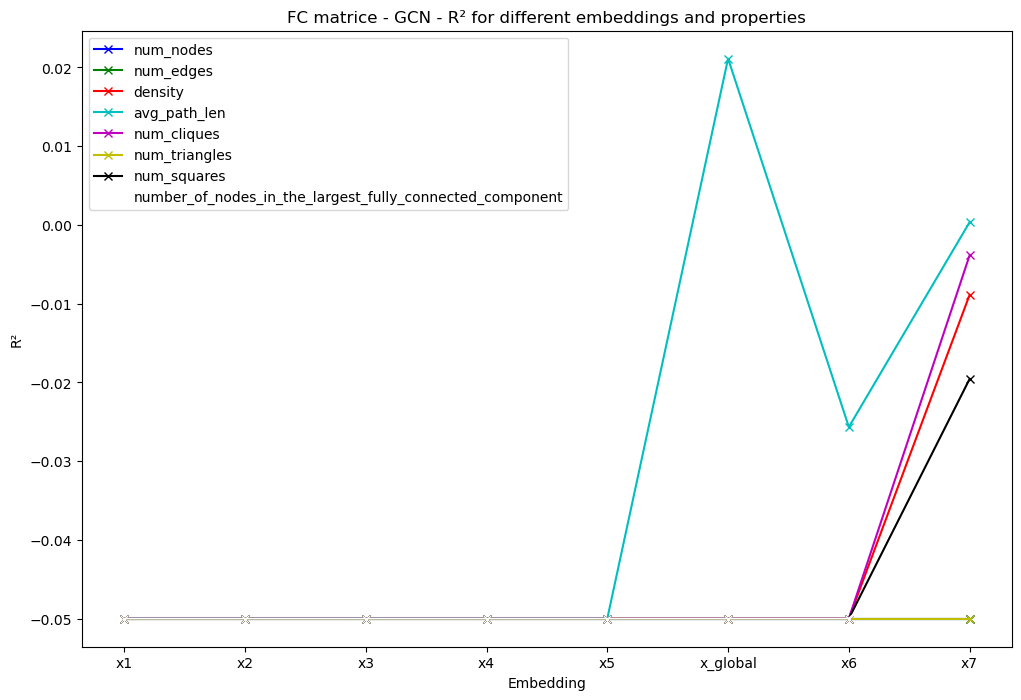

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

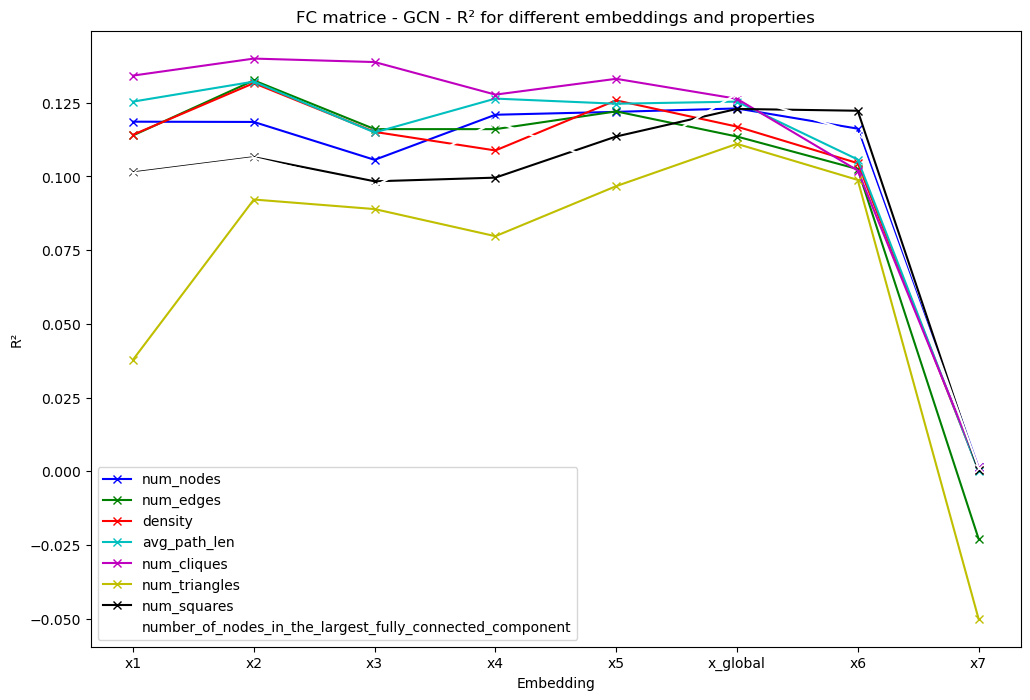

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_train_R2_plot.png', dpi=300, bbox_inches='tight')


# Test with new function that has limited convergence to see if it impacts the test R2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score

#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "wb") as f:
    pkl.dump(results, f)

In [17]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv.pkl", "rb") as f:
    results = pkl.load(f)

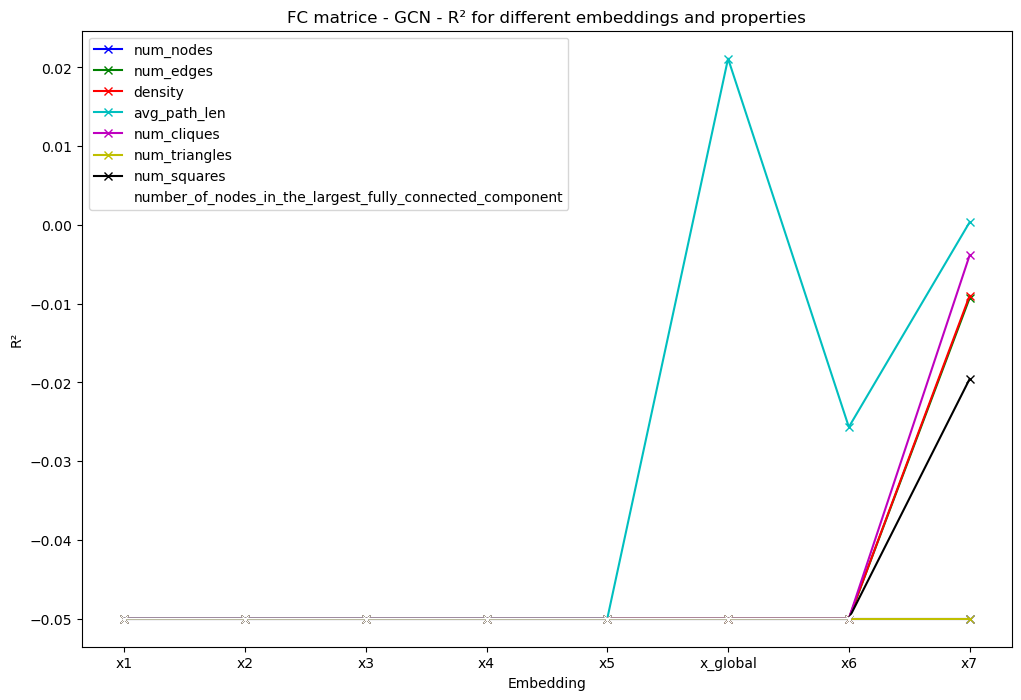

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

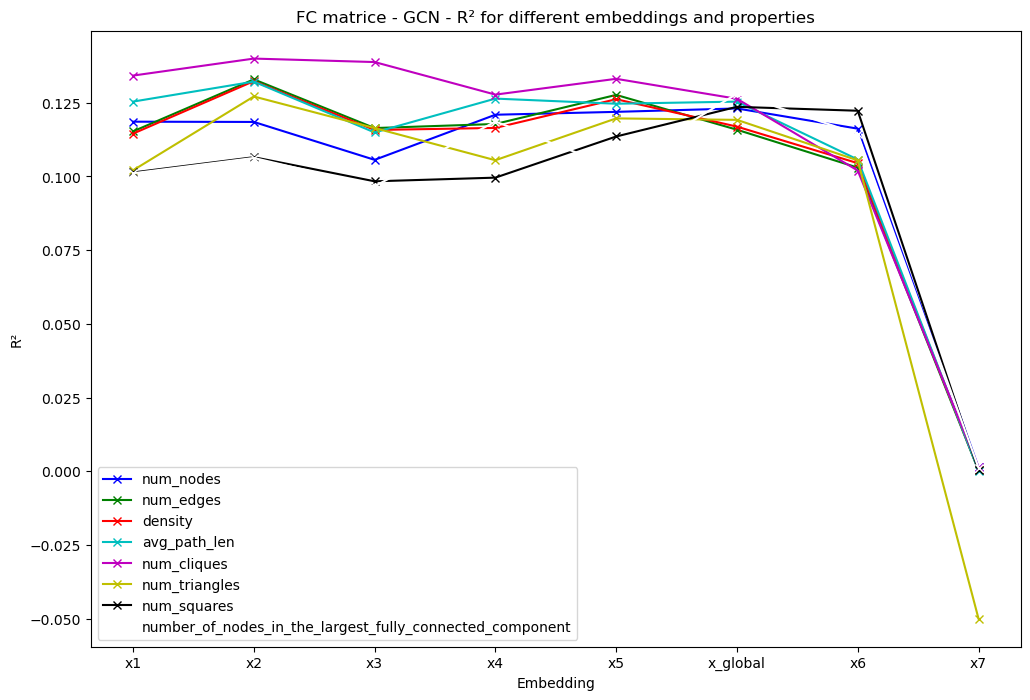

<Figure size 640x480 with 0 Axes>

In [19]:
# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x_global', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_name)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv.png', dpi=300, bbox_inches='tight')

#### Test with more properties

In [ ]:
import networkx as nx
import numpy as np

def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Use the average path length of the largest connected component for disconnected graphs
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    
def betweenness_centralization(G):
    n = len(G)
    betweenness = nx.betweenness_centrality(G)
    max_betweenness = max(betweenness.values())
    centralization = sum(max_betweenness - bet for bet in betweenness.values())
    if n > 2:
        centralization /= (n - 1) * (n - 2) / 2
    return centralization

def pagerank_centralization(G, alpha=0.85):
    n = len(G)
    pagerank = nx.pagerank(G, alpha=alpha)
    max_pagerank = max(pagerank.values())
    centralization = sum(max_pagerank - pr for pr in pagerank.values())
    if n > 1:
        centralization /= (n - 1)
    return centralization

def clustering_properties(G):
    average_clustering = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    return average_clustering, transitivity

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Number of nodes
        num_nodes = G.number_of_nodes()
        
        # Number of edges
        num_edges = G.number_of_edges()
        
        # Density
        density = nx.density(G)
        
        # Average Path Length
        avg_path_len = calculate_avg_path_length(G)
        
        # Diameter
        if nx.is_connected(G):
            diameter = nx.diameter(G)
        else:
            # Use the diameter of the largest connected component for disconnected graphs
            components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
            largest_component = max(components, key=len)
            diameter = nx.diameter(largest_component)
        
        # Radius
        if nx.is_connected(G):
            radius = nx.radius(G)
        else:
            radius = nx.radius(largest_component)
        
        # Clustering Coefficient
        clustering_coeff = nx.average_clustering(G)
        
        # Transitivity
        transitivity = nx.transitivity(G)
        
        # Assortativity
        assortativity = nx.degree_assortativity_coefficient(G)
        
        # Number of Cliques
        num_cliques = len(list(nx.find_cliques(G)))
        
        # Number of Triangles
        num_triangles = sum(nx.triangles(G).values()) / 3
        
        # Number of Squares (4-cycles)
        num_squares = sum(nx.square_clustering(G).values()) / 4
        
        # Size of the Largest Connected Component
        largest_component_size = len(max(nx.connected_components(G), key=len))
        
        # Average Degree
        degrees = [d for n, d in G.degree()]
        avg_degree = np.mean(degrees)
        
        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(G)
        avg_betweenness_centrality = np.mean(list(betweenness_centrality.values()))
        
        # Eigenvalues of the Adjacency Matrix (for spectral properties)
        eigenvalues = np.linalg.eigvals(nx.adjacency_matrix(G).todense())
        spectral_radius = max(eigenvalues)
        algebraic_connectivity = sorted(eigenvalues)[1]  # second smallest eigenvalue
        
        # Graph Laplacian Eigenvalues
        laplacian_eigenvalues = np.linalg.eigvals(nx.laplacian_matrix(G).todense())
        graph_energy = sum(abs(laplacian_eigenvalues))
        
        # Small-World-ness
        # Compare clustering coefficient and average path length with those of a random graph
        random_graph = nx.gnm_random_graph(num_nodes, num_edges)
        random_clustering_coeff = nx.average_clustering(random_graph)
        random_avg_path_len = calculate_avg_path_length(random_graph)
        small_world_coefficient = (clustering_coeff / random_clustering_coeff) / (avg_path_len / random_avg_path_len)

        # Calculate Betweenness Centralization
        betweenness_cent = betweenness_centralization(G)
        print(f"Betweenness Centralization: {betweenness_cent}")

        # Calculate PageRank Centralization
        pagerank_cent = pagerank_centralization(G)
        print(f"PageRank Centralization: {pagerank_cent}")

        # Calculate Clustering properties
        avg_clustering, transitivity = clustering_properties(G)
        print(f"Average Clustering Coefficient: {avg_clustering}")
        print(f"Transitivity: {transitivity}")
        
        properties.append({
            "num_nodes": num_nodes,
            "num_edges": num_edges,
            "density": density,
            "avg_path_len": avg_path_len,
            "diameter": diameter,
            "radius": radius,
            "clustering_coeff": clustering_coeff,
            "transitivity": transitivity,
            "assortativity": assortativity,
            "num_cliques": num_cliques,
            "num_triangles": num_triangles,
            "num_squares": num_squares,
            "largest_component_size": largest_component_size,
            "avg_degree": avg_degree,
            "avg_betweenness_centrality": avg_betweenness_centrality,
            "spectral_radius": spectral_radius,
            "algebraic_connectivity": algebraic_connectivity,
            "graph_energy": graph_energy,
            "small_world_coefficient": small_world_coefficient
        })
    return properties

train_idx_list = gnn.train_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in train_idx_list]
train_properties_long = compute_graph_properties(selected_dataset)
test_idx_list = gnn.test_idx.tolist()
selected_dataset = [gnn.dataset[i] for i in test_idx_list]
test_properties_long = compute_graph_properties(selected_dataset)

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "wb") as f:
    pkl.dump(train_properties_long, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "wb") as f:
    pkl.dump(test_properties_long, f)



In [20]:
#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_long.pkl", "rb") as f:
    train_properties_long = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_long.pkl", "rb") as f:
    test_properties_long = pkl.load(f)

In [26]:
#print the names of the properties
print(train_properties_long[0].keys())

#print the first element of the properties
print(train_properties_long[0])

dict_keys(['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient'])
{'num_nodes': 116, 'num_edges': 717, 'density': 0.10749625187406296, 'avg_path_len': 2.6724137931034484, 'diameter': 5, 'radius': 4, 'clustering_coeff': 0.5179222969842621, 'transitivity': 0.5032389055399787, 'assortativity': 0.3963636188813396, 'num_cliques': 263, 'num_triangles': 1735.0, 'num_squares': 6.64946643069199, 'largest_component_size': 116, 'avg_degree': 12.362068965517242, 'avg_betweenness_centrality': 0.014670296430732001, 'spectral_radius': 19.01239766801048, 'algebraic_connectivity': -4.847745206080066, 'graph_energy': 1434.000000000001, 'small_world_coefficient': 4.049203266711144}


In [ ]:
property_names_long = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'diameter', 'radius', 'clustering_coeff', 'transitivity', 'assortativity', 'num_cliques', 'num_triangles', 'num_squares', 'largest_component_size', 'avg_degree', 'avg_betweenness_centrality', 'spectral_radius', 'algebraic_connectivity', 'graph_energy', 'small_world_coefficient']
train_y_long = torch.tensor(train_properties_long, dtype=torch.float32)
test_y_long = torch.tensor(test_properties_long, dtype=torch.float32)
#create a dictionary where we will store the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names_long):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 800000  # Maximum number of epochs
        min_epochs = 1000  # Minimum number of epochs
        patience = 3000  # Number of epochs to wait for improvement
        tolerance = 1e-6  # Tolerance for considering the loss as stable

        best_loss = float('inf')
        no_improve_count = 0
        
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y_long[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Print every 1000 epochs
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

            # Check for early stopping, but only after minimum epochs
            if epoch >= min_epochs:
                if loss.item() < best_loss - tolerance:
                    best_loss = loss.item()
                    no_improve_count = 0
                else:
                    no_improve_count += 1

                if no_improve_count >= patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y_long[:, i].cpu().numpy()
            test_target = test_y_long[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embedding = embeddings_names[ii]
            results[(name_of_embedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "wb") as f:
    pkl.dump(results, f)

In [22]:
#load results
with open("results/"+DATASET+"_"+MODEL+"_results_limited_cv_long.pkl", "rb") as f:
    results = pkl.load(f)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomdu\AppData\Local\Temp\ipykernel_20392\228186075.py", line 10, in <module>
    test_r2 = results[(name_of_embedding, property_names_long)][3]
KeyError: ('x1', 'diameter')

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\tomdu\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1319, in structured_traceback
    return VerboseTB.structured_traceback(
  File "c:\Users\tomdu\min

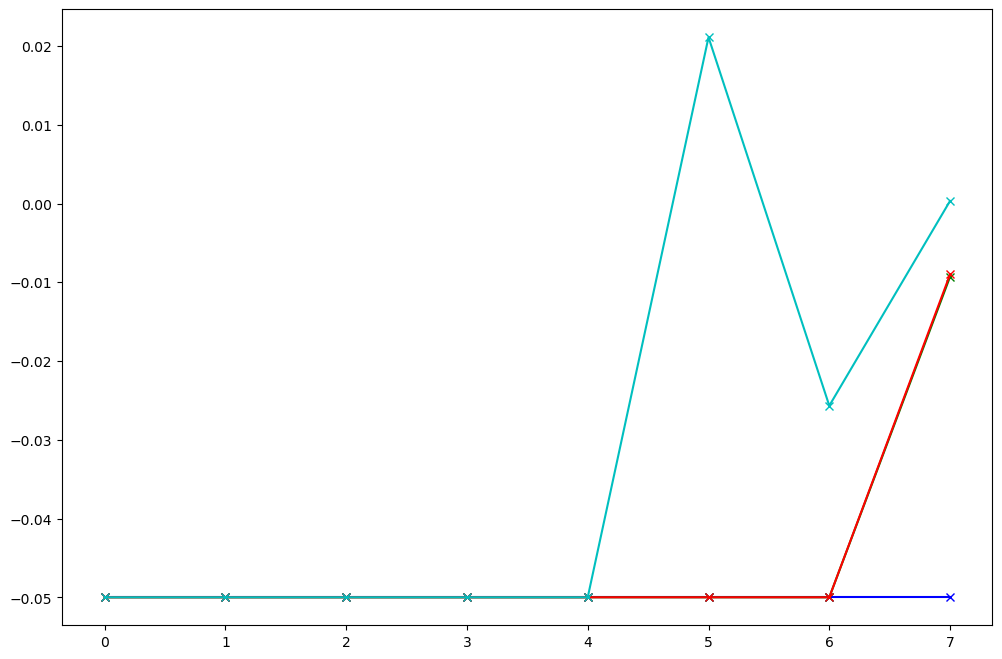

In [23]:

colors_long = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_names_long)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_test_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(12, 8))

for i, property_names_long in enumerate(property_names_long):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        train_r2 = results[(name_of_embedding, property_names_long)][2]
        if train_r2 < -0.05:  # Handle negative R² values
            train_r2 = -0.05
        x_points.append(j)
        y_points.append(train_r2)

    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_names_long, color=colors_long[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('FC matrice - GCN - R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+"_"+MODEL+'_train_R2_plot_limited_cv_long.png', dpi=300, bbox_inches='tight')
    